In [1]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install mne-connectivity

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
import gc
from glob import glob
import numpy as np
import scipy as sp
import statistics, math
import random as rd
import pandas as pd
import dataframe_image as dfi
pd.options.display.float_format = '{:,.2f}'.format

from math import sqrt, ceil

from sklearn import metrics, svm
from sklearn import decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, 
                             balanced_accuracy_score, precision_score, recall_score, RocCurveDisplay)
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from scipy.spatial.distance import correlation
from IPython.display import display

In [4]:
import mne
#import mne_connectivity

from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, annotate_muscle_zscore, peak_finder,
                               find_eog_events, find_ecg_events, ica_find_ecg_events, find_bad_channels_maxwell)
from mne.time_frequency import (tfr_array_multitaper, psd_array_multitaper, csd_array_multitaper, csd_array_morlet)

from mne_connectivity import seed_target_indices, spectral_connectivity_epochs, spectral_connectivity_time

print(mne.__file__)
print(mne.__version__)

C:\Users\Lenovo\anaconda3\lib\site-packages\mne\__init__.py
1.3.1


In [5]:
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve, Scaler, Filtering, Amplitude, PersistenceEntropy, NumberOfPoints
from gtda.plotting import plot_point_cloud


In [6]:
# Configure the graphics engine

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.rc('figure', max_open_warning=200)
%matplotlib notebook
#%matplotlib inline
#%matplotlib qt

In [7]:
import seaborn as sns
# Apply the default theme
sns.set_theme()

In [8]:
# My modules
import my_varexplore as ve
import my_dimreduct as dr
import my_clustquality as cq
import my_stageprocess as spr

# Loading data

In [9]:
#==============================================
# Input main data information
#==============================================

# Number of the subject for analysis
SUBJ_NUM = 10

# For m1 and m3 suffix for EEG record number 
SUFFIX = ''


In [10]:
# Initialize path variables for main folders

print(os.getcwd())

if (SUBJ_NUM < 10):
    subj_dir_name = 'm0' + str(SUBJ_NUM) + SUFFIX
else:
    subj_dir_name = 'm' + str(SUBJ_NUM) + SUFFIX

# Add suffix _surr for surrogate data to destination folder
subj_dir_name_stg = subj_dir_name + '_stg'
    
# Path for loading EEG raw data
init_dir_path = os.path.join(os.getcwd(), 'work_data')

# Path for loading raw data and stage boundaries
ft_dir_path = os.path.join(os.getcwd(), 'features', subj_dir_name)

# Path for saving epoch data and features
dest_dir_path = os.path.join(os.getcwd(), 'features', subj_dir_name_stg)

# Create destination folder if not exists
if not os.path.exists(dest_dir_path):
    os.mkdir(dest_dir_path)

print(init_dir_path)
print(ft_dir_path)
print(dest_dir_path)


C:\Users\Lenovo\PycharmProjects\Tibet
C:\Users\Lenovo\PycharmProjects\Tibet\work_data
C:\Users\Lenovo\PycharmProjects\Tibet\features\m10
C:\Users\Lenovo\PycharmProjects\Tibet\features\m10_stg


In [ ]:
# Loading epochs (Meditator data)

epochs_filt_rr = mne.read_epochs(os.path.join(ft_dir_path, 'epochs_filt_rr-epo.fif'))
#epochs_filt_rr = epochs_filt_rr[:-2] # for m8 (artifacts at the end)
print(epochs_filt_rr.get_data().shape)

sampling_rate = epochs_filt_rr.info['sfreq']
n_samples = epochs_filt_rr.__len__()
n_times = len(epochs_filt_rr.get_data()[0,0,:])
print(n_samples, n_times)

ch_names = epochs_filt_rr.ch_names
n_channels = len(ch_names)
print(ch_names)

In [11]:
# Loading raw data and initial stage boundaries

# Filtered raw data
data_rr_filt = mne.io.read_raw_fif(os.path.join(ft_dir_path, 'data_rr_filt-raw.fif'))
print(data_rr_filt.get_data().shape)

# Stage boundaries
st_edges_result = np.loadtxt(os.path.join(ft_dir_path, 'st_edges_result.txt'), dtype=int)
st_edges_res_samp = np.loadtxt(os.path.join(ft_dir_path, 'st_edges_res_samp.txt'), dtype=int)

print(st_edges_result)
print(st_edges_res_samp)

n_stages = len(st_edges_res_samp)
print(n_stages, data_rr_filt.first_samp)

Opening raw data file C:\Users\Lenovo\PycharmProjects\Tibet\features\m08\data_rr_filt-raw.fif...
    Range : 4000 ... 1176000 =      8.000 ...  2352.000 secs
Ready.
(40, 1172001)
[   0  370  526  724 1052 1275 1489 1857 2017]
[   5250  218250  309750  428250  621250  751750  876250 1085250]
8 4000


In [12]:
# Global variables

n_stages = len(st_edges_res_samp)

sampling_rate = data_rr_filt.info['sfreq']
first_samp = data_rr_filt.first_samp
print('N_stages:', n_stages, ' Sampling_rate:', sampling_rate, ' First_samp:', first_samp)

ch_names = data_rr_filt.ch_names
n_channels = len(ch_names)
print(n_channels, ch_names)

N_stages: 8  Sampling_rate: 500.0  First_samp: 4000
40 ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FT7', 'FC3', 'FCz', 'FC4', 'FT8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'A1', 'T5', 'P3', 'Pz', 'P4', 'T6', 'A2', 'P5', 'PO3', 'POz', 'PO4', 'P6', 'PO7', 'O1', 'Oz', 'O2', 'PO8']


# Shuffling stages

In [13]:
# Correction with raw data first_samp and add edge time points

st_edges_samp_corr = list(st_edges_res_samp[1:] - first_samp)
st_edges_samp_corr += list([0, int(data_rr_filt.times[-1]*sampling_rate)])
st_edges_samp_corr = sorted(st_edges_samp_corr)
print(st_edges_samp_corr)

st_edges_time_corr = [st_edges_samp_corr[i]/sampling_rate for i in range(len(st_edges_samp_corr))]
print(st_edges_time_corr)


[0, 214250, 305750, 424250, 617250, 747750, 872250, 1081250, 1172000]
[0.0, 428.5, 611.5, 848.5, 1234.5, 1495.5, 1744.5, 2162.5, 2344.0]


In [14]:
# Shuffle raw data 

# Remember random seed
rnd_seed = rd.randint(0,100)
print(rnd_seed)
rd.seed(rnd_seed)
#rd.seed(65) # for m10
rd.seed(60) # for m8

# Shuffle stage indices
shuf_piece_ind = np.arange(n_stages)
rd.shuffle(shuf_piece_ind)
print(shuf_piece_ind)
print(['St'+str(n+1) for n in shuf_piece_ind])

# Construct shuffled raw data
data_st_shuf = data_rr_filt.copy().crop(tmin=0, tmax=0)
for _ind in shuf_piece_ind:
    data_piece = data_rr_filt.copy().crop(tmin=st_edges_time_corr[_ind], tmax=st_edges_time_corr[_ind+1])
    data_st_shuf.append(data_piece)
    #print(_ind, np.where(shuf_piece_ind==_ind)[0])
                    
#data_rr_filt.plot()
#data_st_shuf.plot()
print()


59
[3 5 0 6 1 7 2 4]
['St4', 'St6', 'St1', 'St7', 'St2', 'St8', 'St3', 'St5']



In [15]:
# Remove BAD annotations after appending data

ann = data_st_shuf.annotations.copy()
print(len(ann))

bad_ann_ind = []
for i in range(len(ann)):
    if (ann[i]['description']=='BAD boundary'):
        bad_ann_ind += [i]
print(bad_ann_ind)
data_st_shuf.annotations.delete(bad_ann_ind)
print(data_st_shuf.annotations)

16
[0, 2, 4, 6, 8, 10, 12, 14]
<Annotations | 8 segments: EDGE boundary (8)>


In [16]:
# Construct new stage edges array for validation

event_list, event_dict = mne.events_from_annotations(data_st_shuf, regexp = 'EDGE boundary')
print(event_list)
st_edges_samp_init = event_list[1:,0]
print(st_edges_samp_init)


Used Annotations descriptions: ['EDGE boundary']
[[   4001       0       1]
 [ 197001       0       1]
 [ 321501       0       1]
 [ 535751       0       1]
 [ 744751       0       1]
 [ 836251       0       1]
 [ 927001       0       1]
 [1045501       0       1]]
[ 197001  321501  535751  744751  836251  927001 1045501]


# Epoching data

In [17]:
gc.collect()

45

## Global variables & filtering

In [18]:
# Frequency bands

bands = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 8, 'Theta (4-8 Hz)', 'T'), (8, 14, 'Alpha (8-14 Hz)', 'A'), 
         (14, 25, 'Beta (14-25 Hz)', 'B'), (25, 40, 'Gamma (25-40 Hz)', 'G')]

bands_test = [(0.9, 4, 'Delta (0.9-4 Hz)', 'D'), (4, 7, 'Theta (4-7 Hz)', 'T'), (7, 10, 'Alpha1 (7-10 Hz)','A1'), 
         (10, 13, 'Alpha2 (10-13 Hz)', 'A2'), (13, 20, 'Beta1 (13-20 Hz)', 'B1'), (20, 30, 'Beta2 (20-30 Hz)', 'B2'), 
         (30, 45, 'Gamma (30-45 Hz)', 'G')]

str_freq = [bands[i][3] for i in range(len(bands))]
#str_freq_rr = ['r'+_str for _str in str_freq]
str_freq_rr = str_freq
n_freq = len(str_freq_rr)


In [19]:
# Localization by scalp regions

regions = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3'], 'LC', 'Left Central'), (['Cz','CPz'], 'MC', 'Midline Central'), (['C4','CP4'], 'RC', 'Right Central'),
           (['P3','P5'], 'LP', 'Left Parietal'), (['Pz'], 'MP', 'Midline Parietal'), (['P4','P6'], 'RP', 'Right Parietal'), 
           (['PO3','PO7','O1'], 'LO', 'Left Occipital'), (['POz','Oz'], 'MO', 'Midline Occipital'), 
           (['PO4','PO8','O2'], 'RO', 'Right Occipital')]
regions_plt = [(['Fp1','Fp2','Fpz'], 'Fp', 'Pre-frontal'), (['F7','F3','FT7','FC3'], 'LF', 'Left Frontal'), 
           (['Fz','FCz'], 'MF', 'Midline Frontal'), (['F4','F8','FC4','FT8'], 'RF', 'Right Frontal'),
           (['T3','TP7','T5'], 'LT', 'Left Temporal'), (['T4','TP8','T6'], 'RT', 'Right Temporal'), 
           (['C3','CP3','Cz','CPz','C4','CP4'], 'Cen', 'Central'), (['P3','P5','Pz','P4','P6'], 'Par', 'Parietal'), 
           (['PO3','PO7','O1','POz','Oz','PO4','PO8','O2'], 'Occ', 'Occipital')]

n_regions = len(regions)
n_regions_plt = len(regions_plt)

## Epoching

In [20]:
# Epochs by fixed length events, duration 1s, overlap 0.2s (re-referenced)

# Rename raw data
data_rr_filt = data_st_shuf.copy()

# Form epochs
fix_1s_events_rr = mne.make_fixed_length_events(data_rr_filt, start=0.5, duration=1., overlap=0.2) # for m10
#fix_1s_events_rr = mne.make_fixed_length_events(data_rr_filt, start=0.5, duration=1.)
kwargs = dict(baseline=None, tmin=-0.5, tmax=0.5, preload=True)

epochs_fix_1s_rr = mne.Epochs(data_rr_filt, fix_1s_events_rr.astype(int), **kwargs)
epochs_fix_1s_rr = epochs_fix_1s_rr[1:-1] #remove first and last 2sec due to possible filtering artefacts

print(fix_1s_events_rr.shape)
print(epochs_fix_1s_rr)
print(epochs_fix_1s_rr.get_data().shape)
#print(epochs_fix_1s_rr.events)

#epochs_fix_rr_spectr = []
#for i in range(len(bands)):   
#    epochs_fix_rr_spectr.append(mne.Epochs(data_rr_filt_spectr[i], fix_1s_events_rr.astype(int), **kwargs))
#    epochs_fix_rr_spectr[i] = epochs_fix_rr_spectr[i][2:-2] 

#epochs_fix_1s_rr.average().plot_joint()
print()

Not setting metadata
2929 matching events found
No baseline correction applied
0 projection items activated
Loading data for 2929 events and 501 original time points ...
0 bad epochs dropped
(2929, 3)
<Epochs |  2927 events (all good), -0.5 - 0.5 sec, baseline off, ~447.6 MB, data loaded,
 '1': 2927>
(2927, 40, 501)



No projector specified for this dataset. Please consider the method self.add_proj.


<IPython.core.display.Javascript object>


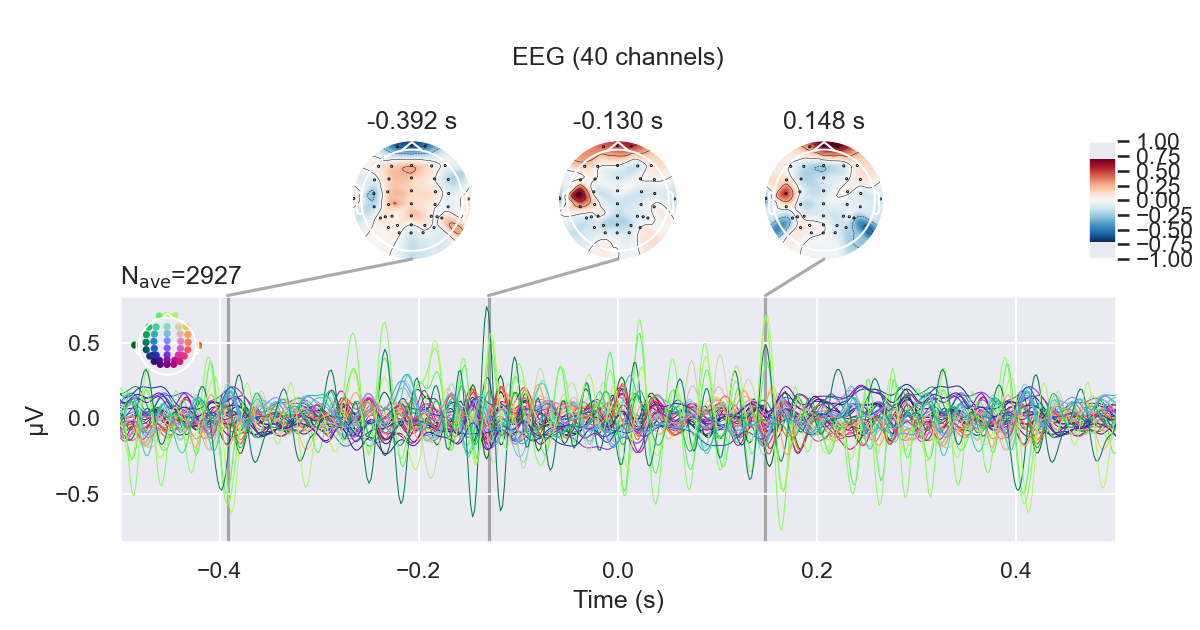

In [26]:
epochs_fix_1s_rr.average().plot_joint()
print()

In [21]:
# Global variables

n_freq = len(str_freq_rr)
n_samples = epochs_fix_1s_rr.__len__()
n_times = len(epochs_fix_1s_rr.get_data()[0,0,:])

print(n_freq, n_samples, n_times)
print(epochs_fix_1s_rr.events)

5 2927 501
[[   4650       0       1]
 [   5050       0       1]
 [   5450       0       1]
 ...
 [1174250       0       1]
 [1174650       0       1]
 [1175050       0       1]]


# Extract features

## PSD features

In [22]:
# Calculating PSD for re-referenced epochs (Multitaper)

kwargs = dict(fmin=bands[0][0], fmax=bands[-1][1], sfreq=sampling_rate, bandwidth=None, adaptive=True, n_jobs=1)

rr_psd_mtaper, rr_freq_mtaper = psd_array_multitaper(epochs_fix_1s_rr.get_data(), **kwargs)
freq_masks = [(fmin < rr_freq_mtaper) & (rr_freq_mtaper < fmax) for (fmin, fmax, _, _) in bands]
loc_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions]
loc_plt_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions_plt]
print(rr_freq_mtaper)
print(rr_psd_mtaper.shape)

ft_psd_spectr_raw = np.array([np.mean(rr_psd_mtaper[:,:, _freq_mask], axis=2) for _freq_mask in freq_masks]).transpose(1,2,0)
ft_psd_sp_loc_raw = np.array([np.mean(ft_psd_spectr_raw[:,_mask,:], axis=1) for _mask in loc_masks]).transpose(1,0,2)
ft_psd_sp_plt_raw = np.array([np.mean(ft_psd_spectr_raw[:,_mask,:], axis=1) for _mask in loc_plt_masks]).transpose(1,0,2)
ft_psd_sp_all_raw = np.mean(ft_psd_spectr_raw, axis=1)

ft_psd_spectr_db = 10 * np.log10(ft_psd_spectr_raw) # Convert psd to dB format
ft_psd_sp_loc_db = 10 * np.log10(ft_psd_sp_loc_raw) # Convert psd to dB 
ft_psd_sp_plt_db = 10 * np.log10(ft_psd_sp_plt_raw) # Convert psd to dB format
ft_psd_sp_all_db = 10 * np.log10(ft_psd_sp_all_raw) # Convert psd to dB format

df_ft_psd_raw = pd.DataFrame()
df_ft_psd_db = pd.DataFrame()
df_ft_psd_loc_raw = pd.DataFrame()
df_ft_psd_loc_db = pd.DataFrame()
df_ft_psd_plt_raw = pd.DataFrame()
df_ft_psd_plt_db = pd.DataFrame()
df_ft_psd_all_raw = pd.DataFrame()
df_ft_psd_all_db = pd.DataFrame()

for i in range(n_freq):
    for j in range(n_channels):
        df_ft_psd_raw[str_freq_rr[i]+'_psd_'+ch_names[j]] = ft_psd_spectr_raw[:,j,i]
        df_ft_psd_db[str_freq_rr[i]+'_psd_'+ch_names[j]] = ft_psd_spectr_db[:,j,i]
    for j in range(n_regions):    
        df_ft_psd_loc_raw[str_freq_rr[i]+'_psd_'+regions[j][1]] = ft_psd_sp_loc_raw[:,j,i]
        df_ft_psd_loc_db[str_freq_rr[i]+'_psd_'+regions[j][1]] = ft_psd_sp_loc_db[:,j,i]
    for j in range(n_regions_plt):    
        df_ft_psd_plt_raw[str_freq_rr[i]+'_psd_'+regions_plt[j][1]] = ft_psd_sp_plt_raw[:,j,i]
        df_ft_psd_plt_db[str_freq_rr[i]+'_psd_'+regions_plt[j][1]] = ft_psd_sp_plt_db[:,j,i]
    df_ft_psd_all_raw[str_freq_rr[i]+'_psd_All'] = ft_psd_sp_all_raw[:,i]
    df_ft_psd_all_db[str_freq_rr[i]+'_psd_All'] = ft_psd_sp_all_db[:,i]
#print(len(df_ft_psd_db.columns))

# Scaling dB re-referenced data
ft_psd_db_sc = StandardScaler().fit_transform(df_ft_psd_db.to_numpy())
df_ft_psd_db_sc = pd.DataFrame(ft_psd_db_sc, columns=df_ft_psd_db.columns)
ft_psd_loc_db_sc = StandardScaler().fit_transform(df_ft_psd_loc_db.to_numpy())
df_ft_psd_loc_db_sc = pd.DataFrame(ft_psd_loc_db_sc, columns=df_ft_psd_loc_db.columns)
ft_psd_all_db_sc = StandardScaler().fit_transform(df_ft_psd_all_db.to_numpy())
df_ft_psd_all_db_sc = pd.DataFrame(ft_psd_all_db_sc, columns=df_ft_psd_all_db.columns)

    Using multitaper spectrum estimation with 7 DPSS windows
[ 0.99800399  1.99600798  2.99401198  3.99201597  4.99001996  5.98802395
  6.98602794  7.98403194  8.98203593  9.98003992 10.97804391 11.9760479
 12.9740519  13.97205589 14.97005988 15.96806387 16.96606786 17.96407186
 18.96207585 19.96007984 20.95808383 21.95608782 22.95409182 23.95209581
 24.9500998  25.94810379 26.94610778 27.94411178 28.94211577 29.94011976
 30.93812375 31.93612774 32.93413174 33.93213573 34.93013972 35.92814371
 36.9261477  37.9241517  38.92215569 39.92015968]
(2927, 40, 40)


# Remove artifacts 

In [23]:
# Plotting PSD with mean and std

n_samples = epochs_fix_1s_rr.__len__()
n_times = len(epochs_fix_1s_rr.get_data()[0,0,:])

ft_psd_all = df_ft_psd_all_db.to_numpy()

_d = 30 # half-interval for calculating mean and std
_coef = 3 # Coefficient for recognizing outlayers
outl_epochs = []
for _freq in range(n_freq):
    
    x = np.arange(n_samples)
    y = ft_psd_all[:,_freq]
    y_mean = np.zeros(n_samples)
    y_std = np.zeros(n_samples)
    outl = []
    
    for _s in range(n_samples):
        y_mean[_s] = np.mean(ft_psd_all[max(0, _s-_d):min(_s+_d, n_samples),_freq])
        y_std[_s] = np.std(ft_psd_all[max(0, _s-_d):min(_s+_d, n_samples),_freq])
        if (y[_s] < y_mean[_s] - _coef*y_std[_s]) or (y[_s] > y_mean[_s] + _coef*y_std[_s]):
            outl.append(_s)
    print(bands[_freq][2], len(outl), outl)
    outl_epochs += outl
    
    #fig, ax = plt.subplots() 
    #ax.plot(x, y)
    #ax.fill_between(x, y_mean+_coef*y_std, y_mean-_coef*y_std, facecolor='blue', alpha=0.4)
    #ax.plot(y_mean, color='blue')
    #ax.set_title("PSD features "+ bands[_freq][2])

outl_epochs = np.unique(outl_epochs)
print(len(outl_epochs), outl_epochs)

Delta (0.9-4 Hz) 15 [21, 256, 372, 373, 1033, 1417, 1418, 1455, 1729, 1809, 1810, 2213, 2214, 2463, 2608]
Theta (4-8 Hz) 15 [256, 372, 373, 961, 1222, 1417, 1563, 1809, 2146, 2171, 2213, 2463, 2692, 2713, 2862]
Alpha (8-14 Hz) 13 [8, 58, 93, 131, 410, 455, 1635, 1731, 1773, 1774, 1809, 2777, 2823]
Beta (14-25 Hz) 13 [16, 52, 293, 352, 479, 602, 1483, 1569, 1663, 1664, 1809, 2450, 2489]
Gamma (25-40 Hz) 3 [372, 679, 1420]
49 [   8   16   21   52   58   93  131  256  293  352  372  373  410  455
  479  602  679  961 1033 1222 1417 1418 1420 1455 1483 1563 1569 1635
 1663 1664 1729 1731 1773 1774 1809 1810 2146 2171 2213 2214 2450 2463
 2489 2608 2692 2713 2777 2823 2862]


In [24]:
# Plotting PSD with mean and std

df_ft_psd_loc = df_ft_psd_loc_db

#_d = int(0.03*n_samples) # half-interval for calculating mean and std
_d = 30
_coef = 3 # Coefficient for recognizing outlayers
outl_epochs = []

df_ft_psd_loc_stats = pd.DataFrame()

for i in range(len(df_ft_psd_loc.columns)):
    
    ft_name = df_ft_psd_loc.columns[i]
    outl = []
    
    x = np.arange(n_samples)
    y = df_ft_psd_loc.to_numpy()[:,i]
    y_mean = np.zeros(n_samples)
    y_std = np.zeros(n_samples)
    
    for _s in range(n_samples):
        y_mean[_s] = np.mean(y[max(0, _s-_d):min(_s+_d, n_samples)])
        y_std[_s] = np.std(y[max(0, _s-_d):min(_s+_d, n_samples)])
        if (y[_s] < y_mean[_s] - _coef*y_std[_s]) or (y[_s] > y_mean[_s] + _coef*y_std[_s]):
            outl.append(_s)
    print(ft_name, len(outl), outl)
    outl_epochs += outl
    df_ft_psd_loc_stats[ft_name+'_mean'] = y_mean
    df_ft_psd_loc_stats[ft_name+'_std'] = y_std
    
    # Plotting PSD
    #fig, ax = plt.subplots() 
    #ax.plot(x, y)
    #ax.fill_between(x, y_mean+_coef*y_std, y_mean-_coef*y_std, facecolor='blue', alpha=0.4)
    #ax.plot(y_mean, color='blue')
    #ax.set_title("PSD features " + ft_name)

outl_epochs = np.unique(outl_epochs)
print(len(outl_epochs), outl_epochs)
display(df_ft_psd_loc_stats.describe())

D_psd_Fp 13 [21, 372, 373, 1453, 1656, 1809, 2031, 2213, 2463, 2510, 2608, 2713, 2857]
D_psd_LF 8 [21, 256, 372, 373, 1033, 1809, 1810, 2213]
D_psd_MF 5 [71, 372, 373, 1070, 1213]
D_psd_RF 8 [256, 373, 540, 745, 1033, 2312, 2643, 2651]
D_psd_LT 3 [961, 1429, 2320]
D_psd_RT 5 [373, 417, 955, 1033, 2169]
D_psd_LC 5 [880, 881, 1104, 1154, 2430]
D_psd_MC 2 [846, 2353]
D_psd_RC 7 [1111, 1252, 1253, 1326, 1734, 2172, 2331]
D_psd_LP 10 [1, 130, 603, 641, 1431, 1748, 2075, 2215, 2328, 2569]
D_psd_MP 12 [849, 850, 886, 929, 1474, 1959, 2025, 2214, 2388, 2692, 2722, 2822]
D_psd_RP 15 [327, 462, 846, 914, 1010, 1149, 1367, 1728, 1943, 2012, 2112, 2113, 2325, 2394, 2395]
D_psd_LO 7 [597, 897, 1111, 1171, 1213, 1264, 1774]
D_psd_MO 16 [4, 34, 327, 1099, 1100, 1213, 1374, 1915, 1991, 2146, 2147, 2526, 2527, 2584, 2862, 2863]
D_psd_RO 18 [165, 373, 783, 1213, 1417, 1418, 1672, 1931, 1999, 2037, 2146, 2147, 2337, 2443, 2552, 2553, 2692, 2893]
T_psd_Fp 13 [21, 187, 372, 373, 676, 1453, 1563, 1809, 2213

D_psd_Fp_mean  D_psd_Fp_std  D_psd_LF_mean  D_psd_LF_std  \
count       2,927.00      2,927.00       2,927.00      2,927.00   
mean          -87.27          3.27         -89.37          3.40   
std             1.87          0.48           1.69          0.51   
min           -92.69          2.33         -94.72          2.19   
25%           -88.02          2.93         -90.06          3.01   
50%           -87.02          3.21         -89.06          3.35   
75%           -85.83          3.53         -88.20          3.71   
max           -83.33          5.14         -86.33          5.32   

       D_psd_MF_mean  D_psd_MF_std  D_psd_RF_mean  D_psd_RF_std  \
count       2,927.00      2,927.00       2,927.00      2,927.00   
mean          -90.55          3.07         -88.08          3.36   
std             1.85          0.43           1.65          0.62   
min           -94.58          1.77         -93.01          2.03   
25%           -91.56          2.78         -88.93          2.91   
50%           -90.20          3.07         -87.85          3.33   
75%           -89.30          3.34         -87.05          3.76   
max           -85.97          4.16         -83.91          5.29   

       D_psd_LT_mean  D_psd_LT_std  ...  G_psd_MP_mean  G_psd_MP_std  \
count       2,927.00      2,927.00  ...       2,927.00      2,927.00   
mean          -89.64          3.47  ...        -104.91          1.52   
std             2.75          0.46  ...           0.65          0.36   
min           -97.18          1.96  ...        -106.40          1.07   
25%           -90.34          3.22  ...        -105.36          1.36   
50%           -88.71          3.48  ...        -104.97          1.46   
75%           -87.68          3.70  ...        -104.63          1.57   
max           -86.15          5.45  ...        -102.70          3.82   

       G_psd_RP_mean  G_psd_RP_std  G_psd_LO_mean  G_psd_LO_std  \
count       2,927.00      2,927.00       2,927.00      2,927.00   
mean         -103.74          1.20        -104.00          1.22   
std             0.55          0.17           0.60          0.14   
min          -105.09          0.74        -105.32          0.86   
25%          -104.11          1.07        -104.48          1.13   
50%          -103.79          1.18        -104.01          1.23   
75%          -103.40          1.30        -103.51          1.32   
max          -102.35          1.69        -102.64          1.73   

       G_psd_MO_mean  G_psd_MO_std  G_psd_RO_mean  G_psd_RO_std  
count       2,927.00      2,927.00       2,927.00      2,927.00  
mean         -103.37          1.26        -102.59          1.15  
std             0.50          0.17           0.44          0.16  
min          -104.67          0.68        -103.92          0.70  
25%          -103.74          1.14        -102.89          1.04  
50%          -103.37          1.24        -102.60          1.13  
75%          -103.00          1.35        -102.31          1.24  
max          -102.23          1.81        -101.49          1.76  

[8 rows x 150 columns]

In [25]:
# Drop bad epochs (outlayers)

epochs_filt_rr = epochs_fix_1s_rr.copy().drop(outl_epochs)
print(epochs_fix_1s_rr.get_data().shape)
print(epochs_filt_rr.get_data().shape)

n_samples = epochs_filt_rr.__len__()
n_times = len(epochs_filt_rr.get_data()[0,0,:])

# Drop rows from PSD DataFrames
df_ft_psd_raw.drop(index = outl_epochs, inplace=True)
df_ft_psd_db.drop(index = outl_epochs, inplace=True)
df_ft_psd_db_sc.drop(index = outl_epochs, inplace=True)

df_ft_psd_loc_raw.drop(index = outl_epochs, inplace=True)
df_ft_psd_loc_db.drop(index = outl_epochs, inplace=True)
df_ft_psd_loc_db_sc.drop(index = outl_epochs, inplace=True)

df_ft_psd_plt_raw.drop(index = outl_epochs, inplace=True)
df_ft_psd_plt_db.drop(index = outl_epochs, inplace=True)
#df_ft_psd_plt_db_sc.drop(index = outl_epochs, inplace=True)

df_ft_psd_all_raw.drop(index = outl_epochs, inplace=True)
df_ft_psd_all_db.drop(index = outl_epochs, inplace=True)
df_ft_psd_all_db_sc.drop(index = outl_epochs, inplace=True)

df_ft_psd_loc_stats.drop(index = outl_epochs, inplace=True)

# Reseting indices
df_ft_psd_raw.reset_index(drop=True, inplace=True)
df_ft_psd_db.reset_index(drop=True, inplace=True)
df_ft_psd_db_sc.reset_index(drop=True, inplace=True)

df_ft_psd_loc_raw.reset_index(drop=True, inplace=True)
df_ft_psd_loc_db.reset_index(drop=True, inplace=True)
df_ft_psd_loc_db_sc.reset_index(drop=True, inplace=True)

df_ft_psd_plt_raw.reset_index(drop=True, inplace=True)
df_ft_psd_plt_db.reset_index(drop=True, inplace=True)
#df_ft_psd_plt_db_sc.reset_index(drop=True, inplace=True)

df_ft_psd_all_raw.reset_index(drop=True, inplace=True)
df_ft_psd_all_db.reset_index(drop=True, inplace=True)
df_ft_psd_all_db_sc.reset_index(drop=True, inplace=True)

df_ft_psd_loc_stats.reset_index(drop=True, inplace=True)

#display(df_ft_psd_loc_stats)

Dropped 410 epochs: 1, 2, 4, 7, 8, 16, 19, 21, 28, 32, 34, 41, 52, 57, 58, 60, 71, 81, 87, 93, 94, 96, 98, 99, 116, 118, 119, 129, 130, 131, 132, 143, 145, 146, 151, 159, 163, 165, 182, 187, 218, 220, 225, 227, 232, 247, 249, 251, 256, 266, 279, 282, 289, 293, 311, 327, 334, 337, 342, 349, 352, 372, 373, 375, 379, 382, 390, 392, 402, 409, 410, 417, 428, 435, 442, 445, 449, 450, 455, 456, 458, 459, 462, 474, 475, 479, 482, 513, 522, 534, 539, 540, 597, 602, 603, 608, 629, 641, 648, 649, 656, 663, 676, 679, 685, 686, 692, 694, 699, 712, 720, 737, 738, 745, 756, 758, 780, 783, 796, 822, 834, 842, 846, 849, 850, 853, 854, 856, 858, 876, 880, 881, 886, 897, 904, 905, 910, 914, 929, 937, 942, 955, 961, 984, 1010, 1024, 1031, 1033, 1048, 1058, 1062, 1070, 1071, 1082, 1087, 1099, 1100, 1104, 1111, 1113, 1116, 1119, 1125, 1129, 1134, 1141, 1149, 1154, 1163, 1171, 1177, 1199, 1205, 1213, 1222, 1252, 1253, 1260, 1261, 1264, 1274, 1283, 1293, 1295, 1303, 1312, 1316, 1326, 1329, 1332, 1337, 1360, 1

## PSD Indices

In [26]:
df_ft_psd_ind = pd.DataFrame()
df_ft_psd_ind_plt = pd.DataFrame()

str_psd_ind = ['T_D','A_D','A_T','A_DT','B_D','B_T','B_A','B_DT','B_TA','G_D','G_T','G_A','G_B','G_DT','G_TA','G_AB']

df_ft_psd_ind_loc = pd.DataFrame()
df_ft_psd_ind_plt = pd.DataFrame()
df_ft_psd_ind_all = pd.DataFrame()

# Indices per region (averaged PSD)
for _r in range(n_regions):
    for ind in str_psd_ind:
        if (len(ind)==3):
            df_ft_psd_ind_loc[ind+'_psd_'+regions[_r][1]] = (df_ft_psd_loc_raw[ind[0]+'_psd_'+regions[_r][1]] / 
                                                             df_ft_psd_loc_raw[ind[2]+'_psd_'+regions[_r][1]])
        elif (len(ind)==4):
            df_ft_psd_ind_loc[ind+'_psd_'+regions[_r][1]] = (df_ft_psd_loc_raw[ind[0]+'_psd_'+regions[_r][1]] / 
                                                            (df_ft_psd_loc_raw[ind[2]+'_psd_'+regions[_r][1]]+
                                                             df_ft_psd_loc_raw[ind[3]+'_psd_'+regions[_r][1]]))
# Indices per region for plotting (averaged PSD)
for _r in range(n_regions_plt):
    for ind in str_psd_ind:
        if (len(ind)==3):
            df_ft_psd_ind_plt[ind+'_psd_'+regions_plt[_r][1]] = (df_ft_psd_plt_raw[ind[0]+'_psd_'+regions_plt[_r][1]] / 
                                                                 df_ft_psd_plt_raw[ind[2]+'_psd_'+regions_plt[_r][1]])
        elif (len(ind)==4):
            df_ft_psd_ind_plt[ind+'_psd_'+regions_plt[_r][1]] = (df_ft_psd_plt_raw[ind[0]+'_psd_'+regions_plt[_r][1]] / 
                                                                (df_ft_psd_plt_raw[ind[2]+'_psd_'+regions_plt[_r][1]]+
                                                                 df_ft_psd_plt_raw[ind[3]+'_psd_'+regions_plt[_r][1]]))

# Indices for all channels averaged PSD
for ind in str_psd_ind:
    if (len(ind)==3):
        df_ft_psd_ind_all[ind+'_psd_All'] = (df_ft_psd_all_raw[ind[0]+'_psd_All'] / 
                                             df_ft_psd_all_raw[ind[2]+'_psd_All'])
    elif (len(ind)==4):
        df_ft_psd_ind_all[ind+'_psd_All'] = (df_ft_psd_all_raw[ind[0]+'_psd_All'] / 
                                            (df_ft_psd_all_raw[ind[2]+'_psd_All']+
                                             df_ft_psd_all_raw[ind[3]+'_psd_All']))


In [27]:
# Log-scaling PSD indices (dB format)
df_ft_psd_ind_loc_log = 10 * np.log10(df_ft_psd_ind_loc)
df_ft_psd_ind_plt_log = 10 * np.log10(df_ft_psd_ind_plt)
df_ft_psd_ind_all_log = 10 * np.log10(df_ft_psd_ind_all)

# No need to log-scale A|T & A|(D+T) for m10
#orig_col = [col for col in df_ft_psd_ind_loc.columns if ('A_T' in col) or ('A_DT' in col)]
#df_ft_psd_ind_loc_log[orig_col] = df_ft_psd_ind_loc[orig_col]
#orig_col = [col for col in df_ft_psd_ind_plt.columns if ('A_T' in col) or ('A_DT' in col)]
#df_ft_psd_ind_plt_log[orig_col] = df_ft_psd_ind_plt[orig_col]
#orig_col = [col for col in df_ft_psd_ind_all.columns if ('A_T' in col) or ('A_DT' in col)]
#df_ft_psd_ind_all_log[orig_col] = df_ft_psd_ind_all[orig_col]

# Scaling
ft_psd_ind_loc_sc = StandardScaler().fit_transform(df_ft_psd_ind_loc_log.to_numpy())
df_ft_psd_ind_loc_sc = pd.DataFrame(ft_psd_ind_loc_sc, columns=df_ft_psd_ind_loc_log.columns)
ft_psd_ind_all_sc = StandardScaler().fit_transform(df_ft_psd_ind_all_log.to_numpy())
df_ft_psd_ind_all_sc = pd.DataFrame(ft_psd_ind_all_sc, columns=df_ft_psd_ind_all_log.columns)


## Coherence & PLV features

In [28]:
# Averaging epochs by region
loc_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions]
loc_plt_masks = [[ch_names[i] in reg for i in range(n_channels)] for (reg, _, _) in regions_plt]

# Re-referenced data
ft_epochs = epochs_filt_rr.get_data()
ft_epochs_loc = np.array([np.mean(ft_epochs[:,_mask,:], axis=1) for _mask in loc_masks]).transpose(1,0,2)
ft_epochs_plt = np.array([np.mean(ft_epochs[:,_mask,:], axis=1) for _mask in loc_plt_masks]).transpose(1,0,2)

print(ft_epochs.shape)
print(ft_epochs_loc.shape)
print(ft_epochs_plt.shape)
#print(ch_names)

(2517, 40, 501)
(2517, 15, 501)
(2517, 9, 501)


In [29]:
# Calculating CSD (Cross-spectral densities), re-referenced data

ft_csd_matr_sp = []
ft_csd_matr_loc_sp = []
ft_csd_matr_plt_sp = []
kwargs = dict(fmin=bands[0][0], fmax=bands[-1][1], sfreq=sampling_rate, adaptive=True, n_jobs=1)

# Calculating CSD for each epoch (Multitaper)
for i in range(n_samples):
    csd_mtaper = csd_array_multitaper(ft_epochs[i].reshape((1, n_channels, n_times)), **kwargs)
    ft_csd_matr_sp.append([csd_mtaper.mean(fmin, fmax).get_data() for (fmin, fmax, _, _) in bands])
    print(i, np.array(ft_csd_matr_sp[i]).shape)

    csd_mtaper = csd_array_multitaper(ft_epochs_loc[i].reshape((1, n_regions, n_times)), **kwargs)
    ft_csd_matr_loc_sp.append([csd_mtaper.mean(fmin, fmax).get_data() for (fmin, fmax, _, _) in bands])
    print(i, np.array(ft_csd_matr_loc_sp[i]).shape)

    csd_mtaper = csd_array_multitaper(ft_epochs_plt[i].reshape((1, n_regions_plt, n_times)), **kwargs)
    ft_csd_matr_plt_sp.append([csd_mtaper.mean(fmin, fmax).get_data() for (fmin, fmax, _, _) in bands])
    print(i, np.array(ft_csd_matr_plt_sp[i]).shape)
    
ft_csd_matr_sp = np.array(ft_csd_matr_sp)
ft_csd_matr_loc_sp = np.array(ft_csd_matr_loc_sp)
ft_csd_matr_plt_sp = np.array(ft_csd_matr_plt_sp)

print(ft_csd_matr_sp.shape)
print(ft_csd_matr_loc_sp.shape)
print(ft_csd_matr_plt_sp.shape)

    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
0 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
0 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
0 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
3 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
3 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
3 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
4 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
4 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
4 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
5 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
5 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
5 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
6 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
6 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
6 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
7 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
7 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
7 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
8 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
8 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
8 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
9 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
9 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
9 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
10 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
10 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
10 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
11 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
11 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
11 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
12 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
12 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
12 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
13 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
13 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
13 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
14 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
14 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
14 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
15 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
15 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
15 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
16 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
16 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
16 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
17 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
17 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
17 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
18 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
18 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
18 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
19 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
19 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
19 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
20 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
20 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
20 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
21 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
21 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
21 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
22 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
22 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
22 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
23 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
23 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
23 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
24 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
24 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
24 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
25 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
25 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
25 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
26 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
26 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
26 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
27 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
27 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
27 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
28 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
28 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
28 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
29 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
29 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
29 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
30 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
30 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
30 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
31 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
31 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
31 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
32 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
32 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
32 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
33 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
33 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
33 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
34 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
34 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
34 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
35 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
35 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
35 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
36 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
36 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
36 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
37 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
37 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
37 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
38 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
38 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
38 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
39 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
39 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
39 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
40 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
40 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
40 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
41 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
41 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
41 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
42 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
42 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
42 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
43 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
43 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
43 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
44 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
44 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
44 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
45 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
45 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
45 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
46 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
46 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
46 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
47 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
47 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
47 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
48 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
48 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
48 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
49 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
49 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
49 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
50 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
50 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
50 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
51 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
51 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
51 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
52 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
52 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
52 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
53 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
53 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
53 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
54 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
54 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
54 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
55 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
55 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
55 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
56 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
56 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
56 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
57 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
57 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
57 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
58 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
58 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
58 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
59 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
59 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
59 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
60 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
60 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
60 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
61 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
61 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
61 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
62 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
62 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
62 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
63 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
63 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
63 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
64 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
64 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
64 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
65 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
65 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
65 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
66 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
66 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
66 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
67 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
67 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
67 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
68 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
68 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
68 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
69 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
69 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
69 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
70 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
70 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
70 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
71 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
71 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
71 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
72 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
72 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
72 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
73 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
73 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
73 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
74 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
74 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
74 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
75 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
75 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
75 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
76 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
76 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
76 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
77 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
77 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
77 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
78 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
78 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
78 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
79 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
79 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
79 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
80 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
80 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
80 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
81 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
81 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
81 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
82 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
82 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
82 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
83 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
83 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
83 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
84 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
84 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
84 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
85 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
85 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
85 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
86 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
86 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
86 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
87 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
87 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
87 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
88 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
88 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
88 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
89 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
89 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
89 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
90 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
90 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
90 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
91 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
91 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
91 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
92 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
92 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
92 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
93 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
93 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
93 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
94 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
94 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
94 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
95 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
95 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
95 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
96 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
96 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
96 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
97 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
97 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
97 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
98 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
98 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
98 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
99 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
99 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
99 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
100 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
100 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
100 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
101 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
101 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
101 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
102 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
102 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
102 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
103 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
103 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
103 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
104 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
104 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
104 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
105 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
105 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
105 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
106 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
106 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
106 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
107 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
107 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
107 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
108 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
108 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
108 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
109 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
109 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
109 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
110 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
110 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
110 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
111 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
111 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
111 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
112 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
112 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
112 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
113 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
113 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
113 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
114 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
114 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
114 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
115 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
115 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
115 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
116 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
116 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
116 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
117 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
117 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
117 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
118 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
118 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
118 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
119 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
119 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
119 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
120 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
120 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
120 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
121 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
121 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
121 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
122 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
122 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
122 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
123 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
123 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
123 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
124 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
124 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
124 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
125 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
125 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
125 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
126 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
126 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
126 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
127 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
127 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
127 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
128 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
128 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
128 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
129 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
129 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
129 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
130 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
130 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
130 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
131 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
131 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
131 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
132 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
132 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
132 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
133 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
133 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
133 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
134 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
134 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
134 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
135 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
135 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
135 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
136 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
136 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
136 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
137 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
137 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
137 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
138 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
138 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
138 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
139 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
139 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
139 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
140 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
140 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
140 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
141 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
141 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
141 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
142 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
142 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
142 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
143 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
143 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
143 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
144 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
144 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
144 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
145 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
145 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
145 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
146 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
146 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
146 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
147 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
147 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
147 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
148 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
148 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
148 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
149 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
149 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
149 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
150 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
150 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
150 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
151 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
151 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
151 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
152 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
152 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
152 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
153 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
153 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
153 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
154 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
154 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
154 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
155 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
155 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
155 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
156 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
156 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
156 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
157 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
157 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
157 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
158 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
158 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
158 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
159 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
159 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
159 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
160 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
160 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
160 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
161 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
161 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
161 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
162 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
162 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
162 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
163 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
163 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
163 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
164 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
164 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
164 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
165 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
165 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
165 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
166 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
166 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
166 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
167 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
167 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
167 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
168 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
168 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
168 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
169 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
169 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
169 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
170 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
170 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
170 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
171 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
171 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
171 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
172 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
172 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
172 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
173 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
173 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
173 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
174 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
174 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
174 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
175 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
175 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
175 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
176 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
176 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
176 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
177 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
177 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
177 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
178 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
178 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
178 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
179 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
179 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
179 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
180 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
180 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
180 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
181 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
181 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
181 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
182 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
182 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
182 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
183 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
183 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
183 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
184 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
184 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
184 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
185 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
185 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
185 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
186 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
186 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
186 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
187 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
187 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
187 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
188 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
188 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
188 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
189 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
189 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
189 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
190 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
190 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
190 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
191 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
191 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
191 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
192 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
192 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
192 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
193 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
193 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
193 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
194 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
194 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
194 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
195 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
195 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
195 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
196 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
196 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
196 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
197 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
197 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
197 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
198 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
198 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
198 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
199 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
199 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
199 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
200 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
200 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
200 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
201 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
201 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
201 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
202 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
202 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
202 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
203 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
203 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
203 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
204 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
204 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
204 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
205 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
205 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
205 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
206 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
206 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
206 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
207 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
207 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
207 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
208 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
208 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
208 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
209 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
209 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
209 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
210 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
210 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
210 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
211 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
211 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
211 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
212 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
212 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
212 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
213 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
213 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
213 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
214 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
214 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
214 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
215 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
215 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
215 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
216 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
216 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
216 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
217 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
217 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
217 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
218 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
218 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
218 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
219 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
219 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
219 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
220 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
220 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
220 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
221 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
221 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
221 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
222 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
222 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
222 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
223 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
223 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
223 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
224 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
224 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
224 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
225 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
225 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
225 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
226 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
226 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
226 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
227 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
227 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
227 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
228 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
228 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
228 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
229 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
229 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
229 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
230 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
230 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
230 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
231 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
231 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
231 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
232 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
232 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
232 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
233 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
233 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
233 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
234 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
234 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
234 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
235 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
235 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
235 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
236 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
236 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
236 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
237 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
237 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
237 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
238 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
238 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
238 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
239 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
239 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
239 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
240 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
240 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
240 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
241 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
241 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
241 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
242 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
242 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
242 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
243 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
243 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
243 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
244 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
244 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
244 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
245 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
245 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
245 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
246 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
246 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
246 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
247 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
247 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
247 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
248 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
248 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
248 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
249 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
249 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
249 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
250 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
250 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
250 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
251 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
251 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
251 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
252 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
252 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
252 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
253 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
253 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
253 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
254 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
254 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
254 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
255 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
255 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
255 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
256 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
256 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
256 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
257 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
257 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
257 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
258 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
258 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
258 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
259 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
259 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
259 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
260 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
260 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
260 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
261 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
261 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
261 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
262 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
262 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
262 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
263 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
263 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
263 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
264 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
264 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
264 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
265 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
265 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
265 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
266 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
266 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
266 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
267 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
267 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
267 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
268 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
268 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
268 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
269 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
269 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
269 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
270 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
270 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
270 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
271 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
271 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
271 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
272 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
272 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
272 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
273 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
273 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
273 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
274 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
274 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
274 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
275 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
275 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
275 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
276 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
276 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
276 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
277 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
277 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
277 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
278 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
278 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
278 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
279 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
279 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
279 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
280 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
280 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
280 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
281 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
281 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
281 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
282 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
282 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
282 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
283 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
283 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
283 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
284 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
284 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
284 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
285 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
285 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
285 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
286 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
286 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
286 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
287 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
287 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
287 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
288 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
288 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
288 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
289 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
289 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
289 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
290 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
290 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
290 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
291 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
291 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
291 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
292 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
292 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
292 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
293 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
293 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
293 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
294 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
294 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
294 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
295 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
295 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
295 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
296 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
296 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
296 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
297 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
297 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
297 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
298 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
298 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
298 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
299 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
299 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
299 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
300 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
300 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
300 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
301 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
301 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
301 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
302 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
302 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
302 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
303 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
303 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
303 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
304 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
304 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
304 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
305 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
305 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
305 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
306 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
306 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
306 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
307 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
307 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
307 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
308 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
308 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
308 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
309 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
309 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
309 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
310 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
310 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
310 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
311 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
311 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
311 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
312 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
312 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
312 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
313 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
313 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
313 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
314 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
314 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
314 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
315 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
315 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
315 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
316 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
316 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
316 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
317 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
317 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
317 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
318 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
318 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
318 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
319 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
319 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
319 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
320 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
320 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
320 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
321 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
321 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
321 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
322 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
322 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
322 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
323 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
323 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
323 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
324 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
324 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
324 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
325 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
325 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
325 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
326 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
326 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
326 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
327 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
327 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
327 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
328 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
328 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
328 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
329 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
329 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
329 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
330 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
330 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
330 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
331 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
331 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
331 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
332 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
332 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
332 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
333 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
333 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
333 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
334 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
334 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
334 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
335 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
335 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
335 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
336 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
336 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
336 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
337 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
337 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
337 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
338 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
338 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
338 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
339 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
339 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
339 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
340 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
340 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
340 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
341 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
341 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
341 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
342 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
342 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
342 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
343 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
343 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
343 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
344 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
344 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
344 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
345 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
345 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
345 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
346 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
346 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
346 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
347 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
347 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
347 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
348 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
348 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
348 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
349 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
349 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
349 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
350 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
350 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
350 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
351 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
351 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
351 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
352 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
352 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
352 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
353 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
353 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
353 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
354 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
354 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
354 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
355 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
355 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
355 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
356 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
356 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
356 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
357 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
357 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
357 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
358 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
358 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
358 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
359 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
359 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
359 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
360 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
360 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
360 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
361 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
361 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
361 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
362 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
362 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
362 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
363 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
363 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
363 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
364 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
364 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
364 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
365 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
365 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
365 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
366 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
366 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
366 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
367 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
367 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
367 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
368 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
368 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
368 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
369 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
369 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
369 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
370 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
370 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
370 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
371 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
371 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
371 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
372 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
372 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
372 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
373 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
373 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
373 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
374 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
374 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
374 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
375 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
375 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
375 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
376 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
376 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
376 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
377 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
377 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
377 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
378 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
378 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
378 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
379 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
379 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
379 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
380 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
380 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
380 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
381 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
381 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
381 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
382 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
382 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
382 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
383 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
383 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
383 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
384 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
384 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
384 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
385 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
385 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
385 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
386 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
386 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
386 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
387 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
387 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
387 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
388 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
388 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
388 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
389 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
389 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
389 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
390 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
390 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
390 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
391 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
391 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
391 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
392 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
392 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
392 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
393 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
393 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
393 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
394 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
394 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
394 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
395 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
395 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
395 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
396 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
396 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
396 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
397 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
397 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
397 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
398 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
398 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
398 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
399 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
399 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
399 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
400 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
400 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
400 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
401 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
401 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
401 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
402 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
402 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
402 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
403 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
403 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
403 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
404 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
404 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
404 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
405 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
405 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
405 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
406 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
406 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
406 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
407 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
407 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
407 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
408 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
408 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
408 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
409 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
409 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
409 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
410 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
410 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
410 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
411 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
411 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
411 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
412 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
412 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
412 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
413 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
413 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
413 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
414 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
414 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
414 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
415 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
415 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
415 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
416 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
416 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
416 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
417 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
417 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
417 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
418 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
418 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
418 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
419 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
419 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
419 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
420 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
420 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
420 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
421 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
421 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
421 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
422 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
422 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
422 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
423 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
423 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
423 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
424 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
424 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
424 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
425 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
425 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
425 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
426 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
426 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
426 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
427 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
427 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
427 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
428 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
428 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
428 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
429 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
429 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
429 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
430 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
430 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
430 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
431 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
431 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
431 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
432 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
432 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
432 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
433 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
433 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
433 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
434 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
434 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
434 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
435 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
435 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
435 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
436 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
436 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
436 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
437 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
437 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
437 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
438 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
438 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
438 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
439 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
439 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
439 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
440 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
440 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
440 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
441 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
441 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
441 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
442 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
442 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
442 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
443 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
443 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
443 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
444 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
444 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
444 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
445 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
445 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
445 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
446 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
446 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
446 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
447 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
447 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
447 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
448 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
448 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
448 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
449 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
449 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
449 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
450 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
450 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
450 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
451 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
451 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
451 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
452 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
452 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
452 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
453 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
453 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
453 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
454 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
454 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
454 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
455 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
455 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
455 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
456 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
456 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
456 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
457 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
457 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
457 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
458 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
458 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
458 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
459 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
459 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
459 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
460 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
460 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
460 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
461 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
461 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
461 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
462 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
462 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
462 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
463 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
463 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
463 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
464 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
464 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
464 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
465 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
465 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
465 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
466 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
466 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
466 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
467 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
467 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
467 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
468 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
468 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
468 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
469 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
469 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
469 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
470 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
470 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
470 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
471 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
471 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
471 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
472 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
472 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
472 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
473 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
473 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
473 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
474 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
474 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
474 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
475 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
475 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
475 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
476 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
476 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
476 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
477 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
477 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
477 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
478 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
478 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
478 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
479 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
479 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
479 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
480 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
480 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
480 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
481 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
481 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
481 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
482 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
482 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
482 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
483 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
483 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
483 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
484 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
484 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
484 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
485 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
485 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
485 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
486 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
486 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
486 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
487 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
487 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
487 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
488 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
488 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
488 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
489 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
489 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
489 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
490 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
490 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
490 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
491 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
491 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
491 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
492 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
492 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
492 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
493 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
493 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
493 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
494 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
494 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
494 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
495 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
495 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
495 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
496 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
496 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
496 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
497 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
497 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
497 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
498 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
498 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
498 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
499 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
499 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
499 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
500 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
500 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
500 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
501 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
501 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
501 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
502 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
502 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
502 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
503 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
503 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
503 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
504 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
504 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
504 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
505 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
505 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
505 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
506 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
506 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
506 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
507 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
507 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
507 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
508 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
508 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
508 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
509 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
509 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
509 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
510 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
510 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
510 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
511 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
511 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
511 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
512 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
512 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
512 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
513 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
513 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
513 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
514 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
514 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
514 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
515 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
515 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
515 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
516 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
516 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
516 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
517 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
517 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
517 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
518 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
518 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
518 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
519 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
519 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
519 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
520 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
520 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
520 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
521 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
521 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
521 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
522 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
522 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
522 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
523 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
523 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
523 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
524 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
524 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
524 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
525 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
525 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
525 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
526 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
526 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
526 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
527 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
527 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
527 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
528 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
528 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
528 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
529 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
529 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
529 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
530 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
530 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
530 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
531 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
531 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
531 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
532 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
532 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
532 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
533 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
533 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
533 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
534 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
534 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
534 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
535 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
535 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
535 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
536 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
536 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
536 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
537 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
537 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
537 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
538 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
538 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
538 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
539 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
539 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
539 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
540 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
540 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
540 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
541 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
541 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
541 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
542 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
542 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
542 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
543 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
543 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
543 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
544 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
544 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
544 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
545 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
545 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
545 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
546 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
546 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
546 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
547 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
547 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
547 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
548 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
548 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
548 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
549 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
549 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
549 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
550 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
550 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
550 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
551 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
551 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
551 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
552 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
552 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
552 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
553 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
553 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
553 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
554 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
554 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
554 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
555 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
555 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
555 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
556 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
556 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
556 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
557 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
557 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
557 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
558 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
558 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
558 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
559 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
559 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
559 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
560 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
560 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
560 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
561 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
561 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
561 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
562 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
562 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
562 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
563 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
563 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
563 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
564 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
564 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
564 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
565 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
565 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
565 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
566 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
566 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
566 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
567 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
567 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
567 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
568 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
568 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
568 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
569 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
569 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
569 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
570 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
570 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
570 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
571 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
571 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
571 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
572 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
572 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
572 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
573 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
573 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
573 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
574 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
574 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
574 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
575 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
575 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
575 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
576 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
576 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
576 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
577 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
577 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
577 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
578 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
578 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
578 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
579 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
579 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
579 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
580 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
580 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
580 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
581 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
581 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
581 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
582 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
582 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
582 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
583 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
583 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
583 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
584 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
584 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
584 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
585 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
585 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
585 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
586 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
586 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
586 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
587 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
587 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
587 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
588 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
588 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
588 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
589 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
589 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
589 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
590 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
590 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
590 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
591 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
591 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
591 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
592 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
592 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
592 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
593 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
593 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
593 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
594 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
594 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
594 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
595 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
595 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
595 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
596 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
596 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
596 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
597 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
597 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
597 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
598 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
598 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
598 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
599 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
599 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
599 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
600 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
600 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
600 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
601 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
601 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
601 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
602 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
602 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
602 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
603 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
603 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
603 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
604 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
604 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
604 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
605 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
605 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
605 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
606 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
606 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
606 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
607 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
607 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
607 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
608 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
608 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
608 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
609 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
609 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
609 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
610 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
610 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
610 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
611 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
611 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
611 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
612 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
612 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
612 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
613 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
613 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
613 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
614 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
614 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
614 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
615 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
615 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
615 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
616 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
616 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
616 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
617 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
617 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
617 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
618 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
618 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
618 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
619 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
619 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
619 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
620 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
620 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
620 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
621 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
621 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
621 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
622 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
622 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
622 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
623 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
623 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
623 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
624 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
624 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
624 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
625 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
625 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
625 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
626 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
626 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
626 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
627 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
627 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
627 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
628 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
628 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
628 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
629 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
629 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
629 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
630 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
630 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
630 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
631 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
631 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
631 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
632 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
632 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
632 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
633 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
633 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
633 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
634 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
634 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
634 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
635 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
635 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
635 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
636 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
636 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
636 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
637 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
637 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
637 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
638 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
638 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
638 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
639 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
639 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
639 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
640 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
640 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
640 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
641 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
641 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
641 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
642 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
642 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
642 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
643 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
643 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
643 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
644 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
644 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
644 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
645 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
645 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
645 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
646 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
646 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
646 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
647 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
647 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
647 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
648 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
648 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
648 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
649 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
649 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
649 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
650 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
650 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
650 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
651 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
651 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
651 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
652 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
652 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
652 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
653 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
653 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
653 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
654 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
654 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
654 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
655 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
655 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
655 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
656 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
656 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
656 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
657 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
657 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
657 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
658 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
658 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
658 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
659 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
659 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
659 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
660 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
660 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
660 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
661 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
661 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
661 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
662 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
662 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
662 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
663 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
663 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
663 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
664 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
664 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
664 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
665 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
665 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
665 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
666 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
666 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
666 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
667 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
667 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
667 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
668 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
668 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
668 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
669 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
669 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
669 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
670 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
670 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
670 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
671 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
671 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
671 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
672 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
672 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
672 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
673 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
673 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
673 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
674 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
674 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
674 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
675 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
675 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
675 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
676 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
676 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
676 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
677 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
677 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
677 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
678 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
678 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
678 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
679 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
679 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
679 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
680 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
680 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
680 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
681 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
681 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
681 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
682 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
682 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
682 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
683 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
683 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
683 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
684 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
684 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
684 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
685 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
685 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
685 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
686 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
686 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
686 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
687 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
687 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
687 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
688 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
688 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
688 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
689 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
689 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
689 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
690 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
690 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
690 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
691 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
691 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
691 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
692 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
692 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
692 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
693 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
693 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
693 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
694 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
694 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
694 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
695 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
695 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
695 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
696 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
696 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
696 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
697 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
697 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
697 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
698 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
698 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
698 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
699 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
699 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
699 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
700 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
700 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
700 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
701 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
701 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
701 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
702 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
702 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
702 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
703 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
703 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
703 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
704 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
704 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
704 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
705 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
705 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
705 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
706 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
706 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
706 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
707 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
707 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
707 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
708 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
708 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
708 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
709 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
709 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
709 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
710 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
710 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
710 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
711 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
711 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
711 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
712 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
712 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
712 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
713 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
713 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
713 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
714 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
714 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
714 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
715 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
715 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
715 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
716 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
716 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
716 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
717 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
717 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
717 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
718 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
718 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
718 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
719 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
719 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
719 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
720 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
720 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
720 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
721 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
721 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
721 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
722 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
722 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
722 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
723 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
723 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
723 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
724 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
724 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
724 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
725 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
725 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
725 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
726 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
726 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
726 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
727 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
727 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
727 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
728 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
728 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
728 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
729 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
729 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
729 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
730 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
730 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
730 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
731 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
731 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
731 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
732 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
732 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
732 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
733 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
733 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
733 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
734 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
734 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
734 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
735 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
735 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
735 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
736 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
736 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
736 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
737 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
737 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
737 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
738 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
738 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
738 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
739 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
739 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
739 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
740 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
740 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
740 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
741 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
741 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
741 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
742 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
742 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
742 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
743 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
743 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
743 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
744 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
744 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
744 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
745 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
745 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
745 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
746 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
746 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
746 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
747 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
747 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
747 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
748 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
748 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
748 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
749 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
749 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
749 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
750 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
750 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
750 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
751 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
751 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
751 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
752 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
752 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
752 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
753 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
753 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
753 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
754 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
754 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
754 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
755 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
755 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
755 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
756 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
756 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
756 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
757 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
757 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
757 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
758 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
758 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
758 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
759 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
759 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
759 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
760 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
760 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
760 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
761 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
761 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
761 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
762 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
762 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
762 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
763 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
763 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
763 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
764 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
764 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
764 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
765 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
765 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
765 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
766 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
766 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
766 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
767 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
767 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
767 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
768 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
768 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
768 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
769 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
769 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
769 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
770 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
770 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
770 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
771 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
771 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
771 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
772 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
772 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
772 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
773 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
773 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
773 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
774 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
774 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
774 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
775 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
775 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
775 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
776 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
776 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
776 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
777 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
777 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
777 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
778 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
778 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
778 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
779 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
779 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
779 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
780 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
780 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
780 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
781 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
781 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
781 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
782 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
782 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
782 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
783 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
783 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
783 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
784 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
784 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
784 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
785 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
785 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
785 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
786 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
786 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
786 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
787 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
787 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
787 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
788 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
788 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
788 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
789 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
789 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
789 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
790 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
790 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
790 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
791 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
791 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
791 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
792 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
792 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
792 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
793 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
793 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
793 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
794 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
794 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
794 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
795 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
795 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
795 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
796 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
796 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
796 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
797 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
797 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
797 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
798 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
798 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
798 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
799 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
799 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
799 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
800 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
800 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
800 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
801 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
801 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
801 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
802 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
802 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
802 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
803 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
803 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
803 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
804 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
804 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
804 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
805 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
805 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
805 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
806 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
806 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
806 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
807 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
807 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
807 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
808 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
808 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
808 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
809 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
809 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
809 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
810 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
810 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
810 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
811 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
811 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
811 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
812 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
812 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
812 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
813 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
813 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
813 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
814 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
814 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
814 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
815 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
815 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
815 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
816 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
816 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
816 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
817 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
817 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
817 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
818 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
818 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
818 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
819 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
819 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
819 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
820 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
820 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
820 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
821 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
821 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
821 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
822 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
822 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
822 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
823 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
823 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
823 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
824 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
824 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
824 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
825 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
825 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
825 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
826 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
826 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
826 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
827 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
827 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
827 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
828 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
828 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
828 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
829 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
829 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
829 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
830 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
830 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
830 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
831 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
831 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
831 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
832 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
832 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
832 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
833 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
833 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
833 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
834 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
834 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
834 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
835 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
835 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
835 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
836 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
836 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
836 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
837 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
837 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
837 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
838 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
838 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
838 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
839 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
839 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
839 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
840 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
840 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
840 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
841 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
841 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
841 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
842 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
842 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
842 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
843 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
843 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
843 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
844 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
844 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
844 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
845 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
845 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
845 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
846 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
846 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
846 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
847 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
847 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
847 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
848 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
848 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
848 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
849 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
849 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
849 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
850 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
850 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
850 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
851 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
851 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
851 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
852 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
852 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
852 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
853 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
853 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
853 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
854 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
854 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
854 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
855 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
855 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
855 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
856 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
856 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
856 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
857 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
857 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
857 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
858 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
858 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
858 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
859 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
859 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
859 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
860 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
860 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
860 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
861 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
861 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
861 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
862 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
862 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
862 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
863 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
863 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
863 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
864 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
864 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
864 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
865 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
865 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
865 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
866 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
866 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
866 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
867 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
867 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
867 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
868 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
868 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
868 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
869 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
869 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
869 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
870 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
870 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
870 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
871 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
871 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
871 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
872 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
872 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
872 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
873 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
873 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
873 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
874 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
874 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
874 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
875 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
875 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
875 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
876 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
876 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
876 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
877 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
877 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
877 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
878 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
878 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
878 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
879 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
879 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
879 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
880 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
880 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
880 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
881 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
881 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
881 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
882 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
882 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
882 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
883 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
883 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
883 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
884 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
884 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
884 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
885 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
885 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
885 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
886 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
886 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
886 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
887 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
887 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
887 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
888 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
888 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
888 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
889 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
889 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
889 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
890 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
890 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
890 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
891 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
891 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
891 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
892 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
892 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
892 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
893 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
893 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
893 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
894 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
894 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
894 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
895 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
895 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
895 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
896 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
896 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
896 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
897 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
897 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
897 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
898 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
898 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
898 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
899 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
899 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
899 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
900 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
900 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
900 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
901 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
901 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
901 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
902 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
902 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
902 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
903 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
903 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
903 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
904 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
904 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
904 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
905 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
905 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
905 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
906 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
906 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
906 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
907 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
907 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
907 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
908 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
908 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
908 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
909 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
909 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
909 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
910 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
910 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
910 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
911 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
911 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
911 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
912 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
912 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
912 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
913 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
913 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
913 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
914 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
914 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
914 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
915 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
915 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
915 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
916 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
916 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
916 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
917 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
917 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
917 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
918 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
918 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
918 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
919 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
919 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
919 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
920 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
920 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
920 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
921 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
921 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
921 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
922 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
922 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
922 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
923 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
923 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
923 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
924 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
924 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
924 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
925 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
925 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
925 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
926 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
926 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
926 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
927 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
927 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
927 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
928 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
928 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
928 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
929 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
929 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
929 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
930 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
930 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
930 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
931 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
931 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
931 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
932 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
932 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
932 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
933 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
933 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
933 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
934 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
934 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
934 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
935 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
935 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
935 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
936 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
936 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
936 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
937 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
937 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
937 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
938 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
938 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
938 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
939 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
939 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
939 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
940 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
940 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
940 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
941 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
941 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
941 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
942 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
942 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
942 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
943 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
943 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
943 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
944 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
944 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
944 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
945 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
945 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
945 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
946 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
946 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
946 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
947 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
947 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
947 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
948 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
948 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
948 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
949 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
949 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
949 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
950 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
950 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
950 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
951 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
951 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
951 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
952 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
952 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
952 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
953 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
953 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
953 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
954 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
954 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
954 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
955 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
955 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
955 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
956 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
956 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
956 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
957 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
957 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
957 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
958 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
958 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
958 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
959 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
959 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
959 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
960 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
960 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
960 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
961 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
961 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
961 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
962 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
962 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
962 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
963 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
963 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
963 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
964 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
964 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
964 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
965 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
965 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
965 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
966 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
966 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
966 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
967 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
967 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
967 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
968 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
968 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
968 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
969 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
969 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
969 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
970 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
970 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
970 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
971 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
971 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
971 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
972 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
972 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
972 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
973 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
973 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
973 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
974 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
974 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
974 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
975 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
975 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
975 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
976 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
976 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
976 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
977 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
977 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
977 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
978 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
978 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
978 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
979 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
979 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
979 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
980 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
980 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
980 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
981 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
981 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
981 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
982 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
982 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
982 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
983 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
983 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
983 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
984 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
984 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
984 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
985 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
985 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
985 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
986 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
986 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
986 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
987 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
987 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
987 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
988 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
988 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
988 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
989 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
989 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
989 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
990 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
990 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
990 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
991 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
991 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
991 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
992 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
992 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
992 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
993 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
993 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
993 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
994 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
994 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
994 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
995 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
995 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
995 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
996 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
996 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
996 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
997 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
997 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
997 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
998 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
998 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
998 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
999 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
999 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
999 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1000 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1000 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1000 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1001 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1001 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1001 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1002 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1002 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1002 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1003 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1003 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1003 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1004 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1004 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1004 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1005 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1005 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1005 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1006 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1006 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1006 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1007 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1007 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1007 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1008 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1008 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1008 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1009 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1009 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1009 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1010 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1010 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1010 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1011 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1011 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1011 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1012 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1012 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1012 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1013 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1013 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1013 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1014 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1014 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1014 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1015 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1015 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1015 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1016 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1016 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1016 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1017 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1017 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1017 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1018 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1018 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1018 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1019 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1019 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1019 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1020 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1020 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1020 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1021 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1021 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1021 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1022 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1022 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1022 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1023 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1023 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1023 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1024 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1024 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1024 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1025 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1025 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1025 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1026 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1026 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1026 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1027 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1027 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1027 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1028 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1028 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1028 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1029 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1029 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1029 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1030 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1030 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1030 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1031 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1031 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1031 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1032 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1032 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1032 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1033 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1033 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1033 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1034 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1034 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1034 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1035 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1035 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1035 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1036 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1036 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1036 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1037 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1037 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1037 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1038 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1038 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1038 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1039 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1039 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1039 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1040 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1040 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1040 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1041 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1041 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1041 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1042 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1042 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1042 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1043 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1043 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1043 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1044 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1044 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1044 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1045 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1045 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1045 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1046 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1046 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1046 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1047 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1047 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1047 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1048 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1048 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1048 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1049 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1049 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1049 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1050 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1050 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1050 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1051 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1051 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1051 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1052 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1052 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1052 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1053 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1053 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1053 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1054 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1054 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1054 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1055 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1055 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1055 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1056 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1056 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1056 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1057 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1057 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1057 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1058 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1058 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1058 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1059 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1059 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1059 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1060 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1060 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1060 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1061 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1061 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1061 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1062 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1062 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1062 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1063 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1063 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1063 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1064 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1064 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1064 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1065 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1065 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1065 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1066 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1066 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1066 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1067 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1067 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1067 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1068 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1068 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1068 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1069 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1069 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1069 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1070 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1070 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1070 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1071 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1071 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1071 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1072 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1072 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1072 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1073 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1073 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1073 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1074 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1074 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1074 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1075 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1075 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1075 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1076 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1076 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1076 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1077 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1077 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1077 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1078 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1078 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1078 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1079 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1079 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1079 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1080 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1080 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1080 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1081 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1081 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1081 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1082 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1082 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1082 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1083 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1083 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1083 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1084 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1084 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1084 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1085 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1085 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1085 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1086 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1086 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1086 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1087 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1087 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1087 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1088 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1088 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1088 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1089 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1089 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1089 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1090 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1090 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1090 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1091 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1091 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1091 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1092 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1092 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1092 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1093 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1093 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1093 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1094 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1094 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1094 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1095 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1095 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1095 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1096 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1096 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1096 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1097 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1097 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1097 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1098 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1098 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1098 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1099 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1099 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1099 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1100 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1100 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1100 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1101 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1101 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1101 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1102 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1102 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1102 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1103 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1103 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1103 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1104 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1104 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1104 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1105 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1105 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1105 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1106 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1106 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1106 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1107 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1107 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1107 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1108 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1108 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1108 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1109 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1109 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1109 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1110 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1110 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1110 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1111 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1111 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1111 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1112 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1112 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1112 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1113 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1113 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1113 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1114 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1114 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1114 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1115 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1115 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1115 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1116 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1116 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1116 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1117 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1117 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1117 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1118 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1118 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1118 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1119 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1119 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1119 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1120 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1120 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1120 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1121 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1121 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1121 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1122 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1122 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1122 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1123 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1123 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1123 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1124 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1124 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1124 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1125 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1125 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1125 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1126 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1126 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1126 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1127 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1127 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1127 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1128 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1128 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1128 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1129 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1129 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1129 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1130 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1130 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1130 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1131 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1131 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1131 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1132 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1132 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1132 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1133 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1133 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1133 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1134 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1134 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1134 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1135 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1135 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1135 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1136 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1136 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1136 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1137 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1137 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1137 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1138 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1138 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1138 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1139 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1139 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1139 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1140 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1140 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1140 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1141 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1141 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1141 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1142 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1142 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1142 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1143 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1143 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1143 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1144 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1144 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1144 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1145 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1145 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1145 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1146 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1146 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1146 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1147 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1147 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1147 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1148 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1148 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1148 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1149 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1149 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1149 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1150 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1150 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1150 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1151 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1151 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1151 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1152 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1152 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1152 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1153 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1153 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1153 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1154 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1154 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1154 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1155 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1155 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1155 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1156 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1156 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1156 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1157 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1157 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1157 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1158 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1158 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1158 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1159 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1159 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1159 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1160 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1160 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1160 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1161 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1161 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1161 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1162 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1162 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1162 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1163 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1163 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1163 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1164 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1164 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1164 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1165 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1165 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1165 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1166 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1166 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1166 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1167 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1167 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1167 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1168 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1168 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1168 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1169 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1169 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1169 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1170 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1170 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1170 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1171 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1171 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1171 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1172 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1172 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1172 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1173 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1173 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1173 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1174 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1174 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1174 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1175 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1175 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1175 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1176 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1176 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1176 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1177 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1177 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1177 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1178 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1178 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1178 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1179 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1179 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1179 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1180 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1180 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1180 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1181 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1181 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1181 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1182 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1182 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1182 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1183 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1183 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1183 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1184 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1184 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1184 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1185 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1185 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1185 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1186 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1186 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1186 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1187 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1187 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1187 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1188 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1188 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1188 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1189 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1189 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1189 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1190 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1190 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1190 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1191 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1191 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1191 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1192 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1192 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1192 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1193 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1193 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1193 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1194 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1194 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1194 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1195 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1195 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1195 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1196 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1196 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1196 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1197 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1197 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1197 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1198 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1198 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1198 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1199 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1199 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1199 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1200 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1200 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1200 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1201 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1201 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1201 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1202 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1202 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1202 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1203 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1203 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1203 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1204 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1204 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1204 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1205 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1205 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1205 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1206 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1206 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1206 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1207 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1207 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1207 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1208 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1208 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1208 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1209 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1209 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1209 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1210 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1210 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1210 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1211 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1211 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1211 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1212 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1212 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1212 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1213 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1213 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1213 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1214 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1214 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1214 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1215 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1215 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1215 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1216 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1216 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1216 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1217 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1217 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1217 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1218 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1218 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1218 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1219 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1219 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1219 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1220 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1220 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1220 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1221 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1221 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1221 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1222 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1222 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1222 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1223 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1223 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1223 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1224 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1224 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1224 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1225 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1225 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1225 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1226 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1226 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1226 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1227 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1227 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1227 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1228 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1228 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1228 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1229 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1229 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1229 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1230 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1230 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1230 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1231 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1231 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1231 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1232 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1232 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1232 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1233 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1233 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1233 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1234 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1234 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1234 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1235 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1235 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1235 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1236 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1236 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1236 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1237 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1237 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1237 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1238 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1238 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1238 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1239 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1239 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1239 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1240 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1240 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1240 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1241 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1241 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1241 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1242 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1242 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1242 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1243 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1243 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1243 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1244 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1244 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1244 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1245 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1245 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1245 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1246 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1246 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1246 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1247 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1247 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1247 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1248 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1248 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1248 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1249 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1249 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1249 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1250 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1250 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1250 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1251 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1251 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1251 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1252 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1252 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1252 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1253 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1253 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1253 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1254 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1254 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1254 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1255 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1255 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1255 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1256 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1256 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1256 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1257 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1257 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1257 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1258 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1258 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1258 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1259 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1259 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1259 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1260 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1260 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1260 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1261 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1261 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1261 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1262 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1262 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1262 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1263 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1263 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1263 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1264 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1264 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1264 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1265 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1265 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1265 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1266 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1266 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1266 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1267 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1267 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1267 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1268 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1268 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1268 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1269 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1269 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1269 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1270 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1270 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1270 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1271 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1271 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1271 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1272 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1272 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1272 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1273 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1273 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1273 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1274 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1274 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1274 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1275 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1275 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1275 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1276 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1276 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1276 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1277 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1277 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1277 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1278 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1278 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1278 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1279 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1279 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1279 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1280 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1280 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1280 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1281 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1281 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1281 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1282 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1282 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1282 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1283 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1283 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1283 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1284 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1284 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1284 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1285 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1285 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1285 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1286 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1286 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1286 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1287 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1287 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1287 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1288 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1288 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1288 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1289 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1289 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1289 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1290 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1290 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1290 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1291 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1291 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1291 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1292 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1292 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1292 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1293 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1293 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1293 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1294 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1294 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1294 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1295 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1295 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1295 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1296 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1296 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1296 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1297 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1297 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1297 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1298 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1298 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1298 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1299 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1299 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1299 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1300 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1300 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1300 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1301 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1301 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1301 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1302 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1302 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1302 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1303 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1303 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1303 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1304 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1304 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1304 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1305 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1305 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1305 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1306 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1306 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1306 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1307 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1307 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1307 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1308 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1308 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1308 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1309 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1309 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1309 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1310 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1310 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1310 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1311 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1311 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1311 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1312 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1312 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1312 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1313 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1313 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1313 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1314 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1314 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1314 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1315 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1315 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1315 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1316 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1316 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1316 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1317 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1317 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1317 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1318 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1318 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1318 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1319 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1319 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1319 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1320 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1320 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1320 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1321 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1321 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1321 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1322 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1322 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1322 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1323 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1323 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1323 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1324 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1324 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1324 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1325 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1325 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1325 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1326 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1326 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1326 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1327 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1327 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1327 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1328 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1328 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1328 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1329 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1329 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1329 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1330 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1330 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1330 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1331 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1331 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1331 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1332 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1332 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1332 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1333 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1333 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1333 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1334 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1334 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1334 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1335 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1335 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1335 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1336 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1336 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1336 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1337 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1337 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1337 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1338 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1338 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1338 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1339 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1339 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1339 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1340 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1340 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1340 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1341 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1341 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1341 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1342 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1342 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1342 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1343 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1343 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1343 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1344 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1344 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1344 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1345 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1345 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1345 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1346 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1346 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1346 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1347 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1347 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1347 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1348 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1348 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1348 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1349 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1349 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1349 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1350 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1350 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1350 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1351 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1351 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1351 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1352 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1352 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1352 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1353 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1353 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1353 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1354 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1354 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1354 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1355 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1355 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1355 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1356 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1356 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1356 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1357 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1357 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1357 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1358 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1358 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1358 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1359 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1359 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1359 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1360 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1360 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1360 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1361 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1361 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1361 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1362 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1362 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1362 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1363 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1363 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1363 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1364 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1364 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1364 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1365 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1365 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1365 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1366 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1366 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1366 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1367 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1367 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1367 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1368 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1368 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1368 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1369 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1369 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1369 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1370 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1370 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1370 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1371 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1371 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1371 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1372 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1372 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1372 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1373 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1373 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1373 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1374 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1374 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1374 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1375 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1375 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1375 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1376 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1376 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1376 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1377 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1377 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1377 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1378 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1378 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1378 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1379 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1379 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1379 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1380 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1380 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1380 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1381 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1381 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1381 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1382 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1382 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1382 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1383 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1383 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1383 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1384 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1384 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1384 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1385 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1385 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1385 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1386 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1386 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1386 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1387 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1387 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1387 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1388 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1388 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1388 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1389 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1389 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1389 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1390 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1390 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1390 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1391 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1391 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1391 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1392 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1392 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1392 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1393 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1393 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1393 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1394 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1394 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1394 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1395 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1395 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1395 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1396 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1396 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1396 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1397 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1397 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1397 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1398 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1398 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1398 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1399 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1399 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1399 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1400 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1400 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1400 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1401 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1401 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1401 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1402 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1402 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1402 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1403 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1403 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1403 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1404 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1404 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1404 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1405 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1405 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1405 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1406 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1406 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1406 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1407 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1407 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1407 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1408 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1408 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1408 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1409 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1409 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1409 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1410 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1410 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1410 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1411 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1411 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1411 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1412 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1412 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1412 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1413 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1413 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1413 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1414 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1414 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1414 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1415 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1415 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1415 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1416 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1416 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1416 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1417 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1417 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1417 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1418 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1418 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1418 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1419 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1419 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1419 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1420 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1420 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1420 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1421 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1421 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1421 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1422 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1422 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1422 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1423 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1423 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1423 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1424 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1424 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1424 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1425 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1425 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1425 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1426 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1426 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1426 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1427 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1427 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1427 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1428 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1428 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1428 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1429 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1429 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1429 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1430 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1430 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1430 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1431 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1431 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1431 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1432 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1432 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1432 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1433 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1433 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1433 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1434 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1434 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1434 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1435 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1435 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1435 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1436 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1436 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1436 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1437 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1437 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1437 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1438 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1438 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1438 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1439 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1439 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1439 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1440 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1440 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1440 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1441 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1441 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1441 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1442 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1442 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1442 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1443 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1443 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1443 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1444 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1444 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1444 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1445 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1445 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1445 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1446 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1446 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1446 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1447 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1447 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1447 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1448 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1448 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1448 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1449 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1449 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1449 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1450 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1450 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1450 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1451 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1451 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1451 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1452 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1452 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1452 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1453 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1453 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1453 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1454 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1454 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1454 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1455 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1455 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1455 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1456 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1456 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1456 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1457 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1457 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1457 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1458 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1458 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1458 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1459 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1459 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1459 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1460 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1460 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1460 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1461 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1461 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1461 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1462 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1462 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1462 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1463 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1463 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1463 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1464 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1464 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1464 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1465 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1465 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1465 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1466 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1466 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1466 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1467 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1467 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1467 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1468 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1468 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1468 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1469 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1469 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1469 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1470 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1470 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1470 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1471 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1471 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1471 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1472 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1472 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1472 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1473 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1473 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1473 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1474 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1474 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1474 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1475 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1475 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1475 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1476 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1476 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1476 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1477 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1477 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1477 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1478 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1478 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1478 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1479 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1479 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1479 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1480 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1480 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1480 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1481 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1481 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1481 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1482 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1482 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1482 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1483 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1483 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1483 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1484 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1484 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1484 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1485 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1485 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1485 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1486 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1486 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1486 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1487 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1487 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1487 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1488 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1488 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1488 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1489 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1489 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1489 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1490 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1490 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1490 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1491 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1491 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1491 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1492 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1492 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1492 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1493 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1493 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1493 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1494 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1494 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1494 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1495 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1495 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1495 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1496 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1496 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1496 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1497 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1497 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1497 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1498 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1498 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1498 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1499 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1499 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1499 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1500 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1500 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1500 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1501 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1501 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1501 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1502 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1502 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1502 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1503 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1503 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1503 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1504 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1504 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1504 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1505 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1505 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1505 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1506 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1506 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1506 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1507 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1507 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1507 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1508 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1508 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1508 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1509 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1509 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1509 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1510 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1510 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1510 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1511 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1511 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1511 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1512 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1512 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1512 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1513 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1513 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1513 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1514 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1514 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1514 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1515 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1515 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1515 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1516 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1516 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1516 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1517 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1517 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1517 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1518 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1518 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1518 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1519 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1519 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1519 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1520 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1520 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1520 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1521 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1521 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1521 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1522 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1522 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1522 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1523 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1523 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1523 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1524 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1524 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1524 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1525 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1525 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1525 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1526 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1526 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1526 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1527 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1527 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1527 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1528 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1528 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1528 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1529 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1529 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1529 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1530 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1530 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1530 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1531 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1531 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1531 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1532 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1532 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1532 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1533 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1533 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1533 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1534 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1534 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1534 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1535 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1535 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1535 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1536 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1536 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1536 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1537 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1537 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1537 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1538 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1538 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1538 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1539 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1539 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1539 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1540 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1540 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1540 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1541 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1541 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1541 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1542 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1542 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1542 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1543 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1543 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1543 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1544 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1544 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1544 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1545 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1545 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1545 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1546 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1546 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1546 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1547 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1547 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1547 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1548 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1548 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1548 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1549 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1549 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1549 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1550 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1550 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1550 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1551 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1551 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1551 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1552 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1552 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1552 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1553 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1553 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1553 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1554 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1554 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1554 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1555 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1555 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1555 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1556 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1556 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1556 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1557 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1557 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1557 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1558 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1558 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1558 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1559 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1559 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1559 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1560 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1560 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1560 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1561 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1561 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1561 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1562 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1562 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1562 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1563 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1563 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1563 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1564 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1564 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1564 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1565 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1565 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1565 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1566 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1566 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1566 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1567 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1567 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1567 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1568 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1568 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1568 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1569 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1569 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1569 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1570 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1570 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1570 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1571 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1571 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1571 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1572 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1572 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1572 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1573 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1573 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1573 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1574 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1574 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1574 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1575 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1575 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1575 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1576 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1576 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1576 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1577 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1577 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1577 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1578 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1578 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1578 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1579 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1579 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1579 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1580 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1580 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1580 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1581 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1581 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1581 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1582 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1582 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1582 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1583 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1583 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1583 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1584 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1584 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1584 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1585 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1585 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1585 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1586 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1586 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1586 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1587 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1587 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1587 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1588 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1588 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1588 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1589 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1589 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1589 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1590 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1590 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1590 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1591 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1591 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1591 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1592 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1592 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1592 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1593 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1593 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1593 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1594 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1594 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1594 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1595 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1595 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1595 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1596 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1596 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1596 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1597 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1597 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1597 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1598 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1598 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1598 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1599 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1599 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1599 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1600 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1600 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1600 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1601 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1601 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1601 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1602 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1602 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1602 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1603 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1603 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1603 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1604 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1604 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1604 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1605 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1605 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1605 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1606 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1606 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1606 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1607 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1607 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1607 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1608 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1608 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1608 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1609 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1609 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1609 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1610 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1610 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1610 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1611 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1611 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1611 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1612 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1612 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1612 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1613 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1613 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1613 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1614 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1614 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1614 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1615 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1615 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1615 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1616 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1616 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1616 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1617 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1617 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1617 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1618 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1618 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1618 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1619 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1619 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1619 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1620 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1620 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1620 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1621 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1621 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1621 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1622 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1622 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1622 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1623 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1623 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1623 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1624 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1624 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1624 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1625 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1625 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1625 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1626 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1626 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1626 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1627 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1627 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1627 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1628 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1628 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1628 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1629 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1629 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1629 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1630 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1630 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1630 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1631 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1631 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1631 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1632 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1632 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1632 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1633 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1633 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1633 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1634 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1634 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1634 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1635 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1635 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1635 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1636 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1636 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1636 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1637 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1637 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1637 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1638 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1638 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1638 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1639 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1639 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1639 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1640 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1640 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1640 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1641 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1641 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1641 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1642 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1642 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1642 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1643 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1643 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1643 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1644 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1644 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1644 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1645 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1645 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1645 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1646 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1646 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1646 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1647 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1647 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1647 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1648 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1648 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1648 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1649 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1649 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1649 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1650 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1650 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1650 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1651 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1651 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1651 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1652 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1652 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1652 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1653 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1653 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1653 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1654 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1654 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1654 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1655 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1655 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1655 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1656 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1656 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1656 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1657 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1657 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1657 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1658 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1658 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1658 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1659 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1659 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1659 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1660 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1660 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1660 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1661 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1661 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1661 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1662 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1662 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1662 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1663 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1663 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1663 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1664 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1664 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1664 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1665 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1665 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1665 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1666 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1666 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1666 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1667 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1667 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1667 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1668 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1668 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1668 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1669 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1669 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1669 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1670 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1670 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1670 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1671 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1671 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1671 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1672 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1672 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1672 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1673 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1673 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1673 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1674 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1674 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1674 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1675 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1675 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1675 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1676 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1676 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1676 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1677 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1677 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1677 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1678 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1678 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1678 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1679 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1679 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1679 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1680 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1680 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1680 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1681 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1681 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1681 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1682 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1682 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1682 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1683 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1683 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1683 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1684 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1684 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1684 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1685 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1685 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1685 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1686 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1686 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1686 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1687 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1687 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1687 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1688 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1688 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1688 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1689 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1689 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1689 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1690 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1690 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1690 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1691 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1691 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1691 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1692 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1692 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1692 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1693 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1693 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1693 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1694 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1694 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1694 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1695 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1695 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1695 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1696 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1696 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1696 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1697 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1697 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1697 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1698 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1698 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1698 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1699 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1699 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1699 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1700 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1700 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1700 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1701 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1701 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1701 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1702 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1702 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1702 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1703 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1703 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1703 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1704 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1704 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1704 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1705 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1705 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1705 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1706 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1706 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1706 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1707 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1707 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1707 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1708 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1708 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1708 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1709 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1709 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1709 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1710 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1710 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1710 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1711 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1711 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1711 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1712 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1712 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1712 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1713 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1713 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1713 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1714 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1714 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1714 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1715 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1715 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1715 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1716 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1716 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1716 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1717 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1717 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1717 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1718 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1718 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1718 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1719 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1719 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1719 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1720 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1720 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1720 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1721 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1721 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1721 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1722 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1722 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1722 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1723 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1723 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1723 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1724 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1724 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1724 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1725 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1725 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1725 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1726 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1726 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1726 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1727 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1727 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1727 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1728 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1728 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1728 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1729 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1729 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1729 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1730 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1730 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1730 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1731 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1731 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1731 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1732 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1732 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1732 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1733 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1733 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1733 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1734 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1734 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1734 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1735 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1735 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1735 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1736 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1736 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1736 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1737 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1737 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1737 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1738 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1738 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1738 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1739 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1739 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1739 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1740 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1740 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1740 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1741 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1741 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1741 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1742 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1742 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1742 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1743 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1743 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1743 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1744 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1744 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1744 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1745 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1745 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1745 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1746 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1746 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1746 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1747 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1747 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1747 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1748 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1748 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1748 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1749 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1749 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1749 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1750 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1750 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1750 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1751 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1751 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1751 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1752 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1752 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1752 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1753 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1753 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1753 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1754 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1754 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1754 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1755 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1755 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1755 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1756 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1756 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1756 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1757 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1757 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1757 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1758 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1758 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1758 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1759 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1759 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1759 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1760 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1760 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1760 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1761 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1761 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1761 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1762 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1762 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1762 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1763 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1763 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1763 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1764 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1764 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1764 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1765 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1765 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1765 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1766 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1766 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1766 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1767 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1767 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1767 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1768 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1768 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1768 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1769 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1769 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1769 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1770 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1770 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1770 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1771 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1771 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1771 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1772 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1772 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1772 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1773 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1773 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1773 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1774 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1774 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1774 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1775 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1775 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1775 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1776 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1776 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1776 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1777 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1777 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1777 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1778 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1778 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1778 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1779 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1779 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1779 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1780 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1780 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1780 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1781 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1781 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1781 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1782 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1782 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1782 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1783 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1783 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1783 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1784 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1784 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1784 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1785 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1785 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1785 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1786 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1786 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1786 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1787 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1787 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1787 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1788 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1788 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1788 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1789 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1789 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1789 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1790 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1790 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1790 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1791 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1791 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1791 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1792 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1792 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1792 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1793 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1793 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1793 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1794 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1794 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1794 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1795 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1795 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1795 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1796 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1796 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1796 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1797 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1797 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1797 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1798 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1798 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1798 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1799 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1799 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1799 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1800 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1800 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1800 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1801 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1801 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1801 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1802 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1802 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1802 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1803 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1803 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1803 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1804 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1804 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1804 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1805 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1805 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1805 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1806 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1806 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1806 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1807 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1807 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1807 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1808 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1808 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1808 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1809 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1809 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1809 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1810 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1810 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1810 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1811 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1811 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1811 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1812 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1812 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1812 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1813 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1813 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1813 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1814 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1814 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1814 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1815 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1815 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1815 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1816 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1816 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1816 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1817 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1817 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1817 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1818 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1818 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1818 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1819 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1819 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1819 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1820 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1820 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1820 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1821 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1821 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1821 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1822 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1822 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1822 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1823 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1823 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1823 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1824 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1824 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1824 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1825 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1825 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1825 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1826 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1826 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1826 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1827 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1827 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1827 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1828 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1828 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1828 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1829 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1829 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1829 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1830 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1830 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1830 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1831 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1831 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1831 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1832 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1832 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1832 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1833 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1833 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1833 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1834 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1834 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1834 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1835 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1835 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1835 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1836 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1836 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1836 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1837 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1837 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1837 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1838 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1838 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1838 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1839 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1839 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1839 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1840 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1840 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1840 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1841 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1841 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1841 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1842 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1842 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1842 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1843 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1843 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1843 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1844 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1844 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1844 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1845 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1845 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1845 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1846 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1846 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1846 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1847 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1847 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1847 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1848 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1848 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1848 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1849 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1849 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1849 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1850 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1850 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1850 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1851 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1851 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1851 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1852 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1852 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1852 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1853 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1853 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1853 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1854 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1854 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1854 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1855 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1855 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1855 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1856 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1856 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1856 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1857 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1857 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1857 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1858 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1858 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1858 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1859 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1859 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1859 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1860 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1860 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1860 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1861 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1861 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1861 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1862 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1862 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1862 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1863 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1863 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1863 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1864 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1864 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1864 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1865 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1865 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1865 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1866 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1866 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1866 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1867 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1867 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1867 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1868 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1868 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1868 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1869 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1869 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1869 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1870 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1870 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1870 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1871 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1871 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1871 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1872 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1872 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1872 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1873 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1873 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1873 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1874 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1874 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1874 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1875 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1875 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1875 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1876 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1876 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1876 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1877 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1877 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1877 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1878 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1878 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1878 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1879 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1879 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1879 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1880 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1880 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1880 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1881 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1881 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1881 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1882 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1882 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1882 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1883 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1883 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1883 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1884 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1884 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1884 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1885 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1885 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1885 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1886 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1886 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1886 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1887 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1887 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1887 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1888 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1888 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1888 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1889 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1889 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1889 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1890 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1890 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1890 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1891 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1891 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1891 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1892 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1892 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1892 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1893 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1893 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1893 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1894 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1894 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1894 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1895 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1895 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1895 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1896 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1896 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1896 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1897 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1897 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1897 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1898 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1898 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1898 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1899 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1899 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1899 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1900 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1900 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1900 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1901 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1901 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1901 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1902 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1902 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1902 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1903 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1903 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1903 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1904 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1904 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1904 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1905 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1905 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1905 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1906 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1906 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1906 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1907 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1907 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1907 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1908 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1908 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1908 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1909 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1909 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1909 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1910 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1910 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1910 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1911 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1911 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1911 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1912 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1912 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1912 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1913 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1913 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1913 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1914 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1914 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1914 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1915 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1915 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1915 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1916 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1916 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1916 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1917 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1917 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1917 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1918 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1918 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1918 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1919 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1919 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1919 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1920 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1920 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1920 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1921 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1921 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1921 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1922 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1922 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1922 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1923 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1923 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1923 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1924 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1924 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1924 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1925 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1925 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1925 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1926 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1926 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1926 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1927 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1927 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1927 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1928 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1928 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1928 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1929 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1929 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1929 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1930 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1930 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1930 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1931 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1931 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1931 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1932 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1932 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1932 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1933 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1933 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1933 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1934 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1934 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1934 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1935 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1935 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1935 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1936 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1936 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1936 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1937 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1937 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1937 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1938 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1938 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1938 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1939 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1939 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1939 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1940 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1940 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1940 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1941 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1941 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1941 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1942 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1942 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1942 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1943 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1943 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1943 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1944 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1944 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1944 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1945 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1945 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1945 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1946 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1946 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1946 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1947 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1947 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1947 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1948 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1948 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1948 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1949 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1949 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1949 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1950 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1950 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1950 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1951 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1951 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1951 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1952 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1952 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1952 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1953 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1953 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1953 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1954 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1954 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1954 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1955 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1955 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1955 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1956 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1956 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1956 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1957 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1957 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1957 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1958 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1958 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1958 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1959 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1959 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1959 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1960 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1960 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1960 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1961 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1961 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1961 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1962 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1962 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1962 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1963 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1963 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1963 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1964 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1964 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1964 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1965 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1965 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1965 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1966 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1966 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1966 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1967 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1967 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1967 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1968 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1968 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1968 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1969 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1969 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1969 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1970 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1970 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1970 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1971 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1971 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1971 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1972 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1972 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1972 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1973 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1973 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1973 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1974 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1974 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1974 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1975 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1975 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1975 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1976 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1976 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1976 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1977 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1977 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1977 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1978 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1978 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1978 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1979 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1979 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1979 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1980 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1980 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1980 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1981 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1981 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1981 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1982 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1982 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1982 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1983 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1983 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1983 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1984 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1984 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1984 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1985 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1985 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1985 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1986 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1986 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1986 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1987 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1987 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1987 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1988 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1988 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1988 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1989 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1989 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1989 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1990 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1990 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1990 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1991 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1991 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1991 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1992 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1992 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1992 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1993 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1993 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1993 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1994 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1994 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1994 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1995 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1995 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1995 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1996 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1996 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1996 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1997 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1997 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1997 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1998 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1998 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1998 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1999 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1999 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
1999 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2000 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2000 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2000 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2001 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2001 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2001 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2002 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2002 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2002 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2003 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2003 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2003 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2004 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2004 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2004 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2005 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2005 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2005 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2006 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2006 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2006 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2007 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2007 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2007 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2008 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2008 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2008 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2009 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2009 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2009 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2010 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2010 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2010 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2011 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2011 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2011 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2012 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2012 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2012 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2013 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2013 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2013 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2014 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2014 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2014 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2015 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2015 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2015 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2016 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2016 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2016 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2017 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2017 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2017 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2018 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2018 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2018 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2019 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2019 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2019 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2020 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2020 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2020 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2021 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2021 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2021 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2022 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2022 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2022 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2023 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2023 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2023 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2024 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2024 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2024 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2025 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2025 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2025 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2026 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2026 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2026 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2027 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2027 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2027 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2028 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2028 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2028 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2029 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2029 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2029 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2030 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2030 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2030 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2031 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2031 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2031 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2032 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2032 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2032 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2033 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2033 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2033 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2034 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2034 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2034 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2035 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2035 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2035 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2036 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2036 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2036 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2037 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2037 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2037 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2038 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2038 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2038 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2039 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2039 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2039 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2040 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2040 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2040 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2041 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2041 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2041 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2042 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2042 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2042 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2043 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2043 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2043 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2044 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2044 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2044 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2045 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2045 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2045 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2046 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2046 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2046 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2047 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2047 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2047 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2048 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2048 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2048 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2049 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2049 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2049 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2050 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2050 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2050 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2051 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2051 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2051 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2052 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2052 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2052 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2053 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2053 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2053 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2054 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2054 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2054 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2055 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2055 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2055 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2056 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2056 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2056 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2057 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2057 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2057 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2058 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2058 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2058 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2059 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2059 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2059 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2060 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2060 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2060 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2061 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2061 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2061 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2062 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2062 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2062 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2063 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2063 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2063 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2064 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2064 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2064 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2065 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2065 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2065 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2066 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2066 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2066 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2067 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2067 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2067 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2068 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2068 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2068 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2069 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2069 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2069 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2070 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2070 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2070 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2071 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2071 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2071 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2072 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2072 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2072 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2073 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2073 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2073 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2074 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2074 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2074 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2075 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2075 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2075 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2076 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2076 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2076 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2077 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2077 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2077 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2078 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2078 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2078 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2079 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2079 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2079 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2080 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2080 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2080 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2081 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2081 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2081 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2082 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2082 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2082 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2083 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2083 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2083 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2084 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2084 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2084 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2085 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2085 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2085 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2086 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2086 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2086 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2087 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2087 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2087 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2088 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2088 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2088 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2089 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2089 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2089 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2090 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2090 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2090 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2091 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2091 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2091 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2092 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2092 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2092 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2093 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2093 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2093 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2094 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2094 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2094 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2095 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2095 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2095 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2096 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2096 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2096 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2097 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2097 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2097 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2098 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2098 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2098 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2099 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2099 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2099 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2100 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2100 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2100 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2101 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2101 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2101 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2102 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2102 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2102 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2103 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2103 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2103 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2104 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2104 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2104 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2105 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2105 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2105 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2106 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2106 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2106 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2107 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2107 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2107 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2108 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2108 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2108 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2109 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2109 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2109 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2110 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2110 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2110 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2111 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2111 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2111 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2112 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2112 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2112 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2113 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2113 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2113 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2114 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2114 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2114 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2115 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2115 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2115 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2116 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2116 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2116 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2117 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2117 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2117 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2118 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2118 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2118 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2119 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2119 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2119 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2120 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2120 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2120 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2121 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2121 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2121 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2122 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2122 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2122 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2123 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2123 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2123 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2124 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2124 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2124 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2125 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2125 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2125 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2126 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2126 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2126 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2127 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2127 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2127 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2128 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2128 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2128 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2129 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2129 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2129 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2130 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2130 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2130 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2131 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2131 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2131 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2132 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2132 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2132 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2133 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2133 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2133 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2134 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2134 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2134 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2135 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2135 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2135 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2136 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2136 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2136 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2137 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2137 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2137 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2138 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2138 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2138 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2139 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2139 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2139 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2140 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2140 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2140 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2141 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2141 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2141 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2142 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2142 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2142 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2143 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2143 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2143 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2144 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2144 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2144 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2145 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2145 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2145 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2146 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2146 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2146 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2147 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2147 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2147 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2148 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2148 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2148 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2149 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2149 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2149 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2150 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2150 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2150 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2151 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2151 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2151 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2152 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2152 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2152 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2153 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2153 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2153 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2154 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2154 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2154 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2155 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2155 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2155 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2156 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2156 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2156 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2157 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2157 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2157 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2158 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2158 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2158 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2159 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2159 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2159 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2160 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2160 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2160 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2161 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2161 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2161 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2162 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2162 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2162 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2163 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2163 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2163 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2164 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2164 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2164 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2165 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2165 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2165 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2166 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2166 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2166 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2167 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2167 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2167 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2168 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2168 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2168 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2169 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2169 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2169 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2170 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2170 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2170 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2171 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2171 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2171 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2172 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2172 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2172 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2173 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2173 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2173 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2174 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2174 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2174 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2175 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2175 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2175 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2176 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2176 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2176 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2177 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2177 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2177 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2178 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2178 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2178 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2179 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2179 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2179 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2180 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2180 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2180 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2181 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2181 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2181 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2182 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2182 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2182 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2183 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2183 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2183 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2184 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2184 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2184 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2185 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2185 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2185 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2186 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2186 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2186 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2187 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2187 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2187 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2188 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2188 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2188 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2189 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2189 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2189 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2190 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2190 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2190 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2191 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2191 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2191 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2192 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2192 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2192 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2193 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2193 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2193 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2194 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2194 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2194 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2195 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2195 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2195 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2196 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2196 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2196 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2197 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2197 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2197 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2198 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2198 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2198 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2199 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2199 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2199 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2200 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2200 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2200 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2201 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2201 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2201 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2202 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2202 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2202 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2203 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2203 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2203 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2204 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2204 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2204 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2205 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2205 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2205 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2206 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2206 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2206 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2207 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2207 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2207 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2208 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2208 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2208 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2209 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2209 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2209 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2210 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2210 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2210 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2211 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2211 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2211 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2212 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2212 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2212 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2213 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2213 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2213 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2214 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2214 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2214 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2215 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2215 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2215 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2216 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2216 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2216 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2217 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2217 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2217 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2218 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2218 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2218 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2219 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2219 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2219 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2220 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2220 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2220 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2221 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2221 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2221 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2222 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2222 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2222 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2223 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2223 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2223 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2224 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2224 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2224 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2225 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2225 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2225 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2226 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2226 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2226 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2227 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2227 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2227 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2228 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2228 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2228 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2229 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2229 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2229 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2230 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2230 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2230 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2231 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2231 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2231 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2232 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2232 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2232 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2233 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2233 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2233 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2234 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2234 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2234 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2235 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2235 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2235 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2236 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2236 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2236 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2237 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2237 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2237 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2238 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2238 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2238 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2239 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2239 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2239 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2240 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2240 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2240 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2241 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2241 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2241 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2242 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2242 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2242 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2243 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2243 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2243 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2244 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2244 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2244 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2245 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2245 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2245 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2246 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2246 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2246 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2247 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2247 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2247 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2248 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2248 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2248 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2249 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2249 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2249 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2250 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2250 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2250 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2251 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2251 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2251 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2252 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2252 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2252 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2253 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2253 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2253 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2254 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2254 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2254 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2255 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2255 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2255 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2256 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2256 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2256 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2257 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2257 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2257 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2258 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2258 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2258 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2259 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2259 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2259 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2260 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2260 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2260 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2261 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2261 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2261 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2262 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2262 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2262 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2263 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2263 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2263 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2264 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2264 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2264 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2265 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2265 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2265 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2266 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2266 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2266 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2267 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2267 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2267 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2268 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2268 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2268 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2269 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2269 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2269 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2270 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2270 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2270 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2271 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2271 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2271 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2272 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2272 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2272 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2273 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2273 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2273 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2274 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2274 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2274 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2275 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2275 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2275 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2276 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2276 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2276 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2277 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2277 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2277 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2278 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2278 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2278 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2279 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2279 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2279 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2280 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2280 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2280 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2281 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2281 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2281 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2282 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2282 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2282 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2283 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2283 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2283 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2284 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2284 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2284 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2285 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2285 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2285 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2286 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2286 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2286 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2287 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2287 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2287 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2288 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2288 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2288 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2289 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2289 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2289 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2290 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2290 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2290 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2291 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2291 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2291 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2292 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2292 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2292 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2293 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2293 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2293 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2294 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2294 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2294 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2295 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2295 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2295 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2296 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2296 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2296 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2297 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2297 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2297 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2298 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2298 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2298 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2299 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2299 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2299 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2300 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2300 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2300 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2301 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2301 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2301 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2302 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2302 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2302 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2303 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2303 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2303 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2304 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2304 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2304 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2305 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2305 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2305 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2306 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2306 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2306 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2307 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2307 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2307 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2308 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2308 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2308 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2309 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2309 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2309 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2310 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2310 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2310 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2311 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2311 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2311 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2312 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2312 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2312 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2313 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2313 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2313 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2314 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2314 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2314 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2315 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2315 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2315 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2316 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2316 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2316 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2317 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2317 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2317 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2318 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2318 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2318 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2319 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2319 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2319 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2320 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2320 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2320 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2321 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2321 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2321 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2322 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2322 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2322 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2323 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2323 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2323 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2324 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2324 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2324 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2325 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2325 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2325 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2326 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2326 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2326 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2327 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2327 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2327 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2328 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2328 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2328 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2329 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2329 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2329 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2330 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2330 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2330 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2331 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2331 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2331 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2332 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2332 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2332 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2333 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2333 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2333 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2334 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2334 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2334 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2335 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2335 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2335 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2336 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2336 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2336 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2337 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2337 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2337 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2338 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2338 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2338 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2339 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2339 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2339 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2340 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2340 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2340 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2341 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2341 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2341 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2342 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2342 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2342 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2343 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2343 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2343 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2344 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2344 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2344 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2345 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2345 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2345 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2346 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2346 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2346 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2347 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2347 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2347 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2348 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2348 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2348 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2349 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2349 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2349 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2350 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2350 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2350 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2351 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2351 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2351 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2352 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2352 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2352 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2353 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2353 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2353 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2354 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2354 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2354 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2355 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2355 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2355 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2356 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2356 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2356 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2357 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2357 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2357 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2358 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2358 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2358 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2359 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2359 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2359 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2360 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2360 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2360 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2361 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2361 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2361 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2362 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2362 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2362 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2363 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2363 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2363 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2364 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2364 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2364 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2365 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2365 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2365 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2366 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2366 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2366 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2367 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2367 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2367 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2368 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2368 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2368 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2369 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2369 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2369 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2370 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2370 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2370 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2371 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2371 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2371 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2372 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2372 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2372 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2373 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2373 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2373 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2374 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2374 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2374 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2375 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2375 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2375 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2376 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2376 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2376 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2377 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2377 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2377 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2378 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2378 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2378 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2379 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2379 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2379 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2380 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2380 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2380 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2381 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2381 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2381 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2382 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2382 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2382 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2383 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2383 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2383 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2384 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2384 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2384 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2385 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2385 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2385 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2386 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2386 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2386 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2387 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2387 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2387 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2388 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2388 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2388 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2389 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2389 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2389 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2390 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2390 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2390 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2391 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2391 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2391 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2392 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2392 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2392 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2393 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2393 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2393 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2394 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2394 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2394 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2395 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2395 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2395 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2396 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2396 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2396 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2397 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2397 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2397 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2398 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2398 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2398 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2399 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2399 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2399 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2400 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2400 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2400 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2401 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2401 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2401 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2402 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2402 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2402 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2403 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2403 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2403 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2404 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2404 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2404 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2405 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2405 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2405 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2406 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2406 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2406 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2407 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2407 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2407 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2408 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2408 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2408 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2409 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2409 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2409 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2410 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2410 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2410 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2411 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2411 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2411 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2412 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2412 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2412 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2413 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2413 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2413 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2414 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2414 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2414 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2415 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2415 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2415 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2416 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2416 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2416 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2417 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2417 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2417 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2418 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2418 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2418 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2419 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2419 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2419 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2420 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2420 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2420 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2421 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2421 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2421 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2422 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2422 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2422 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2423 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2423 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2423 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2424 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2424 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2424 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2425 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2425 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2425 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2426 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2426 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2426 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2427 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2427 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2427 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2428 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2428 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2428 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2429 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2429 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2429 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2430 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2430 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2430 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2431 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2431 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2431 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2432 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2432 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2432 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2433 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2433 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2433 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2434 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2434 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2434 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2435 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2435 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2435 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2436 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2436 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2436 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2437 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2437 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2437 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2438 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2438 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2438 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2439 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2439 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2439 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2440 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2440 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2440 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2441 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2441 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2441 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2442 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2442 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2442 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2443 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2443 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2443 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2444 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2444 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2444 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2445 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2445 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2445 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2446 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2446 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2446 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2447 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2447 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2447 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2448 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2448 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2448 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2449 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2449 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2449 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2450 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2450 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2450 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2451 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2451 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2451 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2452 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2452 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2452 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2453 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2453 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2453 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2454 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2454 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2454 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2455 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2455 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2455 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2456 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2456 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2456 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2457 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2457 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2457 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2458 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2458 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2458 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2459 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2459 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2459 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2460 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2460 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2460 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2461 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2461 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2461 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2462 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2462 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2462 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2463 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2463 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2463 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2464 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2464 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2464 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2465 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2465 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2465 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2466 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2466 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2466 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2467 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2467 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2467 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2468 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2468 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2468 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2469 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2469 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2469 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2470 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2470 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2470 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2471 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2471 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2471 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2472 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2472 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2472 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2473 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2473 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2473 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2474 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2474 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2474 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2475 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2475 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2475 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2476 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2476 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2476 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2477 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2477 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2477 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2478 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2478 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2478 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2479 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2479 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2479 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2480 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2480 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2480 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2481 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2481 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2481 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2482 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2482 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2482 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2483 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2483 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2483 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2484 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2484 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2484 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2485 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2485 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2485 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2486 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2486 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2486 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2487 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2487 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2487 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2488 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2488 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2488 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2489 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2489 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2489 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2490 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2490 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2490 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2491 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2491 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2491 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2492 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2492 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2492 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2493 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2493 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2493 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2494 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2494 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2494 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2495 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2495 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2495 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2496 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2496 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2496 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2497 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2497 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2497 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2498 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2498 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2498 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2499 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2499 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2499 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2500 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2500 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2500 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2501 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2501 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2501 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2502 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2502 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2502 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2503 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2503 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2503 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2504 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2504 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2504 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2505 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2505 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2505 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2506 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2506 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2506 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2507 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2507 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2507 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2508 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2508 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2508 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2509 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2509 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2509 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2510 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2510 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2510 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2511 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2511 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2511 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2512 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2512 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2512 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2513 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2513 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2513 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2514 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2514 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2514 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2515 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2515 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2515 (5, 9, 9)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2516 (5, 40, 40)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2516 (5, 15, 15)
    Using multitaper spectrum estimation with 7 DPSS windows
Computing cross-spectral density from epochs...


  0%|          | CSD epoch blocks : 0/1 [00:00<?,       ?it/s]

[done]
2516 (5, 9, 9)
(2517, 5, 40, 40)
(2517, 5, 15, 15)
(2517, 5, 9, 9)


In [30]:
# Calculating Coherence, PLV and PSD from CSD, re-referenced data
SLICE_LEN = 5 #number of epochs to measure cherence and PLV

df_ft_coh = pd.DataFrame()
df_ft_plv = pd.DataFrame()
df_ft_coh_loc = pd.DataFrame()
df_ft_plv_loc = pd.DataFrame()
df_ft_coh_plt = pd.DataFrame()
df_ft_plv_plt = pd.DataFrame()

for _freq in range(n_freq):
    # By channel pairs
    for i in range(n_channels):
        for j in range(i+1, n_channels):
            coh_list = []
            plv_list = []
            for _samp in range(n_samples):
                samp_slice = ft_csd_matr_sp[max(_samp-SLICE_LEN//2, 0):min(_samp+SLICE_LEN//2+SLICE_LEN%2, n_samples), 
                                               _freq,:,:]
                coh = abs(np.mean(samp_slice[:,i,j])) / sqrt(np.mean(samp_slice[:,i,i]).real * np.mean(samp_slice[:,j,j]).real)
                plv = abs(np.mean(samp_slice[:,i,j]/np.abs(samp_slice[:,i,j])))
                coh_list.append(coh)
                plv_list.append(plv)
            df_ft_coh[str_freq_rr[_freq]+'_coh_'+ch_names[i]+'_'+ch_names[j]] = np.array(coh_list)
            df_ft_plv[str_freq_rr[_freq]+'_plv_'+ch_names[i]+'_'+ch_names[j]] = np.array(plv_list)
    #print(len(df_ft_plv.columns))
    
    # By region pairs
    for i in range(n_regions):
        for j in range(i+1, n_regions):
            coh_list = []
            plv_list = []
            for _samp in range(n_samples):
                samp_slice = ft_csd_matr_loc_sp[_samp:min(_samp+SLICE_LEN, n_samples),_freq,:,:]
                coh = abs(np.mean(samp_slice[:,i,j])) / sqrt(np.mean(samp_slice[:,i,i]).real * np.mean(samp_slice[:,j,j]).real)
                plv = abs(np.mean(samp_slice[:,i,j]/np.abs(samp_slice[:,i,j])))
                coh_list.append(coh)
                plv_list.append(plv)
            df_ft_coh_loc[str_freq_rr[_freq]+'_coh_'+regions[i][1]+'_'+regions[j][1]] = np.array(coh_list)
            df_ft_plv_loc[str_freq_rr[_freq]+'_plv_'+regions[i][1]+'_'+regions[j][1]] = np.array(plv_list)   
    #print(len(df_ft_plv_loc.columns))
    
    # By region pairs for plotting
    for i in range(n_regions_plt):
        for j in range(i+1, n_regions_plt):
            coh_list = []
            plv_list = []
            for _samp in range(n_samples):
                samp_slice = ft_csd_matr_plt_sp[_samp:min(_samp+SLICE_LEN, n_samples),_freq,:,:]
                coh = abs(np.mean(samp_slice[:,i,j])) / sqrt(np.mean(samp_slice[:,i,i]).real * np.mean(samp_slice[:,j,j]).real)
                plv = abs(np.mean(samp_slice[:,i,j]/np.abs(samp_slice[:,i,j])))
                coh_list.append(coh)
                plv_list.append(plv)
            df_ft_coh_plt[str_freq_rr[_freq]+'_coh_'+regions_plt[i][1]+'_'+regions_plt[j][1]] = np.array(coh_list)
            df_ft_plv_plt[str_freq_rr[_freq]+'_plv_'+regions_plt[i][1]+'_'+regions_plt[j][1]] = np.array(plv_list)                   
    print(len(df_ft_plv_plt.columns))
    

36
72
108
144
180


In [33]:
# Special coherence & PLV features

df_ft_coh_ind = pd.DataFrame()
df_ft_plv_ind = pd.DataFrame()
df_ft_coh_ind_loc = pd.DataFrame()
df_ft_plv_ind_loc = pd.DataFrame()
df_ft_coh_ind_plt = pd.DataFrame()
df_ft_plv_ind_plt = pd.DataFrame()
df_ft_coh_ind_all = pd.DataFrame()
df_ft_plv_ind_all = pd.DataFrame()

for _freq in range(n_freq):
    # By channel pairs
    for _ch in range(n_channels):
        ch_cols = [col for col in df_ft_coh.columns if col.startswith(str_freq_rr[_freq]) and (ch_names[_ch] in col)]
        df_ft_coh_ind[str_freq_rr[_freq]+'_coh_'+ch_names[_ch]+'_06'] = (df_ft_coh[ch_cols] >= 0.6).sum(axis=1)
        df_ft_coh_ind[str_freq_rr[_freq]+'_coh_'+ch_names[_ch]+'_07'] = (df_ft_coh[ch_cols] >= 0.7).sum(axis=1)
        df_ft_coh_ind[str_freq_rr[_freq]+'_coh_'+ch_names[_ch]+'_08'] = (df_ft_coh[ch_cols] >= 0.8).sum(axis=1)
        
        ch_cols = [col for col in df_ft_plv.columns if col.startswith(str_freq_rr[_freq]) and (ch_names[_ch] in col)]
        df_ft_plv_ind[str_freq_rr[_freq]+'_plv_'+ch_names[_ch]+'_06'] = (df_ft_plv[ch_cols] >= 0.6).sum(axis=1)
        df_ft_plv_ind[str_freq_rr[_freq]+'_plv_'+ch_names[_ch]+'_07'] = (df_ft_plv[ch_cols] >= 0.7).sum(axis=1)
        df_ft_plv_ind[str_freq_rr[_freq]+'_plv_'+ch_names[_ch]+'_08'] = (df_ft_plv[ch_cols] >= 0.8).sum(axis=1)
        
    # By region
    for _reg in range(n_regions):
        # Coherence
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('06' in col)]
        df_ft_coh_ind_loc[str_freq_rr[_freq]+'_coh_'+regions[_reg][1]+'_06'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('07' in col)]
        df_ft_coh_ind_loc[str_freq_rr[_freq]+'_coh_'+regions[_reg][1]+'_07'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('08' in col)]
        df_ft_coh_ind_loc[str_freq_rr[_freq]+'_coh_'+regions[_reg][1]+'_08'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        # PLV
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('06' in col)]
        df_ft_plv_ind_loc[str_freq_rr[_freq]+'_plv_'+regions[_reg][1]+'_06'] = df_ft_plv_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('07' in col)]
        df_ft_plv_ind_loc[str_freq_rr[_freq]+'_plv_'+regions[_reg][1]+'_07'] = df_ft_plv_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('08' in col)]
        df_ft_plv_ind_loc[str_freq_rr[_freq]+'_plv_'+regions[_reg][1]+'_08'] = df_ft_plv_ind[reg_cols].mean(axis=1)

    # By region for plotting
    for _reg in range(n_regions_plt):
        # Coherence
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('06' in col)]
        df_ft_coh_ind_plt[str_freq_rr[_freq]+'_coh_'+regions_plt[_reg][1]+'_06'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('07' in col)]
        df_ft_coh_ind_plt[str_freq_rr[_freq]+'_coh_'+regions_plt[_reg][1]+'_07'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_coh_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('08' in col)]
        df_ft_coh_ind_plt[str_freq_rr[_freq]+'_coh_'+regions_plt[_reg][1]+'_08'] = df_ft_coh_ind[reg_cols].mean(axis=1)
        # PLV
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('06' in col)]
        df_ft_plv_ind_plt[str_freq_rr[_freq]+'_plv_'+regions_plt[_reg][1]+'_06'] = df_ft_plv_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('07' in col)]
        df_ft_plv_ind_plt[str_freq_rr[_freq]+'_plv_'+regions_plt[_reg][1]+'_07'] = df_ft_plv_ind[reg_cols].mean(axis=1)
        reg_cols =[col for col in df_ft_plv_ind.columns if any(ch in col for ch in regions_plt[_reg][0]) and 
                   col.startswith(str_freq_rr[_freq]) and ('08' in col)]
        df_ft_plv_ind_plt[str_freq_rr[_freq]+'_plv_'+regions_plt[_reg][1]+'_08'] = df_ft_plv_ind[reg_cols].mean(axis=1)
    
    # Averaged by all channels
    reg_cols =[col for col in df_ft_coh_ind.columns if col.startswith(str_freq_rr[_freq]) and ('06' in col)]
    df_ft_coh_ind_all[str_freq_rr[_freq]+'_coh_all_06'] = df_ft_coh_ind[reg_cols].mean(axis=1)
    reg_cols =[col for col in df_ft_coh_ind.columns if col.startswith(str_freq_rr[_freq]) and ('07' in col)]
    df_ft_coh_ind_all[str_freq_rr[_freq]+'_coh_all_07'] = df_ft_coh_ind[reg_cols].mean(axis=1)
    reg_cols =[col for col in df_ft_coh_ind.columns if col.startswith(str_freq_rr[_freq]) and ('08' in col)]
    df_ft_coh_ind_all[str_freq_rr[_freq]+'_coh_all_08'] = df_ft_coh_ind[reg_cols].mean(axis=1)

    reg_cols =[col for col in df_ft_plv_ind.columns if col.startswith(str_freq_rr[_freq]) and ('06' in col)]
    df_ft_plv_ind_all[str_freq_rr[_freq]+'_plv_all_06'] = df_ft_plv_ind[reg_cols].mean(axis=1)
    reg_cols =[col for col in df_ft_plv_ind.columns if col.startswith(str_freq_rr[_freq]) and ('07' in col)]
    df_ft_plv_ind_all[str_freq_rr[_freq]+'_plv_all_07'] = df_ft_plv_ind[reg_cols].mean(axis=1)
    reg_cols =[col for col in df_ft_plv_ind.columns if col.startswith(str_freq_rr[_freq]) and ('08' in col)]
    df_ft_plv_ind_all[str_freq_rr[_freq]+'_plv_all_08'] = df_ft_plv_ind[reg_cols].mean(axis=1)
        
print(len(df_ft_plv_ind.columns))
print(len(df_ft_plv_ind_loc.columns))
print(len(df_ft_plv_ind_plt.columns))
print(len(df_ft_plv_ind_all.columns))

display(df_ft_coh_ind_all.describe())
display(df_ft_plv_ind_all.describe())

600
225
135
15


D_coh_all_06  D_coh_all_07  D_coh_all_08  T_coh_all_06  T_coh_all_07  \
count      2,517.00      2,517.00      2,517.00      2,517.00      2,517.00   
mean           7.85          4.03          1.50          5.06          2.10   
std            3.22          2.31          1.25          2.29          1.17   
min            1.55          0.47          0.05          1.20          0.30   
25%            5.47          2.35          0.70          3.27          1.23   
50%            7.25          3.45          1.12          4.67          1.82   
75%            9.82          5.10          1.88          6.50          2.67   
max           22.30         15.88         10.60         14.15          8.15   

       T_coh_all_08  A_coh_all_06  A_coh_all_07  A_coh_all_08  B_coh_all_06  \
count      2,517.00      2,517.00      2,517.00      2,517.00      2,517.00   
mean           0.69          7.96          4.06          1.58          4.47   
std            0.41          3.51          2.32          1.12          0.86   
min            0.05          1.70          0.78          0.12          2.55   
25%            0.42          5.22          2.30          0.82          3.85   
50%            0.60          7.33          3.45          1.25          4.40   
75%            0.82         10.00          5.22          2.00          5.00   
max            3.50         26.20         16.62          8.82          7.90   

       B_coh_all_07  B_coh_all_08  G_coh_all_06  G_coh_all_07  G_coh_all_08  
count      2,517.00      2,517.00      2,517.00      2,517.00      2,517.00  
mean           2.54          1.00          7.00          3.89          1.72  
std            0.56          0.39          2.09          1.30          0.74  
min            1.00          0.05          2.77          1.07          0.17  
25%            2.15          0.72          5.35          2.88          1.15  
50%            2.50          0.97          6.85          3.75          1.68  
75%            2.88          1.25          8.47          4.72          2.17  
max            4.95          2.90         13.85          8.75          4.67

D_plv_all_06  D_plv_all_07  D_plv_all_08  T_plv_all_06  T_plv_all_07  \
count      2,517.00      2,517.00      2,517.00      2,517.00      2,517.00   
mean          19.73         14.59         11.98         27.09         22.27   
std            3.98          3.94          3.73          3.66          4.17   
min           11.22          7.08          5.33         17.95         12.40   
25%           16.68         11.60          9.18         24.30         19.07   
50%           19.00         13.68         11.00         26.80         21.82   
75%           22.30         17.05         14.30         29.88         25.35   
max           34.42         31.57         29.52         38.35         35.15   

       T_plv_all_08  A_plv_all_06  A_plv_all_07  A_plv_all_08  B_plv_all_06  \
count      2,517.00      2,517.00      2,517.00      2,517.00      2,517.00   
mean          17.39         30.47         26.05         21.18         32.37   
std            4.42          2.35          2.55          2.58          1.76   
min            7.42         24.05         19.12         14.22         26.75   
25%           13.95         28.85         24.32         19.45         31.12   
50%           16.70         30.40         25.98         21.05         32.35   
75%           20.65         31.90         27.65         22.77         33.55   
max           30.85         41.92         40.05         37.65         38.65   

       B_plv_all_07  B_plv_all_08  G_plv_all_06  G_plv_all_07  G_plv_all_08  
count      2,517.00      2,517.00      2,517.00      2,517.00      2,517.00  
mean          28.30         23.62         36.94         33.75         29.72  
std            1.94          1.97          2.36          2.80          3.09  
min           22.00         17.57         28.68         24.55         20.40  
25%           26.95         22.30         35.17         31.68         27.43  
50%           28.23         23.55         37.00         33.80         29.57  
75%           29.52         24.90         38.65         35.67         31.75  
max           35.60         31.10         42.70         41.35         39.52

In [34]:
# Scaling features data

# PSD & PSD indices
ft_psd_loc_db_sc = StandardScaler().fit_transform(df_ft_psd_loc_db.to_numpy())
df_ft_psd_loc_db_sc = pd.DataFrame(ft_psd_loc_db_sc, columns=df_ft_psd_loc_db.columns)
ft_psd_all_db_sc = StandardScaler().fit_transform(df_ft_psd_all_db.to_numpy())
df_ft_psd_all_db_sc = pd.DataFrame(ft_psd_all_db_sc, columns=df_ft_psd_all_db.columns)

ft_psd_ind_loc_sc = StandardScaler().fit_transform(df_ft_psd_ind_loc_log.to_numpy())
df_ft_psd_ind_loc_sc = pd.DataFrame(ft_psd_ind_loc_sc, columns=df_ft_psd_ind_loc_log.columns)
ft_psd_ind_all_sc = StandardScaler().fit_transform(df_ft_psd_ind_all_log.to_numpy())
df_ft_psd_ind_all_sc = pd.DataFrame(ft_psd_ind_all_sc, columns=df_ft_psd_ind_all_log.columns)

# Coherence indices
ft_coh_ind_loc_sc = StandardScaler().fit_transform(df_ft_coh_ind_loc.to_numpy())
df_ft_coh_ind_loc_sc = pd.DataFrame(ft_coh_ind_loc_sc, columns=df_ft_coh_ind_loc.columns)

# PLV indices
ft_plv_ind_loc_sc = StandardScaler().fit_transform(df_ft_plv_ind_loc.to_numpy())
df_ft_plv_ind_loc_sc = pd.DataFrame(ft_plv_ind_loc_sc, columns=df_ft_plv_ind_loc.columns)


# Stage-detecting algorithm

## Clustering functions

In [35]:
# Функция для расчёта оценок качетва кластеризации
def cluster_metrics_noground(name, data, labels_pred):
    results = [name]
    df_data = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])

    # Define the metrics which require only data and predicted labels
    cluster_metrics = [
        metrics.silhouette_score,
        metrics.calinski_harabasz_score,
        metrics.davies_bouldin_score
    ]
    results += [m(data, labels_pred) for m in cluster_metrics]

    df_data.loc[0] = results
    
    return df_data

In [36]:
def apply_cluster_method(data, cl_method, name, df_metrics, **kwargs):
    method = cl_method(**kwargs).fit(data)
    
    df = cluster_metrics_noground(name, data, method.labels_)
    df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    return method, df_metrics

In [37]:
# Calculating clustering noground metrics for adjacent pairs of stages (Silh, Cal-Har, Dav-Bold)
def calc_stage_metr_noground(df_features, st_edges):
    df_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
    
    for _st in range(1, len(st_edges)-1):
        name = 'St'+str(_st)+'_St'+str(_st+1)
        data = df_features.iloc[st_edges[_st-1]:st_edges[_st+1]].reset_index(drop=True)
        labels = [0 for i in range(st_edges[_st]-st_edges[_st-1])] + [1 for i in range(st_edges[_st+1]-st_edges[_st])]
        
        df = cq.cluster_metrics_noground(name, data, labels)
        df_metrics = df_metrics.drop(df_metrics[df_metrics['Method']==name].index, errors='ignore')
        df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    
    df_metrics.rename(columns={'Method': 'Stages'}, inplace=True)

    return df_metrics


In [38]:
# Матрица связности для k соседних по времени эпох
#K_NEIGHBORS = 30

def knn_con_matr(X):
    n_samples = len(X)
    sm = sp.sparse.lil_matrix((n_samples, n_samples), dtype=np.int8)
    for i in range(n_samples):
        for j in range(n_samples):
            if abs(i-j)<=k_neighbours: sm[i,j]=1
    return sm.tocsr()


## Clustering process

In [39]:
# Detect epochs corresponding to initial borders

ep_event_samp = epochs_filt_rr.events[:,0]
print(ep_event_samp)
print(st_edges_samp_init)

# Find the nearest epochs
st_edges_init = [0] + [(np.abs(ep_event_samp - val)).argmin() for val in st_edges_samp_init] + [n_samples]

print(st_edges_init)
print(shuf_piece_ind)

[   4650    5850    6650 ... 1173050 1173850 1174250]
[ 197001  321501  535751  744751  836251  927001 1045501]
[0, 395, 674, 1140, 1590, 1790, 1991, 2239, 2517]
[3 5 0 6 1 7 2 4]


In [40]:
# PCA decomposition

# Number of PCA compnents
#N_COMP = 0.7
N_COMP = 15

df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_loc_sc, df_ft_coh_ind_loc_sc, df_ft_plv_ind_loc_sc], axis=1)
#df_ft_tot_orig = pd.concat([df_ft_psd_loc_db_sc, df_ft_psd_ind_log_sc], axis=1)
n_features = len(df_ft_tot_orig.columns)

pca = decomposition.PCA(n_components=N_COMP)

ft_tot_pca = pca.fit_transform(df_ft_tot_orig)
print(ft_tot_pca.shape)
print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
print([round(x,3) for x in pca.explained_variance_ratio_])


n_pca_comps = len(ft_tot_pca[0,:])
pca_comp_names = ['PCA_'+str(i) for i in range(n_pca_comps)]
#print(n_pca_comps)
print(n_features)
print(n_samples)

df_ft_tot_pca = pd.DataFrame()
df_ft_tot_pca = pd.DataFrame(ft_tot_pca, columns=pca_comp_names)


(2517, 15)
Explained variance 0.59
[0.162, 0.089, 0.088, 0.056, 0.032, 0.025, 0.023, 0.02, 0.02, 0.016, 0.015, 0.013, 0.012, 0.012, 0.011]
765
2517


In [41]:
# Iterative automatic process of finding best clusterisation 

# Global variables
k_neighb_min = 20
k_neighb_max = 50
n_cl_min = 2
n_cl_max = 20

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process

st_dist_rate = 0.3

#min_stage_length = 40 # minimum acceptable stage length

# Initialization
df_features = df_ft_tot_pca
print(len(df_features.columns))

df_best_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges = pd.DataFrame(columns=['Len_min', 'N_clusters', 'K_neighb', 'Silh', 'St_edges'])

for n_clusters in range(n_cl_min, n_cl_max+1):
    for k_neighbours in range(k_neighb_min, k_neighb_max+1):
        # Clustering, Ward method        
        cl_name = 'ward_pca_'+str(n_clusters)+'_'+str(k_neighbours)
        cl_method, df_best_metrics = apply_cluster_method(data=df_features, cl_method=AgglomerativeClustering, 
                                                          name=cl_name, df_metrics=df_best_metrics, n_clusters=n_clusters, 
                                                          linkage='ward', connectivity=knn_con_matr)
        # Forming stages from clusters
        st_edges = spr.form_stages(cl_method.labels_)
        
        # Merging stages
        for st_len_min in len_st_thr:
            st_edges = spr.merge_stages_1st_step(df_features, st_edges, len_threshold=st_len_min) 
            st_edges = spr.merge_stages_2nd_step(df_features, st_edges, dist_threshold=st_dist_rate) 
            # Insert clusterization results into DataFrame
            silh_metric = df_best_metrics[df_best_metrics['Method']==cl_name].iloc[0]['Silh']
            new_row = {'Len_min': st_len_min, 'N_clusters': n_clusters, 'K_neighb': k_neighbours, 
                                       'Silh': silh_metric, 'St_edges': st_edges}
            df_st_edges = df_st_edges.append(new_row, ignore_index = True)
            # Print results
            st_lengths = np.array([st_edges[i+1] - st_edges[i] for i in range(len(st_edges)-1)])
            print(st_len_min, n_clusters, k_neighbours, len(st_lengths), st_edges, st_lengths)

display(df_best_metrics)
display(df_st_edges)

15
0 2 20 2 [   0  675 2517] [ 675 1842]
20 2 20 2 [   0  675 2517] [ 675 1842]
40 2 20 2 [   0  675 2517] [ 675 1842]
60 2 20 2 [   0  675 2517] [ 675 1842]
0 2 21 2 [   0  675 2517] [ 675 1842]
20 2 21 2 [   0  675 2517] [ 675 1842]
40 2 21 2 [   0  675 2517] [ 675 1842]
60 2 21 2 [   0  675 2517] [ 675 1842]
0 2 22 2 [   0  675 2517] [ 675 1842]
20 2 22 2 [   0  675 2517] [ 675 1842]
40 2 22 2 [   0  675 2517] [ 675 1842]
60 2 22 2 [   0  675 2517] [ 675 1842]
0 2 23 2 [   0  675 2517] [ 675 1842]
20 2 23 2 [   0  675 2517] [ 675 1842]
40 2 23 2 [   0  675 2517] [ 675 1842]
60 2 23 2 [   0  675 2517] [ 675 1842]
0 2 24 2 [   0  675 2517] [ 675 1842]
20 2 24 2 [   0  675 2517] [ 675 1842]
40 2 24 2 [   0  675 2517] [ 675 1842]
60 2 24 2 [   0  675 2517] [ 675 1842]
0 2 25 2 [   0  675 2517] [ 675 1842]
20 2 25 2 [   0  675 2517] [ 675 1842]
40 2 25 2 [   0  675 2517] [ 675 1842]
60 2 25 2 [   0  675 2517] [ 675 1842]
0 2 26 2 [   0  675 2517] [ 675 1842]
20 2 26 2 [   0  675 2517] [ 

0 3 38 3 [   0  675 1139 2517] [ 675  464 1378]
20 3 38 3 [   0  675 1139 2517] [ 675  464 1378]
40 3 38 3 [   0  675 1139 2517] [ 675  464 1378]
60 3 38 3 [   0  675 1139 2517] [ 675  464 1378]
0 3 39 3 [   0  675 1140 2517] [ 675  465 1377]
20 3 39 3 [   0  675 1140 2517] [ 675  465 1377]
40 3 39 3 [   0  675 1140 2517] [ 675  465 1377]
60 3 39 3 [   0  675 1140 2517] [ 675  465 1377]
0 3 40 3 [   0  675 1140 2517] [ 675  465 1377]
20 3 40 3 [   0  675 1140 2517] [ 675  465 1377]
40 3 40 3 [   0  675 1140 2517] [ 675  465 1377]
60 3 40 3 [   0  675 1140 2517] [ 675  465 1377]
0 3 41 3 [   0  675 1140 2517] [ 675  465 1377]
20 3 41 3 [   0  675 1140 2517] [ 675  465 1377]
40 3 41 3 [   0  675 1140 2517] [ 675  465 1377]
60 3 41 3 [   0  675 1140 2517] [ 675  465 1377]
0 3 42 3 [   0  675 1140 2517] [ 675  465 1377]
20 3 42 3 [   0  675 1140 2517] [ 675  465 1377]
40 3 42 3 [   0  675 1140 2517] [ 675  465 1377]
60 3 42 3 [   0  675 1140 2517] [ 675  465 1377]
0 3 43 3 [   0  675 1140 

0 4 46 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
20 4 46 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
40 4 46 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
60 4 46 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
0 4 47 4 [   0  675 1140 2038 2517] [675 465 898 479]
20 4 47 4 [   0  675 1140 2038 2517] [675 465 898 479]
40 4 47 4 [   0  675 1140 2038 2517] [675 465 898 479]
60 4 47 4 [   0  675 1140 2038 2517] [675 465 898 479]
0 4 48 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
20 4 48 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
40 4 48 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
60 4 48 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
0 4 49 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
20 4 49 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
40 4 49 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
60 4 49 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
0 4 50 5 [   0  

0 5 47 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
20 5 47 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
40 5 47 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
60 5 47 5 [   0  675 1140 1591 2038 2517] [675 465 451 447 479]
0 5 48 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
20 5 48 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
40 5 48 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
60 5 48 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
0 5 49 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
20 5 49 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
40 5 49 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
60 5 49 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
0 5 50 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
20 5 50 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
40 5 50 5 [   0  675 1140 1591 1991 2517] [675 465 451 400 526]
60 5 50 5 [   0  675 1140 1591 1991 2517] [6

0 6 45 6 [   0  675 1140 1591 1811 2003 2517] [675 465 451 220 192 514]
20 6 45 6 [   0  675 1140 1591 1811 2003 2517] [675 465 451 220 192 514]
40 6 45 6 [   0  675 1140 1591 1811 2003 2517] [675 465 451 220 192 514]
60 6 45 6 [   0  675 1140 1591 1811 2003 2517] [675 465 451 220 192 514]
0 6 46 6 [   0  675 1138 1591 1764 2038 2517] [675 463 453 173 274 479]
20 6 46 6 [   0  675 1138 1591 1764 2038 2517] [675 463 453 173 274 479]
40 6 46 6 [   0  675 1138 1591 1764 2038 2517] [675 463 453 173 274 479]
60 6 46 6 [   0  675 1138 1591 1764 2038 2517] [675 463 453 173 274 479]
0 6 47 6 [   0  675 1140 1591 1763 2038 2517] [675 465 451 172 275 479]
20 6 47 6 [   0  675 1140 1591 1763 2038 2517] [675 465 451 172 275 479]
40 6 47 6 [   0  675 1140 1591 1763 2038 2517] [675 465 451 172 275 479]
60 6 47 6 [   0  675 1140 1591 1763 2038 2517] [675 465 451 172 275 479]
0 6 48 5 [   0  675 1139 1591 1991 2517] [675 464 452 400 526]
20 6 48 5 [   0  675 1139 1591 1991 2517] [675 464 452 400 526]


0 7 42 6 [   0  675 1139 1591 1752 2038 2517] [675 464 452 161 286 479]
20 7 42 6 [   0  675 1139 1591 1752 2038 2517] [675 464 452 161 286 479]
40 7 42 6 [   0  675 1139 1591 1752 2038 2517] [675 464 452 161 286 479]
60 7 42 6 [   0  675 1139 1591 1752 2038 2517] [675 464 452 161 286 479]
0 7 43 6 [   0  675 1139 1591 1811 2003 2517] [675 464 452 220 192 514]
20 7 43 6 [   0  675 1139 1591 1811 2003 2517] [675 464 452 220 192 514]
40 7 43 6 [   0  675 1139 1591 1811 2003 2517] [675 464 452 220 192 514]
60 7 43 6 [   0  675 1139 1591 1811 2003 2517] [675 464 452 220 192 514]
0 7 44 6 [   0  675 1139 1591 1752 2038 2517] [675 464 452 161 286 479]
20 7 44 6 [   0  675 1139 1591 1752 2038 2517] [675 464 452 161 286 479]
40 7 44 6 [   0  675 1139 1591 1752 2038 2517] [675 464 452 161 286 479]
60 7 44 6 [   0  675 1139 1591 1752 2038 2517] [675 464 452 161 286 479]
0 7 45 6 [   0  675 1139 1591 1811 2003 2517] [675 464 452 220 192 514]
20 7 45 6 [   0  675 1139 1591 1811 2003 2517] [675 464

0 8 38 6 [   0  675 1139 1591 1797 2038 2517] [675 464 452 206 241 479]
20 8 38 6 [   0  675 1139 1591 1797 2038 2517] [675 464 452 206 241 479]
40 8 38 6 [   0  675 1139 1591 1797 2038 2517] [675 464 452 206 241 479]
60 8 38 6 [   0  675 1139 1591 1797 2038 2517] [675 464 452 206 241 479]
0 8 39 6 [   0  673 1140 1591 1793 2038 2517] [673 467 451 202 245 479]
20 8 39 6 [   0  673 1140 1591 1793 2038 2517] [673 467 451 202 245 479]
40 8 39 6 [   0  673 1140 1591 1793 2038 2517] [673 467 451 202 245 479]
60 8 39 6 [   0  673 1140 1591 1793 2038 2517] [673 467 451 202 245 479]
0 8 40 6 [   0  673 1140 1591 1744 2047 2517] [673 467 451 153 303 470]
20 8 40 6 [   0  673 1140 1591 1744 2047 2517] [673 467 451 153 303 470]
40 8 40 6 [   0  673 1140 1591 1744 2047 2517] [673 467 451 153 303 470]
60 8 40 6 [   0  673 1140 1591 1744 2047 2517] [673 467 451 153 303 470]
0 8 41 6 [   0  673 1139 1599 1744 1991 2517] [673 466 460 145 247 526]
20 8 41 6 [   0  673 1139 1599 1744 1991 2517] [673 466

0 9 34 6 [   0  675 1138 1591 1797 2004 2517] [675 463 453 206 207 513]
20 9 34 6 [   0  675 1138 1591 1797 2004 2517] [675 463 453 206 207 513]
40 9 34 6 [   0  675 1138 1591 1797 2004 2517] [675 463 453 206 207 513]
60 9 34 6 [   0  675 1138 1591 1797 2004 2517] [675 463 453 206 207 513]
0 9 35 6 [   0  675 1138 1599 1797 1991 2517] [675 463 461 198 194 526]
20 9 35 6 [   0  675 1138 1599 1797 1991 2517] [675 463 461 198 194 526]
40 9 35 6 [   0  675 1138 1599 1797 1991 2517] [675 463 461 198 194 526]
60 9 35 6 [   0  675 1138 1599 1797 1991 2517] [675 463 461 198 194 526]
0 9 36 6 [   0  675 1139 1599 1785 1991 2517] [675 464 460 186 206 526]
20 9 36 6 [   0  675 1139 1599 1785 1991 2517] [675 464 460 186 206 526]
40 9 36 6 [   0  675 1139 1599 1785 1991 2517] [675 464 460 186 206 526]
60 9 36 6 [   0  675 1139 1599 1785 1991 2517] [675 464 460 186 206 526]
0 9 37 6 [   0  675 1139 1591 1797 1991 2517] [675 464 452 206 194 526]
20 9 37 6 [   0  675 1139 1591 1797 1991 2517] [675 464

0 10 30 6 [   0  675 1139 1591 1812 1991 2517] [675 464 452 221 179 526]
20 10 30 6 [   0  675 1139 1591 1812 1991 2517] [675 464 452 221 179 526]
40 10 30 6 [   0  675 1139 1591 1812 1991 2517] [675 464 452 221 179 526]
60 10 30 6 [   0  675 1139 1591 1812 1991 2517] [675 464 452 221 179 526]
0 10 31 6 [   0  675 1139 1591 1785 1991 2517] [675 464 452 194 206 526]
20 10 31 6 [   0  675 1139 1591 1785 1991 2517] [675 464 452 194 206 526]
40 10 31 6 [   0  675 1139 1591 1785 1991 2517] [675 464 452 194 206 526]
60 10 31 6 [   0  675 1139 1591 1785 1991 2517] [675 464 452 194 206 526]
0 10 32 12 [   0  130  548  675 1109 1139 1580 1599 1752 1797 1984 2073 2517] [130 418 127 434  30 441  19 153  45 187  89 444]
20 10 32 6 [   0  675 1139 1599 1797 1984 2517] [675 464 460 198 187 533]
40 10 32 6 [   0  675 1139 1599 1797 1984 2517] [675 464 460 198 187 533]
60 10 32 6 [   0  675 1139 1599 1797 1984 2517] [675 464 460 198 187 533]
0 10 33 6 [   0  675 1138 1591 1797 1991 2517] [675 463 453 

0 11 26 7 [   0  396  675 1139 1591 1808 1993 2517] [396 279 464 452 217 185 524]
20 11 26 7 [   0  396  675 1139 1591 1808 1993 2517] [396 279 464 452 217 185 524]
40 11 26 7 [   0  396  675 1139 1591 1808 1993 2517] [396 279 464 452 217 185 524]
60 11 26 7 [   0  396  675 1139 1591 1808 1993 2517] [396 279 464 452 217 185 524]
0 11 27 7 [   0  396  675 1145 1591 1808 1984 2517] [396 279 470 446 217 176 533]
20 11 27 7 [   0  396  675 1145 1591 1808 1984 2517] [396 279 470 446 217 176 533]
40 11 27 7 [   0  396  675 1145 1591 1808 1984 2517] [396 279 470 446 217 176 533]
60 11 27 7 [   0  396  675 1145 1591 1808 1984 2517] [396 279 470 446 217 176 533]
0 11 28 7 [   0  396  675 1141 1591 1812 1984 2517] [396 279 466 450 221 172 533]
20 11 28 7 [   0  396  675 1141 1591 1812 1984 2517] [396 279 466 450 221 172 533]
40 11 28 7 [   0  396  675 1141 1591 1812 1984 2517] [396 279 466 450 221 172 533]
60 11 28 7 [   0  396  675 1141 1591 1812 1984 2517] [396 279 466 450 221 172 533]
0 11 29

0 12 22 8 [   0  389  675 1139 1591 1793 1959 2209 2517] [389 286 464 452 202 166 250 308]
20 12 22 8 [   0  389  675 1139 1591 1793 1959 2209 2517] [389 286 464 452 202 166 250 308]
40 12 22 8 [   0  389  675 1139 1591 1793 1959 2209 2517] [389 286 464 452 202 166 250 308]
60 12 22 8 [   0  389  675 1139 1591 1793 1959 2209 2517] [389 286 464 452 202 166 250 308]
0 12 23 7 [   0  389  675 1139 1591 1797 1989 2517] [389 286 464 452 206 192 528]
20 12 23 7 [   0  389  675 1139 1591 1797 1989 2517] [389 286 464 452 206 192 528]
40 12 23 7 [   0  389  675 1139 1591 1797 1989 2517] [389 286 464 452 206 192 528]
60 12 23 7 [   0  389  675 1139 1591 1797 1989 2517] [389 286 464 452 206 192 528]
0 12 24 7 [   0  396  675 1139 1591 1787 1993 2517] [396 279 464 452 196 206 524]
20 12 24 7 [   0  396  675 1139 1591 1787 1993 2517] [396 279 464 452 196 206 524]
40 12 24 7 [   0  396  675 1139 1591 1787 1993 2517] [396 279 464 452 196 206 524]
60 12 24 7 [   0  396  675 1139 1591 1787 1993 2517] [

0 12 48 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
20 12 48 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
40 12 48 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
60 12 48 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
0 12 49 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
20 12 49 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
40 12 49 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
60 12 49 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
0 12 50 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
20 12 50 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
40 12 50 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
60 12 50 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
0 13 20 7 [   0  396  675 1139 1591 1797 1993 2517] [396 279 464 452 206 196 524]
20 13 20 7 [   0  396  675 1139 1

0 13 43 6 [   0  675 1139 1591 1811 2003 2517] [675 464 452 220 192 514]
20 13 43 6 [   0  675 1139 1591 1811 2003 2517] [675 464 452 220 192 514]
40 13 43 6 [   0  675 1139 1591 1811 2003 2517] [675 464 452 220 192 514]
60 13 43 6 [   0  675 1139 1591 1811 2003 2517] [675 464 452 220 192 514]
0 13 44 7 [   0  406  675 1140 1591 1752 1991 2517] [406 269 465 451 161 239 526]
20 13 44 7 [   0  406  675 1140 1591 1752 1991 2517] [406 269 465 451 161 239 526]
40 13 44 7 [   0  406  675 1140 1591 1752 1991 2517] [406 269 465 451 161 239 526]
60 13 44 7 [   0  406  675 1140 1591 1752 1991 2517] [406 269 465 451 161 239 526]
0 13 45 6 [   0  675 1140 1591 1811 2003 2517] [675 465 451 220 192 514]
20 13 45 6 [   0  675 1140 1591 1811 2003 2517] [675 465 451 220 192 514]
40 13 45 6 [   0  675 1140 1591 1811 2003 2517] [675 465 451 220 192 514]
60 13 45 6 [   0  675 1140 1591 1811 2003 2517] [675 465 451 220 192 514]
0 13 46 6 [   0  675 1138 1591 1811 1991 2517] [675 463 453 220 180 526]
20 13 

0 14 37 6 [   0  675 1139 1591 1797 1984 2517] [675 464 452 206 187 533]
20 14 37 6 [   0  675 1139 1591 1797 1984 2517] [675 464 452 206 187 533]
40 14 37 6 [   0  675 1139 1591 1797 1984 2517] [675 464 452 206 187 533]
60 14 37 6 [   0  675 1139 1591 1797 1984 2517] [675 464 452 206 187 533]
0 14 38 7 [   0  399  675 1139 1591 1797 1991 2517] [399 276 464 452 206 194 526]
20 14 38 7 [   0  399  675 1139 1591 1797 1991 2517] [399 276 464 452 206 194 526]
40 14 38 7 [   0  399  675 1139 1591 1797 1991 2517] [399 276 464 452 206 194 526]
60 14 38 7 [   0  399  675 1139 1591 1797 1991 2517] [399 276 464 452 206 194 526]
0 14 39 6 [   0  675 1140 1591 1793 1991 2517] [675 465 451 202 198 526]
20 14 39 6 [   0  675 1140 1591 1793 1991 2517] [675 465 451 202 198 526]
40 14 39 6 [   0  675 1140 1591 1793 1991 2517] [675 465 451 202 198 526]
60 14 39 6 [   0  675 1140 1591 1793 1991 2517] [675 465 451 202 198 526]
0 14 40 6 [   0  675 1140 1591 1811 1986 2517] [675 465 451 220 175 531]
20 14 

0 15 31 6 [   0  675 1139 1591 1785 1984 2517] [675 464 452 194 199 533]
20 15 31 6 [   0  675 1139 1591 1785 1984 2517] [675 464 452 194 199 533]
40 15 31 6 [   0  675 1139 1591 1785 1984 2517] [675 464 452 194 199 533]
60 15 31 6 [   0  675 1139 1591 1785 1984 2517] [675 464 452 194 199 533]
0 15 32 20 [   0   49  130  218  376  548  675 1109 1139 1222 1455 1528 1580 1599
 1752 1797 1965 1984 2073 2191 2517] [ 49  81  88 158 172 127 434  30  83 233  73  52  19 153  45 168  19  89
 118 326]
20 15 32 6 [   0  675 1139 1580 1797 1984 2517] [675 464 441 217 187 533]
40 15 32 6 [   0  675 1139 1580 1797 1984 2517] [675 464 441 217 187 533]
60 15 32 6 [   0  675 1139 1580 1797 1984 2517] [675 464 441 217 187 533]
0 15 33 7 [   0  394  675 1138 1591 1797 1991 2517] [394 281 463 453 206 194 526]
20 15 33 7 [   0  394  675 1138 1591 1797 1991 2517] [394 281 463 453 206 194 526]
40 15 33 7 [   0  394  675 1138 1591 1797 1991 2517] [394 281 463 453 206 194 526]
60 15 33 7 [   0  394  675 1138 1

0 16 22 8 [   0  389  675 1139 1591 1793 1959 2209 2517] [389 286 464 452 202 166 250 308]
20 16 22 8 [   0  389  675 1139 1591 1793 1959 2209 2517] [389 286 464 452 202 166 250 308]
40 16 22 8 [   0  389  675 1139 1591 1793 1959 2209 2517] [389 286 464 452 202 166 250 308]
60 16 22 8 [   0  389  675 1139 1591 1793 1959 2209 2517] [389 286 464 452 202 166 250 308]
0 16 23 19 [   0   82  130  389  548  675  729 1139 1216 1307 1343 1455 1591 1746
 1797 1989 2076 2243 2475 2517] [ 82  48 259 159 127  54 410  77  91  36 112 136 155  51 192  87 167 232
  42]
20 16 23 19 [   0   82  130  389  548  675  729 1139 1216 1307 1343 1455 1591 1746
 1797 1989 2076 2243 2475 2517] [ 82  48 259 159 127  54 410  77  91  36 112 136 155  51 192  87 167 232
  42]
40 16 23 7 [   0  389  675 1139 1591 1797 1989 2517] [389 286 464 452 206 192 528]
60 16 23 7 [   0  389  675 1139 1591 1797 1989 2517] [389 286 464 452 206 192 528]
0 16 24 7 [   0  396  675 1139 1591 1787 1989 2517] [396 279 464 452 196 202 528

0 16 43 6 [   0  675 1140 1591 1797 2003 2517] [675 465 451 206 206 514]
20 16 43 6 [   0  675 1140 1591 1797 2003 2517] [675 465 451 206 206 514]
40 16 43 6 [   0  675 1140 1591 1797 2003 2517] [675 465 451 206 206 514]
60 16 43 6 [   0  675 1140 1591 1797 2003 2517] [675 465 451 206 206 514]
0 16 44 16 [   0   58  406  527  675 1109 1140 1227 1454 1541 1591 1752 1797 1991
 2038 2238 2517] [ 58 348 121 148 434  31  87 227  87  50 161  45 194  47 200 279]
20 16 44 16 [   0   58  406  527  675 1109 1140 1227 1454 1541 1591 1752 1797 1991
 2038 2238 2517] [ 58 348 121 148 434  31  87 227  87  50 161  45 194  47 200 279]
40 16 44 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
60 16 44 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
0 16 45 13 [   0  406  527  675  922 1139 1227 1455 1541 1591 1797 1991 2038 2517] [406 121 148 247 217  88 228  86  50 206 194  47 479]
20 16 45 13 [   0  406  527  675  922 1139 1227 1455 1541 1591 1797 1991 2038 2517] [406 

0 17 33 18 [   0   49  130  394  548  675  813  922 1109 1138 1222 1455 1528 1591
 1752 1797 1991 2191 2517] [ 49  81 264 154 127 138 109 187  29  84 233  73  63 161  45 194 200 326]
20 17 33 18 [   0   49  130  394  548  675  813  922 1109 1138 1222 1455 1528 1591
 1752 1797 1991 2191 2517] [ 49  81 264 154 127 138 109 187  29  84 233  73  63 161  45 194 200 326]
40 17 33 14 [   0   49  130  394  548  675  922 1138 1455 1528 1591 1797 1991 2191
 2517] [ 49  81 264 154 127 247 216 317  73  63 206 194 200 326]
60 17 33 7 [   0  394  675 1138 1591 1797 1991 2517] [394 281 463 453 206 194 526]
0 17 34 17 [   0   62  130  394  548  675  813  922 1109 1138 1373 1528 1591 1752
 1797 1991 2073 2517] [ 62  68 264 154 127 138 109 187  29 235 155  63 161  45 194  82 444]
20 17 34 17 [   0   62  130  394  548  675  813  922 1109 1138 1373 1528 1591 1752
 1797 1991 2073 2517] [ 62  68 264 154 127 138 109 187  29 235 155  63 161  45 194  82 444]
40 17 34 13 [   0   62  130  394  548  675  922 1138 

0 18 22 22 [   0   82  130  389  455  527  675  707  728  921  945 1139 1262 1307
 1343 1455 1591 1793 1959 2076 2209 2475 2517] [ 82  48 259  66  72 148  32  21 193  24 194 123  45  36 112 136 202 166
 117 133 266  42]
20 18 22 22 [   0   82  130  389  455  527  675  707  728  921  945 1139 1262 1307
 1343 1455 1591 1793 1959 2076 2209 2475 2517] [ 82  48 259  66  72 148  32  21 193  24 194 123  45  36 112 136 202 166
 117 133 266  42]
40 18 22 18 [   0   82  130  389  455  527  675  728  921 1139 1262 1455 1591 1793
 1959 2076 2209 2475 2517] [ 82  48 259  66  72 148  53 193 218 123 193 136 202 166 117 133 266  42]
60 18 22 8 [   0  389  675 1139 1591 1793 1959 2209 2517] [389 286 464 452 202 166 250 308]
0 18 23 23 [   0   82  130  389  548  675  729 1082 1109 1139 1216 1307 1343 1455
 1528 1591 1746 1797 1812 1989 2076 2243 2475 2517] [ 82  48 259 159 127  54 353  27  30  77  91  36 112  73  63 155  51  15
 177  87 167 232  42]
20 18 23 22 [   0   82  130  389  548  675  729 1082 1

0 18 39 20 [   0   58  130  530  675  813  922 1109 1140 1227 1455 1497 1591 1744
 1793 1811 1991 2038 2238 2489 2517] [ 58  72 400 145 138 109 187  31  87 228  42  94 153  49  18 180  47 200
 251  28]
20 18 39 19 [   0   58  130  530  675  813  922 1109 1140 1227 1455 1497 1591 1744
 1793 1991 2038 2238 2489 2517] [ 58  72 400 145 138 109 187  31  87 228  42  94 153  49 198  47 200 251
  28]
40 18 39 11 [   0   58  130  530  675 1140 1455 1591 1793 1991 2238 2517] [ 58  72 400 145 465 315 136 202 198 247 279]
60 18 39 6 [   0  675 1140 1591 1793 1991 2517] [675 465 451 202 198 526]
0 18 40 6 [   0  675 1140 1591 1811 1986 2517] [675 465 451 220 175 531]
20 18 40 6 [   0  675 1140 1591 1811 1986 2517] [675 465 451 220 175 531]
40 18 40 6 [   0  675 1140 1591 1811 1986 2517] [675 465 451 220 175 531]
60 18 40 6 [   0  675 1140 1591 1811 1986 2517] [675 465 451 220 175 531]
0 18 41 6 [   0  675 1140 1591 1811 1991 2517] [675 465 451 220 180 526]
20 18 41 6 [   0  675 1140 1591 1811 1991 

0 19 25 7 [   0  396  675 1139 1591 1797 1991 2517] [396 279 464 452 206 194 526]
20 19 25 7 [   0  396  675 1139 1591 1797 1991 2517] [396 279 464 452 206 194 526]
40 19 25 7 [   0  396  675 1139 1591 1797 1991 2517] [396 279 464 452 206 194 526]
60 19 25 7 [   0  396  675 1139 1591 1797 1991 2517] [396 279 464 452 206 194 526]
0 19 26 7 [   0  389  675 1139 1591 1797 1993 2517] [389 286 464 452 206 196 524]
20 19 26 7 [   0  389  675 1139 1591 1797 1993 2517] [389 286 464 452 206 196 524]
40 19 26 7 [   0  389  675 1139 1591 1797 1993 2517] [389 286 464 452 206 196 524]
60 19 26 7 [   0  389  675 1139 1591 1797 1993 2517] [389 286 464 452 206 196 524]
0 19 27 7 [   0  389  675 1145 1591 1797 1984 2517] [389 286 470 446 206 187 533]
20 19 27 7 [   0  389  675 1145 1591 1797 1984 2517] [389 286 470 446 206 187 533]
40 19 27 7 [   0  389  675 1145 1591 1797 1984 2517] [389 286 470 446 206 187 533]
60 19 27 7 [   0  389  675 1145 1591 1797 1984 2517] [389 286 470 446 206 187 533]
0 19 28

0 19 42 19 [   0   57  146  414  675  707  728  922 1140 1227 1435 1455 1591 1752
 1797 1986 2038 2238 2462 2517] [ 57  89 268 261  32  21 194 218  87 208  20 136 161  45 189  52 200 224
  55]
20 19 42 18 [   0   57  146  414  675  707  728  922 1140 1227 1455 1591 1752 1797
 1986 2038 2238 2462 2517] [ 57  89 268 261  32  21 194 218  87 228 136 161  45 189  52 200 224  55]
40 19 42 6 [   0  675 1140 1591 1797 1986 2517] [675 465 451 206 189 531]
60 19 42 6 [   0  675 1140 1591 1797 1986 2517] [675 465 451 206 189 531]
0 19 43 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
20 19 43 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
40 19 43 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
60 19 43 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
0 19 44 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
20 19 44 6 [   0  675 1140 1591 1797 1991 2517] [675 465 451 206 194 526]
40 19 44 6 [   0  675 1140 1591 1

0 20 27 7 [   0  389  675 1145 1591 1797 1984 2517] [389 286 470 446 206 187 533]
20 20 27 7 [   0  389  675 1145 1591 1797 1984 2517] [389 286 470 446 206 187 533]
40 20 27 7 [   0  389  675 1145 1591 1797 1984 2517] [389 286 470 446 206 187 533]
60 20 27 7 [   0  389  675 1145 1591 1797 1984 2517] [389 286 470 446 206 187 533]
0 20 28 21 [   0   82  130  236  389  675  707  728 1082 1110 1141 1222 1455 1528
 1591 1742 1785 1863 1984 2056 2243 2517] [ 82  48 106 153 286  32  21 354  28  31  81 233  73  63 151  43  78 121
  72 187 274]
20 20 28 21 [   0   82  130  236  389  675  707  728 1082 1110 1141 1222 1455 1528
 1591 1742 1785 1863 1984 2056 2243 2517] [ 82  48 106 153 286  32  21 354  28  31  81 233  73  63 151  43  78 121
  72 187 274]
40 20 28 7 [   0  389  675 1141 1591 1785 1984 2517] [389 286 466 450 194 199 533]
60 20 28 7 [   0  389  675 1141 1591 1785 1984 2517] [389 286 466 450 194 199 533]
0 20 29 19 [   0   49  148  396  675  707  728 1139 1222 1309 1343 1455 1528 159

0 20 41 18 [   0   57  130  414  675  707  728  922 1140 1227 1455 1591 1744 1811
 1991 2043 2244 2462 2517] [ 57  73 284 261  32  21 194 218  87 228 136 153  67 180  52 201 218  55]
20 20 41 18 [   0   57  130  414  675  707  728  922 1140 1227 1455 1591 1744 1811
 1991 2043 2244 2462 2517] [ 57  73 284 261  32  21 194 218  87 228 136 153  67 180  52 201 218  55]
40 20 41 6 [   0  675 1140 1591 1811 1991 2517] [675 465 451 220 180 526]
60 20 41 6 [   0  675 1140 1591 1811 1991 2517] [675 465 451 220 180 526]
0 20 42 20 [   0   57  146  414  675  707  728  922 1140 1227 1435 1455 1528 1591
 1752 1797 1986 2038 2238 2462 2517] [ 57  89 268 261  32  21 194 218  87 208  20  73  63 161  45 189  52 200
 224  55]
20 20 42 19 [   0   57  146  414  675  707  728  922 1140 1227 1455 1528 1591 1752
 1797 1986 2038 2238 2462 2517] [ 57  89 268 261  32  21 194 218  87 228  73  63 161  45 189  52 200 224
  55]
40 20 42 18 [   0   57  146  414  675  728  922 1140 1227 1455 1528 1591 1752 1797
 1986 

Method  Silh  Cal-Har  Dav-Bold
0     ward_pca_2_20  0.02   128.62      3.66
1     ward_pca_2_21  0.02   128.62      3.66
2     ward_pca_2_22  0.02   128.62      3.66
3     ward_pca_2_23  0.02   128.62      3.66
4     ward_pca_2_24  0.02   128.62      3.66
..              ...   ...      ...       ...
584  ward_pca_20_46  0.02   103.74      3.38
585  ward_pca_20_47  0.01   101.93      3.11
586  ward_pca_20_48  0.01   104.21      3.35
587  ward_pca_20_49  0.01   102.76      3.74
588  ward_pca_20_50  0.01   105.02      3.38

[589 rows x 4 columns]

Len_min N_clusters K_neighb  Silh  \
0          0          2       20  0.02   
1         20          2       20  0.02   
2         40          2       20  0.02   
3         60          2       20  0.02   
4          0          2       21  0.02   
...      ...        ...      ...   ...   
2351      60         20       49  0.01   
2352       0         20       50  0.01   
2353      20         20       50  0.01   
2354      40         20       50  0.01   
2355      60         20       50  0.01   

                                               St_edges  
0                                        [0, 675, 2517]  
1                                        [0, 675, 2517]  
2                                        [0, 675, 2517]  
3                                        [0, 675, 2517]  
4                                        [0, 675, 2517]  
...                                                 ...  
2351        [0, 401, 675, 1140, 1591, 1797, 1991, 2517]  
2352  [0, 57, 146, 396, 527, 675, 922, 1140, 1497, 1...  
2353  [0, 57, 146, 396, 527, 675, 922, 1140, 1497, 1...  
2354  [0, 57, 146, 396, 527, 675, 922, 1140, 1497, 1...  
2355        [0, 396, 675, 1140, 1591, 1797, 1976, 2517]  

[2356 rows x 5 columns]

In [42]:
# Clustering stage edges with different parameters

# Global variables

len_st_thr = [0, 20, 40, 60] # stage length thresholds for staging process
n_cl_max_thr = [10, 15, 20]
k_neighb_max_thr = [35, 40, 45, 50]

#stage_length_threshold = 60
#st_len_thr_sets = [('0', {0}), ('20', {20}), ('40', {40}), ('60', {60})]#, 
                   #('le20', {0,20}), ('le40', {0,20,40}), ('le60', {0,20,40,60})]
cl_center_types = ['med', 'mode', 'mean']
n_st_edge_max = 15

df_features = df_ft_tot_pca

df_st_edge_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_stage_metrics = pd.DataFrame(columns=['Method', 'Silh', 'Cal-Har', 'Dav-Bold'])
df_st_edges_result = pd.DataFrame(columns=['N_stages', 'St_len_min', 'K_nb_max', 'N_cl_max', 'Cl_cen', 
                                           'Ward_dist', 'Cen_dist', 'Silh', 'Cal-Har', 'Dav-Bold', 'St_edges'])

# Forming general list of stage edges
for st_len in len_st_thr:
    for k_nb_max in k_neighb_max_thr:
        for n_cl in n_cl_max_thr:
            # Forming st_edges_all list
            st_edges_all = []
            st_edges_list = []
            st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb_max) &
                              (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
            for _st_edges in st_edges_list:
                st_edges_all += _st_edges[1:-1].tolist()
            st_edges_all = sorted(st_edges_all)
            print(st_len, k_nb_max, n_cl, len(st_edges_all))
            df_st_edges_all = pd.DataFrame(st_edges_all)
            
            # Clustering stage edges            
            for n_st_edge_clusters in range(2, n_st_edge_max+1):
                cl_name = ('kmeans_edges_'+str(n_st_edge_clusters)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                cluster_method, df_st_edge_metrics = cq.apply_cluster_method(data=df_st_edges_all, cl_method=KMeans, 
                                                                                 name=cl_name, df_metrics=df_st_edge_metrics, 
                                                                                 n_clusters=n_st_edge_clusters, random_state=0)
                # Form stages by centers of clusters (median, mean, mode)
                st_clusters = []
                st_medians = []
                st_modes = []
                st_means = []
                for _st in range(n_st_edge_clusters):
                    st_clusters.append([st_edges_all[i] for i in np.where(cluster_method.labels_ == _st)[0]])
                    st_medians.append(int(np.median(st_clusters[_st])))
                    mode, count = sp.stats.mode(st_clusters[_st])
                    st_modes.append(mode[0])
                    st_means.append(int(np.mean(st_clusters[_st])))
                    
                st_edges_centers = []
                st_dist_w_avg = np.empty(len(cl_center_types))
                st_dist_c_avg = np.empty(len(cl_center_types))
                for _cen in range(len(cl_center_types)):
                    if (cl_center_types[_cen] == 'med'):
                        st_edges_centers.append([0] + sorted(st_medians) + [n_samples])
                    if (cl_center_types[_cen] == 'mode'):
                        st_edges_centers.append([0] + sorted(st_modes) + [n_samples])
                    if (cl_center_types[_cen] == 'mean'):
                        st_edges_centers.append([0] + sorted(st_means) + [n_samples])
                    # Calculating stage distabce
                    st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_centers[_cen])
                    st_dist_w_avg[_cen] = np.mean(st_dist_ward)
                    st_dist_c_avg[_cen] = np.mean(st_dist_centr)
                        
                    # Form resulting stage edges array
                    #st_edges_result = st_edges_centers[_cen]
                    cl_cen = cl_center_types[_cen]
                             
                    # Calculating clustering metrics for stages
                    st_bands, new_labels = spr.form_stage_bands(st_edges_centers[_cen], n_samples)
                    n_stages = len(st_bands)
                
                    name = ('stages_'+cl_cen+'_'+str(n_st_edge_clusters+1)+'_'+str(st_len)+'_'+str(k_nb_max)+'_'+str(n_cl))
                    
                    # Overall dataset clustering metrics for stages
                    df = cq.cluster_metrics_noground(name, df_features, new_labels)
                    df_stage_metrics = df_stage_metrics.drop(df_stage_metrics[df_stage_metrics['Method']==name].index, 
                                                             errors='ignore')
                    df_stage_metrics = pd.concat([df_stage_metrics, df], ignore_index=True)
                        
                    # Clustering metrics for pairs of adjacesnt stages                   
                    df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_centers[_cen])
                    silh = df_adj_st_metr['Silh'].mean()
                    cal_har = df_adj_st_metr['Cal-Har'].mean()
                    dav_bold = df_adj_st_metr['Dav-Bold'].mean()
                        
                    # Insert stage edges into the DataFrame
                    new_row = {'N_stages': n_st_edge_clusters+1, 'St_len_min': st_len, 'K_nb_max': k_nb_max, 
                                'N_cl_max': n_cl, 'Cl_cen': cl_cen, 'Ward_dist': st_dist_w_avg[_cen], 
                                'Cen_dist': st_dist_c_avg[_cen], 'Silh': silh, 'Cal-Har': cal_har, 'Dav-Bold': dav_bold,
                                'St_edges': st_edges_centers[_cen]}
                    df_st_edges_result = df_st_edges_result.append(new_row, ignore_index = True)
                            
pd.set_option('display.max_rows', None)
display(df_st_edge_metrics)
display(df_stage_metrics)
display(df_st_edges_result)        


0 35 10 614
0 35 15 1160
0 35 20 2302
0 40 10 793
0 40 15 1511
0 40 20 3045
0 45 10 968
0 45 15 1822
0 45 20 3637
0 50 10 1147
0 50 15 2171
0 50 20 4213
20 35 10 604
20 35 15 1102
20 35 20 2101
20 40 10 781
20 40 15 1416
20 40 20 2683
20 45 10 956
20 45 15 1727
20 45 20 3273
20 50 10 1135
20 50 15 2063
20 50 20 3804
40 35 10 604
40 35 15 1084
40 35 20 1828
40 40 10 781
40 40 15 1388
40 40 20 2346
40 45 10 956
40 45 15 1699
40 45 20 2848
40 50 10 1135
40 50 15 2035
40 50 20 3379
60 35 10 604
60 35 15 1079
60 35 20 1628
60 40 10 781
60 40 15 1383
60 40 20 2076
60 45 10 956
60 45 15 1686
60 45 20 2504
60 50 10 1135
60 50 15 1990
60 50 20 2943


Method  Silh      Cal-Har  Dav-Bold
0      kmeans_edges_2_0_35_10  0.73     2,748.57      0.41
1      kmeans_edges_3_0_35_10  0.79     4,161.72      0.22
2      kmeans_edges_4_0_35_10  0.81     7,366.31      0.32
3      kmeans_edges_5_0_35_10  0.86    10,253.94      0.18
4      kmeans_edges_6_0_35_10  0.94    46,684.09      0.12
5      kmeans_edges_7_0_35_10  0.95    92,541.08      0.20
6      kmeans_edges_8_0_35_10  0.96   143,462.78      0.09
7      kmeans_edges_9_0_35_10  0.96   326,718.69      0.07
8     kmeans_edges_10_0_35_10  0.96   468,521.87      0.06
9     kmeans_edges_11_0_35_10  0.96   731,168.57      0.07
10    kmeans_edges_12_0_35_10  0.95 1,032,895.50      0.10
11    kmeans_edges_13_0_35_10  0.95 1,266,470.04      0.14
12    kmeans_edges_14_0_35_10  0.95 1,580,070.05      0.13
13    kmeans_edges_15_0_35_10  0.92 1,696,416.25      0.13
14     kmeans_edges_2_0_35_15  0.72     4,737.37      0.42
15     kmeans_edges_3_0_35_15  0.75     6,971.78      0.27
16     kmeans_edges_4_0_35_15  0.76     9,749.97      0.36
17     kmeans_edges_5_0_35_15  0.81    16,285.55      0.31
18     kmeans_edges_6_0_35_15  0.90    35,066.16      0.19
19     kmeans_edges_7_0_35_15  0.91    48,185.97      0.17
20     kmeans_edges_8_0_35_15  0.93    79,863.63      0.13
21     kmeans_edges_9_0_35_15  0.94    89,386.72      0.13
22    kmeans_edges_10_0_35_15  0.94   110,005.17      0.16
23    kmeans_edges_11_0_35_15  0.95   139,641.15      0.16
24    kmeans_edges_12_0_35_15  0.95   207,979.22      0.19
25    kmeans_edges_13_0_35_15  0.95   236,352.86      0.22
26    kmeans_edges_14_0_35_15  0.95   280,342.99      0.22
27    kmeans_edges_15_0_35_15  0.94   312,407.14      0.21
28     kmeans_edges_2_0_35_20  0.66     7,155.87      0.46
29     kmeans_edges_3_0_35_20  0.65     9,918.45      0.42
30     kmeans_edges_4_0_35_20  0.67    11,219.37      0.45
31     kmeans_edges_5_0_35_20  0.70    17,480.84      0.44
32     kmeans_edges_6_0_35_20  0.74    21,206.55      0.36
33     kmeans_edges_7_0_35_20  0.77    26,518.36      0.27
34     kmeans_edges_8_0_35_20  0.79    34,022.05      0.31
35     kmeans_edges_9_0_35_20  0.79    41,664.44      0.33
36    kmeans_edges_10_0_35_20  0.81    52,906.47      0.32
37    kmeans_edges_11_0_35_20  0.83    58,320.90      0.30
38    kmeans_edges_12_0_35_20  0.84    66,544.52      0.25
39    kmeans_edges_13_0_35_20  0.84    80,193.97      0.25
40    kmeans_edges_14_0_35_20  0.85    91,707.44      0.24
41    kmeans_edges_15_0_35_20  0.85   105,147.44      0.27
42     kmeans_edges_2_0_40_10  0.74     3,607.56      0.42
43     kmeans_edges_3_0_40_10  0.80     5,393.45      0.22
44     kmeans_edges_4_0_40_10  0.82    10,519.89      0.30
45     kmeans_edges_5_0_40_10  0.91    14,599.09      0.17
46     kmeans_edges_6_0_40_10  0.94    69,722.82      0.11
47     kmeans_edges_7_0_40_10  0.94   114,479.40      0.19
48     kmeans_edges_8_0_40_10  0.95   186,151.48      0.13
49     kmeans_edges_9_0_40_10  0.95   320,681.18      0.11
50    kmeans_edges_10_0_40_10  0.94   379,977.52      0.12
51    kmeans_edges_11_0_40_10  0.94   435,755.04      0.12
52    kmeans_edges_12_0_40_10  0.94   641,957.86      0.09
53    kmeans_edges_13_0_40_10  0.95 1,063,680.26      0.10
54    kmeans_edges_14_0_40_10  0.95 1,808,431.40      0.11
55    kmeans_edges_15_0_40_10  0.93 1,996,454.45      0.14
56     kmeans_edges_2_0_40_15  0.72     6,141.98      0.42
57     kmeans_edges_3_0_40_15  0.75     8,708.41      0.27
58     kmeans_edges_4_0_40_15  0.76    12,605.90      0.36
59     kmeans_edges_5_0_40_15  0.81    19,617.71      0.32
60     kmeans_edges_6_0_40_15  0.89    39,527.20      0.21
61     kmeans_edges_7_0_40_15  0.90    49,913.94      0.17
62     kmeans_edges_8_0_40_15  0.92    75,603.60      0.16
63     kmeans_edges_9_0_40_15  0.92    89,290.49      0.21
64    kmeans_edges_10_0_40_15  0.92   100,714.08      0.23
65    kmeans_edges_11_0_40_15  0.92   121,971.44      0.25
66    kmeans_edges_12_0_40_15  0.93   163,762.40      0.23
67    kmean

Method  Silh  Cal-Har  Dav-Bold
0        stages_med_3_0_35_10  0.03   187.48      6.29
1       stages_mode_3_0_35_10  0.02   158.69      4.41
2       stages_mean_3_0_35_10  0.01   102.02      6.33
3        stages_med_4_0_35_10  0.04   205.29      5.58
4       stages_mode_4_0_35_10  0.04   207.37      3.92
5       stages_mean_4_0_35_10  0.03   185.99      5.24
6        stages_med_5_0_35_10  0.04   209.70      3.69
7       stages_mode_5_0_35_10  0.04   209.70      3.69
8       stages_mean_5_0_35_10  0.03   174.58      4.35
9        stages_med_6_0_35_10  0.04   180.83      3.57
10      stages_mode_6_0_35_10  0.04   181.42      3.56
11      stages_mean_6_0_35_10  0.03   171.90      3.87
12       stages_med_7_0_35_10  0.04   176.54      3.43
13      stages_mode_7_0_35_10  0.04   176.54      3.43
14      stages_mean_7_0_35_10  0.04   174.65      3.47
15       stages_med_8_0_35_10  0.03   155.81      3.46
16      stages_mode_8_0_35_10  0.03   155.90      3.44
17      stages_mean_8_0_35_10  0.03   155.36      3.41
18       stages_med_9_0_35_10  0.03   140.46      3.79
19      stages_mode_9_0_35_10  0.03   140.46      3.79
20      stages_mean_9_0_35_10  0.03   139.77      3.73
21      stages_med_10_0_35_10  0.03   126.23      4.25
22     stages_mode_10_0_35_10  0.03   126.23      4.25
23     stages_mean_10_0_35_10  0.02   125.88      4.18
24      stages_med_11_0_35_10  0.01   116.48      4.19
25     stages_mode_11_0_35_10  0.01   116.48      4.19
26     stages_mean_11_0_35_10  0.01   116.25      4.11
27      stages_med_12_0_35_10  0.01   107.23      4.15
28     stages_mode_12_0_35_10  0.01   107.23      4.15
29     stages_mean_12_0_35_10  0.01   106.88      4.14
30      stages_med_13_0_35_10 -0.03    99.14      4.05
31     stages_mode_13_0_35_10 -0.03    99.14      4.05
32     stages_mean_13_0_35_10 -0.03    99.06      4.07
33      stages_med_14_0_35_10 -0.03    92.29      3.89
34     stages_mode_14_0_35_10 -0.03    92.29      3.98
35     stages_mean_14_0_35_10 -0.03    92.22      3.93
36      stages_med_15_0_35_10 -0.04    86.90      3.91
37     stages_mode_15_0_35_10 -0.04    86.90      3.99
38     stages_mean_15_0_35_10 -0.04    86.76      3.93
39      stages_med_16_0_35_10 -0.05    81.26      4.05
40     stages_mode_16_0_35_10 -0.05    81.26      4.12
41     stages_mean_16_0_35_10 -0.04    81.14      4.07
42       stages_med_3_0_35_15  0.03   187.71      6.28
43      stages_mode_3_0_35_15  0.02   158.69      4.41
44      stages_mean_3_0_35_15  0.01   119.06      6.99
45       stages_med_4_0_35_15  0.03   204.97      5.58
46      stages_mode_4_0_35_15  0.04   207.37      3.92
47      stages_mean_4_0_35_15  0.02   168.69      5.06
48       stages_med_5_0_35_15  0.04   207.96      3.70
49      stages_mode_5_0_35_15  0.04   209.70      3.69
50      stages_mean_5_0_35_15  0.03   163.04      4.34
51       stages_med_6_0_35_15  0.04   180.07      3.56
52      stages_mode_6_0_35_15  0.04   181.42      3.56
53      stages_mean_6_0_35_15  0.03   161.87      4.22
54       stages_med_7_0_35_15  0.04   176.63      3.42
55      stages_mode_7_0_35_15  0.04   176.54      3.43
56      stages_mean_7_0_35_15  0.04   169.43      3.68
57       stages_med_8_0_35_15  0.03   153.03      4.04
58      stages_mode_8_0_35_15  0.03   153.03      4.04
59      stages_mean_8_0_35_15  0.03   150.04      4.24
60       stages_med_9_0_35_15  0.03   140.78      4.03
61      stages_mode_9_0_35_15  0.03   140.78      4.03
62      stages_mean_9_0_35_15  0.03   138.14      4.19
63      stages_med_10_0_35_15  0.03   126.23      4.25
64     stages_mode_10_0_35_15  0.03   126.23      4.25
65     stages_mean_10_0_35_15  0.02   124.18      4.33
66      stages_med_11_0_35_15  0.02   117.72      4.32
67     stages_mode_11_0_35_15  0.02   117.72      4.32
68     stages_mean_11_0_35_15  0.02   115.22      4.44
69      stages_med_12_0_35_15  0.01   109.69      4.18
70     stages_mode_12_0_35_15  0.01   109.69      4.18
71     stages_mean_12_0_35_15  0.01   107.52      4.35
72      

N_stages St_len_min K_nb_max N_cl_max Cl_cen  Ward_dist  Cen_dist  Silh  \
0           3          0       35       10    med  99,349.41     15.20  0.10   
1           3          0       35       10   mode  84,300.09     14.14  0.10   
2           3          0       35       10   mean  57,445.88     11.51  0.07   
3           4          0       35       10    med  92,960.31     17.09  0.16   
4           4          0       35       10   mode 100,897.43     18.74  0.19   
5           4          0       35       10   mean  82,879.51     15.89  0.14   
6           5          0       35       10    med  89,325.83     18.39  0.19   
7           5          0       35       10   mode  89,325.83     18.39  0.19   
8           5          0       35       10   mean  68,489.50     15.30  0.14   
9           6          0       35       10    med  56,065.41     15.98  0.16   
10          6          0       35       10   mode  56,199.94     15.98  0.16   
11          6          0       35       10   mean  54,848.61     15.96  0.15   
12          7          0       35       10    med  54,124.32     17.97  0.18   
13          7          0       35       10   mode  54,124.32     17.97  0.18   
14          7          0       35       10   mean  53,881.27     17.65  0.18   
15          8          0       35       10    med  42,448.07     16.15  0.15   
16          8          0       35       10   mode  42,419.14     16.17  0.15   
17          8          0       35       10   mean  43,440.98     16.26  0.16   
18          9          0       35       10    med  37,387.05     14.78  0.14   
19          9          0       35       10   mode  37,387.05     14.78  0.14   
20          9          0       35       10   mean  37,428.68     14.76  0.14   
21         10          0       35       10    med  33,521.74     13.87  0.13   
22         10          0       35       10   mode  33,521.74     13.87  0.13   
23         10          0       35       10   mean  33,372.40     13.86  0.13   
24         11          0       35       10    med  27,316.91     13.55  0.12   
25         11          0       35       10   mode  27,316.91     13.55  0.12   
26         11          0       35       10   mean  27,144.92     13.52  0.12   
27         12          0       35       10    med  24,371.05     13.55  0.13   
28         12          0       35       10   mode  24,371.05     13.55  0.13   
29         12          0       35       10   mean  24,143.16     13.37  0.13   
30         13          0       35       10    med  20,325.28     13.51  0.11   
31         13          0       35       10   mode  20,325.28     13.51  0.11   
32         13          0       35       10   mean  20,319.35     13.32  0.11   
33         14          0       35       10    med  18,853.69     13.49  0.11   
34         14          0       35       10   mode  18,823.22     13.35  0.11   
35         14          0       35       10   mean  18,826.51     13.28  0.11   
36         15          0       35       10    med  17,483.73     13.13  0.11   
37         15          0       35       10   mode  17,455.43     13.01  0.11   
38         15          0       35       10   mean  17,431.69     13.01  0.11   
39         16          0       35       10    med   9,973.04     12.89  0.09   
40         16          0       35       10   mode   9,946.63     12.77  0.09   
41         16          0       35       10   mean   9,936.14     12.64  0.09   
42          3          0       35       15    med  99,735.39     15.23  0.10   
43          3          0       35       15   mode  84,300.09     14.14  0.10   
44          3          0       35       15   mean  67,301.41     12.47  0.08   
45          4          0       35       15    med  92,726.49     17.08  0.16   
46          4          0       35       15   mode 100,897.43     18.74  0.19   
47          4          0       35       15   mean  73,493.66     14.82  0.12   
48          5          0       35       15    med  88,066.25     18.21  0.18   
49   

In [47]:
# Plot parameters for each number of stages

min_stage_length = 0 # minimum acceptable stage length

df_st_edges_best = pd.DataFrame(columns=df_st_edges_result.columns)

for n_st in range(3,n_st_edge_max+2):
    df = df_st_edges_result[(df_st_edges_result['N_stages']==n_st) & (df_st_edges_result['St_len_min']>=min_stage_length)]
        
    #w_dist_max = df['Ward_dist'].max()
    #new_row = df[df['Ward_dist']==w_dist_max].iloc[0]
    #print(w_dist_max)
    #display( df[df['Ward_dist']==w_dist_max])

    #c_dist_max = df['Cen_dist'].max()
    #new_row = df[df['Cen_dist']==c_dist_max].iloc[0]
    
    #cal_har_max = df['Cal-Har'].max()
    #new_row = df[df['Cal-Har']==cal_har_max].iloc[0]
    silh_max = df['Silh'].max()
    new_row = df[df['Silh']==silh_max].iloc[0]

    df_st_edges_best = df_st_edges_best.append(new_row, ignore_index = True)
    
display(df_st_edges_best)

N_stages St_len_min K_nb_max N_cl_max Cl_cen  Ward_dist  Cen_dist  Silh  \
0         3          0       35       15    med  99,735.39     15.23  0.10   
1         4          0       35       10   mode 100,897.43     18.74  0.19   
2         5         40       35       20   mode  92,707.80     20.63  0.22   
3         6          0       40       10    med  80,209.90     20.30  0.22   
4         7          0       35       15    med  54,238.01     17.98  0.18   
5         8         40       50       15   mode  46,971.64     16.94  0.17   
6         9         40       35       15   mode  40,081.12     15.88  0.16   
7        10         20       35       20   mode  33,664.86     15.10  0.15   
8        11         40       40       15   mode  30,217.00     14.83  0.14   
9        12         40       40       15   mode  26,054.84     14.78  0.14   
10       13         20       45       20    med  22,589.98     14.17  0.13   
11       14          0       45       20    med  20,149.79     14.07  0.14   
12       15         20       50       20    med  19,572.13     14.91  0.14   
13       16          0       35       15    med  15,593.69     14.08  0.13   

    Cal-Har  Dav-Bold                                           St_edges  
0    243.51      2.55                               [0, 675, 1797, 2517]  
1    297.08      2.20                         [0, 675, 1139, 1591, 2517]  
2    275.19      1.75                   [0, 675, 1139, 1591, 1797, 2517]  
3    242.57      1.76             [0, 675, 1139, 1591, 1797, 1991, 2517]  
4    165.41      2.06        [0, 394, 675, 1139, 1591, 1797, 1991, 2517]  
5    143.78      2.20    [0, 57, 396, 675, 1139, 1591, 1797, 1991, 2517]  
6    122.75      2.34  [0, 49, 396, 675, 1139, 1591, 1797, 1991, 2209...  
7    104.32      2.74  [0, 130, 396, 675, 1139, 1455, 1591, 1797, 199...  
8     93.06      2.52  [0, 49, 396, 675, 1139, 1591, 1797, 1959, 1991...  
9     81.44      2.56  [0, 49, 396, 675, 1139, 1455, 1591, 1797, 1959...  
10    72.51      2.87  [0, 130, 396, 675, 922, 1139, 1244, 1455, 1591...  
11    66.07      2.85  [0, 130, 396, 530, 675, 922, 1139, 1262, 1455,...  
12    65.20      2.53  [0, 57, 130, 396, 527, 675, 922, 1139, 1262, 1...  
13    52.38      2.80  [0, 49, 130, 396, 548, 675, 867, 1139, 1222, 1...

In [48]:
print(st_edges_init)
print(shuf_piece_ind)

[0, 395, 674, 1140, 1590, 1790, 1991, 2239, 2517]
[3 5 0 6 1 7 2 4]


[0, 57, 396, 675, 1139, 1591, 1797, 1991, 2517]


Cluster name Median  Mean  Mode  Mode probability Standard deviation  \
0  Edge cluster 6     93    95    57              0.42                 40   
1  Edge cluster 4    396   401   396              0.49                 29   
2  Edge cluster 2    675   674   675              0.92                  6   
3  Edge cluster 1   1139  1138  1139              0.52                 19   
4  Edge cluster 3   1591  1588  1591              0.86                 15   
5  Edge cluster 5   1797  1796  1797              0.41                 16   
6  Edge cluster 0   1991  2010  1991              0.40                 54   

  Median conf_interval_0.95 Cluster size  
0                 (57, 146)           12  
1                (396, 396)          117  
2                (675, 675)          435  
3              (1139, 1139)          407  
4              (1591, 1591)          353  
5              (1797, 1797)          316  
6              (1991, 1991)          395

<IPython.core.display.Javascript object>


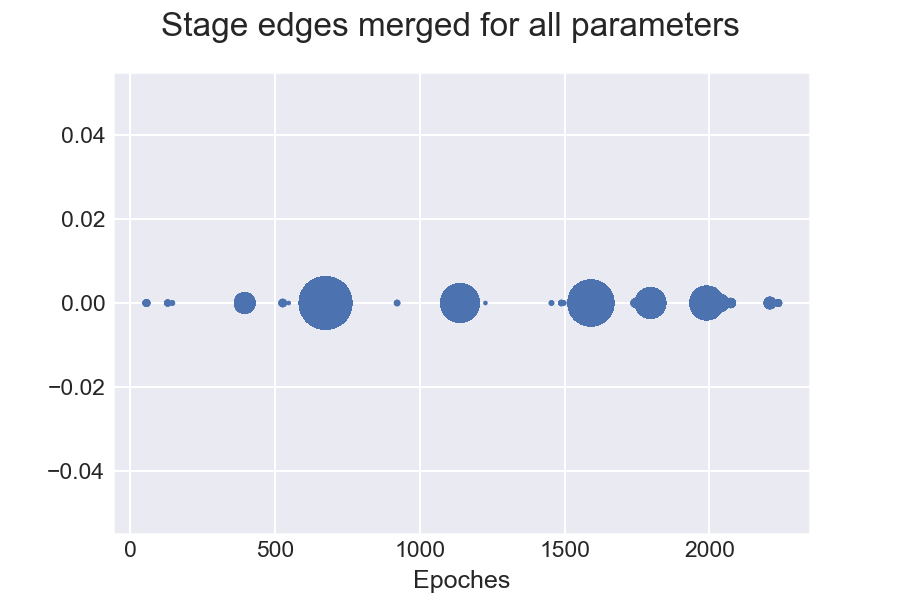

<IPython.core.display.Javascript object>


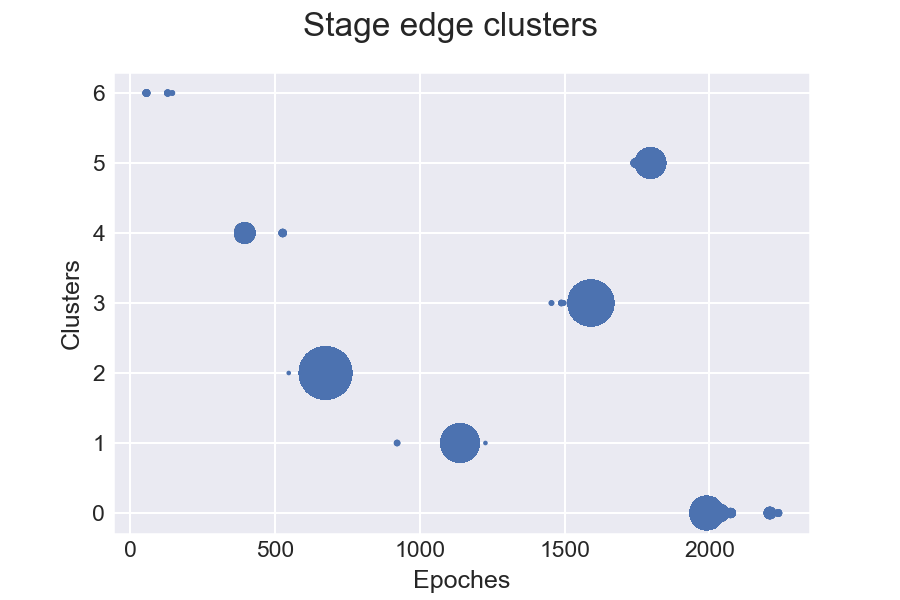

Text(0.5, 0.98, 'Stage edge clusters')

In [49]:
# Optimal number of clusters

n_stages = 8 # expert choise of result number of stages

st_len = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_len_min'].iloc[0]
k_nb = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['K_nb_max'].iloc[0]
n_cl = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['N_cl_max'].iloc[0]

st_edges_result = df_st_edges_best[df_st_edges_best['N_stages']==n_stages]['St_edges'].iloc[0]
print(st_edges_result)

st_edges_all = []
st_edges_list = []
st_edges_list += (df_st_edges[(df_st_edges['Len_min']==st_len) & (df_st_edges['K_neighb']<=k_nb) &
                  (df_st_edges['N_clusters']<=n_cl)]['St_edges'].tolist())
for _st_edges in st_edges_list:
    st_edges_all += _st_edges[1:-1].tolist()
st_edges_all = sorted(st_edges_all)
df_st_edges_all = pd.DataFrame(st_edges_all)
#print(st_edges_all)
            
# Clustering stage edges
cl_name = 'kmeans_edges_'+str(n_stages-1)+'_'+str(st_len)+'_'+str(k_nb)
cluster_method, df_st_edge_metrics = cq.apply_cluster_method(data=df_st_edges_all, cl_method=KMeans, 
                                                            name=cl_name, df_metrics=df_st_edge_metrics, 
                                                            n_clusters=n_stages-1, random_state=0)
edg_labels_all = cluster_method.labels_

# Find mean, median, mode, std, confidence interval
df_st_edg_stats = pd.DataFrame(columns=['Cluster name', 'Median', 'Mean', 'Mode', 'Mode probability', 'Standard deviation', 
                                        'Median conf_interval_0.95', 'Cluster size'])
st_clusters = []
for _st in range(n_stages-1):
    st_clusters.append([st_edges_all[i] for i in np.where(cluster_method.labels_ == _st)[0]])
    mode, count = sp.stats.mode(st_clusters[_st])
    conf_int_median = spr.median_confidence_interval(pd.Series(st_clusters[_st]), cutoff=0.95)
    
    new_row = {'Cluster name': 'Edge cluster '+str(_st), 'Median': int(np.median(st_clusters[_st])), 'Mean': int(np.array(st_clusters[_st]).mean()), 'Mode': mode[0], 
               'Mode probability': count[0]/len(st_clusters[_st]), 'Standard deviation': int(np.array(st_clusters[_st]).std()), 
               'Median conf_interval_0.95': conf_int_median, 'Cluster size': len(st_clusters[_st])}
    df_st_edg_stats = df_st_edg_stats.append(new_row, ignore_index = True)

df_st_edg_stats = df_st_edg_stats.sort_values('Median', ignore_index=True)
display(df_st_edg_stats)
#dfi.export(df_st_edg_stats, "Stage edges clustering stats.png")
    
# Plotting st_edges_all
x = st_edges_all
y = [0]*len(x)
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edges merged for all parameters', fontsize=16)
#plt.savefig('Stage edges merged.png')

# Plotting clusters    
x = st_edges_all
y = cluster_method.labels_
s = [1.5*x.count(x[i]) for i in range(len(x))]
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y, s=s)
ax.set(xlabel='Epoches', ylabel='Clusters')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig.suptitle('Stage edge clusters', fontsize=16)
#plt.savefig('Stage edge clusters.png')


In [50]:
# Calculate stage distances & clustering quality metrics

# Main data
df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()

st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
df_adj_st_metr['Centr'] = st_dist_centr
df_adj_st_metr['Ward'] = st_dist_ward

# Surrogate data
df_adj_st_metr_init = calc_stage_metr_noground(df_features, st_edges_init)
st_metr_silh_init = df_adj_st_metr_init['Silh'].to_numpy()
st_metr_calh_init = df_adj_st_metr_init['Cal-Har'].to_numpy()
st_metr_davb_init = df_adj_st_metr_init['Dav-Bold'].to_numpy()

st_dist_ward_init, st_dist_centr_init = spr.calc_stage_distances(df_features, st_edges_init)
df_adj_st_metr_init['Centr'] = st_dist_centr_init
df_adj_st_metr_init['Ward'] = st_dist_ward_init


# Max distance values for plotting
st_dist_centr_max = np.max(np.concatenate((st_dist_centr, st_dist_centr_init)))
st_dist_ward_max = np.max(np.concatenate((st_dist_ward, st_dist_ward_init)))
st_metr_silh_max = np.max(np.concatenate((st_metr_silh, st_metr_silh_init)))
st_metr_calh_max = np.max(np.concatenate((st_metr_calh, st_metr_calh_init)))
st_metr_davb_max = np.max(np.concatenate((st_metr_davb, st_metr_davb_init)))

print('Centr:', round(st_dist_centr_max,2), ' Silh:', round(st_metr_silh_max,2), ' Davb:', round(st_metr_davb_max,2), 
      ' Ward:', round(st_dist_ward_max,2), ' Calh:', round(st_metr_calh_max,2))
display(df_adj_st_metr)
display(df_adj_st_metr_init)


Centr: 20.96  Silh: 0.23  Davb: 3.5  Ward: 98341.69  Calh: 295.97


Stages  Silh  Cal-Har  Dav-Bold  Centr      Ward
0  St1_St2  0.08    21.10      2.97  10.98  5,883.28
1  St2_St3  0.07    50.84      3.38  10.00 15,313.75
2  St3_St4  0.23   227.96      1.68  20.96 76,563.39
3  St4_St5  0.23   295.97      1.69  20.72 98,341.69
4  St5_St6  0.20   160.00      1.83  19.22 52,290.18
5  St6_St7  0.19   106.09      1.89  18.92 35,746.00
6  St7_St8  0.19   144.49      1.96  17.75 44,663.21

Stages  Silh  Cal-Har  Dav-Bold  Centr      Ward
0  St1_St2  0.08    55.80      3.34  10.24 17,161.58
1  St2_St3  0.23   227.15      1.68  20.92 76,374.93
2  St3_St4  0.23   294.87      1.70  20.70 98,089.40
3  St4_St5  0.20   160.95      1.80  19.52 52,767.65
4  St5_St6  0.18   104.30      1.90  18.75 35,250.65
5  St6_St7  0.14    85.46      2.22  15.76 27,585.21
6  St7_St8  0.07    40.77      3.50   9.27 11,270.15

[ 5883.28066192 15313.75356979 76563.39031878 98341.6946922
 52290.17752214 35745.9999023  44663.20812036] [10.98044901 10.00306553 20.96253946 20.72470575 19.22295624 18.9151263
 17.75200733]
[58, 326, 247, 426, 418, 187, 175, 494]
[384, 248, 428, 417, 182, 181, 236, 258]


<IPython.core.display.Javascript object>


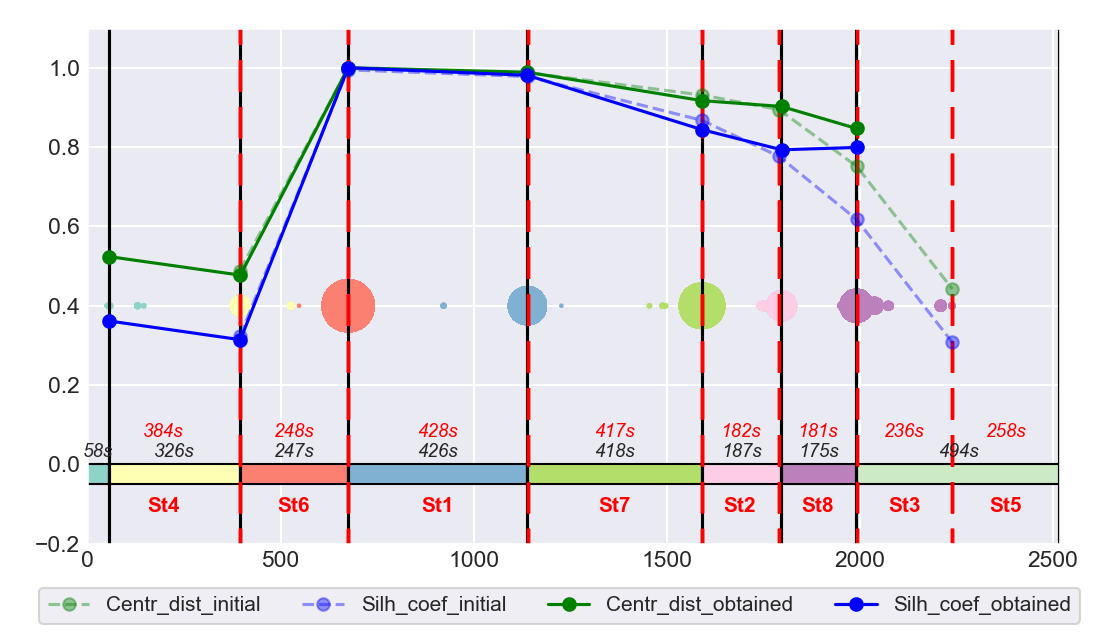

m08_stg shuffled stage boundaries.png


In [67]:
# Plotting stages, distances, silh between adjacent

df_features = df_ft_tot_pca

# New stages
st_bands, st_labels = spr.form_stage_bands(st_edges_result, n_samples)
n_stages = len(st_bands)

# Initial stages
st_init_bands, st_init_labels = spr.form_stage_bands(st_edges_init, n_samples)

# Initial names of stages (before shuffling stages)
st_init_names = ['St'+str(n+1) for n in shuf_piece_ind]

# Sorting cluster labels for st_edges_all
#edg_labels_all = cluster_method.labels_
labels_uq = sorted(set(edg_labels_all), key=list(edg_labels_all).index)
edg_labels_sort = []
for _cl in range(len(labels_uq)):
    edg_labels_sort += [_cl for i in np.where(edg_labels_all == labels_uq[_cl])[0]]

# Calculate stage distances & clustering quality metrics
#st_dist_ward = []
#st_dist_centr =[]
st_dist_ward, st_dist_centr = spr.calc_stage_distances(df_features, st_edges_result)
print(st_dist_ward, st_dist_centr)

df_adj_st_metr = calc_stage_metr_noground(df_features, st_edges_result)
st_metr_silh = df_adj_st_metr['Silh'].to_numpy()
st_metr_calh = df_adj_st_metr['Cal-Har'].to_numpy()
st_metr_davb = df_adj_st_metr['Dav-Bold'].to_numpy()


# Max distance values for plotting
st_dist_centr_max = np.max(st_dist_centr)
st_metr_silh_max = np.max(st_metr_silh)
st_metr_calh_max = np.max(st_metr_calh)
#st_metr_davb_max = np.max(st_metr_davb)


# Getting time length of the stages

# New stage partition
cluster_events = epochs_filt_rr.events.copy()
cluster_events[:,2] = st_labels
time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], st_bands[i][2]))
st_time_len = [round((time_bands[i][1]-time_bands[i][0])/sampling_rate) for i in range(n_stages)]
print(st_time_len)

# Initial stage partition
cluster_events = epochs_filt_rr.events.copy()
cluster_events[:,2] = st_init_labels
time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], st_bands[i][2]))
st_init_time_len = [round((time_bands[i][1]-time_bands[i][0])/sampling_rate) for i in range(n_stages)]
print(st_init_time_len)

    
# Plotting stages
pal = plt.get_cmap('Set3')
#pal = plt.get_cmap('gist_ncar')

fig, ax = plt.subplots(figsize=(6,4))
for _st in range(n_stages):
    # Set x & y limits
    (ymin, ymax) = (-0.2, 1.1)
    ax.set_ylim(ymin, ymax)
    ax.set_xlim(0, n_samples)
    
    # Stages plot
    (x_start, x_end, st_name) = st_bands[_st]
    (x_init_start, x_init_end, _) = st_init_bands[_st]
    x = np.arange(x_start, x_end+1)
    y = np.full(len(x), 0)    
    event_label = 'N=%d' % (x_end-x_start+1)
    ax.add_patch(Rectangle((x_start, -0.05), x_end-x_start, 0.05, edgecolor = 'black', 
                           #facecolor = pal(_st/(n_stages-1)), fill=True, lw=1)) # for 9 stages
                           facecolor = pal(_st/n_stages), fill=True, lw=1)) # for 8 stages
    
    # Vertical lines (stage boundaries)
    ax.vlines(x_end, ymin=ymin, ymax=ymax, color='black', linewidth=1.5) # black lines
    #ax.vlines(x_end, ymin=ymin, ymax=ymax, color=pal(_st/(n_stages-1))) # colored lines

    # Vertical lines (initial stage boundaries)
    ax.vlines(st_edges_init[1:-1], ymin=ymin, ymax=ymax, color='red', linewidth=1.5, linestyles=(5,(10,5)))
   
    # Scatter plot
    x_sc = [st_edges_all[i] for i in range(len(st_edges_all)) if edg_labels_sort[i]==_st]
    y_sc = np.full(len(x_sc), 0.4)
    s = [1.5*x_sc.count(x_sc[i]) for i in range(len(x_sc))]
    #ax.scatter(x_sc, y_sc, s=s, color=pal(_st/(n_stages-1))) # for 9 stages
    ax.scatter(x_sc, y_sc, s=s, color=pal(_st/n_stages)) # for 8 stages
    
    # Add text (st_name & st_length in sec)
    plt.text((x_init_start+x_init_end)/2, -0.12, st_init_names[_st], fontsize=10, fontweight='bold', 
             horizontalalignment='center', color='red')
    plt.text((x_start+x_end)/2, 0.02, str(st_time_len[_st])+'s', fontsize=9, fontstyle='italic', horizontalalignment='center')
    plt.text((x_init_start+x_init_end)/2, 0.07, str(st_init_time_len[_st])+'s', fontsize=9, fontstyle='italic',
             horizontalalignment='center', color='red')
    
# Adjacent stage distances (Centroid) & Silh coef 

# Initial boundaries
x_dist_init = st_edges_init[1:-1]
y_centr_init = [_dist/st_dist_centr_max for _dist in st_dist_centr_init]
y_silh_init = [_dist/st_metr_silh_max for _dist in st_metr_silh_init]
#y_calh_init = [_dist/st_metr_calh_max for _dist in st_metr_calh_init]
#y_davb_init = [_dist/st_metr_davb_max for _dist in st_metr_davb_init]
    
ax.plot(x_dist_init, y_centr_init, linestyle='--', marker='o', color='green', alpha=0.4, label='Centr_dist_initial')
ax.plot(x_dist_init, y_silh_init, linestyle='--', marker='o', color='blue', alpha=0.4, label='Silh_coef_initial')
#ax.plot(x_dist, y_calh, linestyle='--', marker='o', color='orange', label='Cal-Har metric')
#ax.plot(x_dist, y_davb, linestyle='--', marker='o', color='red', label='Dav-Bold metric')

# Found boundaries
x_dist = st_edges_result[1:-1]
y_centr = [_dist/st_dist_centr_max for _dist in st_dist_centr]
y_silh = [_dist/st_metr_silh_max for _dist in st_metr_silh]
#y_calh = [_dist/st_metr_calh_max for _dist in st_metr_calh]
#y_davb = [_dist/st_metr_davb_max for _dist in st_metr_davb]
    
ax.plot(x_dist, y_centr, linestyle='solid', marker='o', color='green', label='Centr_dist_obtained')
ax.plot(x_dist, y_silh, linestyle='solid', marker='o', color='blue', label='Silh_coef_obtained')
#ax.plot(x_dist, y_calh, linestyle='--', marker='o', color='orange', label='Cal-Har metric')
#ax.plot(x_dist, y_davb, linestyle='--', marker='o', color='red', label='Dav-Bold metric')

#ax.set(xlabel='Epoches')
ax.tick_params(axis='both', labelsize=11, direction='in')
fig_name = subj_dir_name_stg + ' shuffled stage boundaries.png'
plt.savefig(fig_name)
print(fig_name)

plt.tight_layout(rect=[-0.01,0.05,1,1])
handles, labels = ax.get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='lower center', ncol=4, fontsize=10)# , mode='expand')


In [71]:
# Getting time length of the stages

st_names =['Stage '+str(i+1) for i in range(n_stages)]
df_st_time_len = pd.DataFrame(columns=['Parameters']+st_names)

# New stage partition
cluster_events = epochs_filt_rr.events.copy()
cluster_events[:,2] = st_labels
time_bands = []
for i in range(n_stages):
    cl_samples = np.where(cluster_events[:,2] == i)[0]
    time_bands.append((cluster_events[cl_samples[0]][0], cluster_events[cl_samples[-1]][0], 'St'+str(i+1)))

# Start-end time
st_param_dict = dict([(st_names[i], (round(time_bands[i][0]/sampling_rate), round(time_bands[i][1]/sampling_rate))) 
                      for i in range(n_stages)])
new_row = {'Parameters': 'Start-end time, sec'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

# Time length, sec
st_param_dict = dict([(st_names[i], str((time_bands[i][1]-time_bands[i][0])/sampling_rate)) for i in range(n_stages)])
new_row = {'Parameters': 'Time length, sec'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

# Number of epochs, sec
st_param_dict = dict([(st_names[i], st_bands[i][1]-st_bands[i][0]+1) for i in range(n_stages)])
print(st_param_dict)
new_row = {'Parameters': 'Number of epochs'}
new_row.update(st_param_dict)
df_st_time_len = df_st_time_len.append(new_row, ignore_index = True)

print(time_bands)
print([((band[1]-band[0])/sampling_rate, band[2]) for band in time_bands])

display(df_st_time_len)    
df_st_time_len.to_excel(subj_dir_name_stg + ' df_st_time_len.xlsx')


{'Stage 1': 57, 'Stage 2': 339, 'Stage 3': 279, 'Stage 4': 464, 'Stage 5': 452, 'Stage 6': 206, 'Stage 7': 194, 'Stage 8': 526}
[(4650, 33850, 'St1'), (34250, 197050, 'St2'), (197850, 321450, 'St3'), (321850, 534650, 'St4'), (535450, 744650, 'St5'), (745050, 838650, 'St6'), (839050, 926650, 'St7'), (927050, 1174250, 'St8')]
[(58.4, 'St1'), (325.6, 'St2'), (247.2, 'St3'), (425.6, 'St4'), (418.4, 'St5'), (187.2, 'St6'), (175.2, 'St7'), (494.4, 'St8')]


Parameters  Stage 1    Stage 2     Stage 3      Stage 4  \
0  Start-end time, sec  (9, 68)  (68, 394)  (396, 643)  (644, 1069)   
1     Time length, sec     58.4      325.6       247.2        425.6   
2     Number of epochs       57        339         279          464   

        Stage 5       Stage 6       Stage 7       Stage 8  
0  (1071, 1489)  (1490, 1677)  (1678, 1853)  (1854, 2348)  
1         418.4         187.2         175.2         494.4  
2           452           206           194           526

# Saving data

In [68]:
# Saving epochs

epochs_filt_rr.save(os.path.join(dest_dir_path, 'epochs_filt_rr-epo.fif'), overwrite=True)
print(dest_dir_path)
print(epochs_filt_rr.get_data().shape)


Overwriting existing file.
C:\Users\Lenovo\PycharmProjects\Tibet\features\m08_stg
(2517, 40, 501)


In [69]:
# Saving main features DataFrames

df_ft_psd_loc_db.to_feather(os.path.join(dest_dir_path, 'df_ft_psd_loc_db.feather'))
df_ft_psd_plt_db.to_feather(os.path.join(dest_dir_path, 'df_ft_psd_plt_db.feather'))
df_ft_psd_all_db.to_feather(os.path.join(dest_dir_path, 'df_ft_psd_all_db.feather'))
df_ft_psd_ind_loc_log.to_feather(os.path.join(dest_dir_path, 'df_ft_psd_ind_loc_log.feather'))
df_ft_psd_ind_plt_log.to_feather(os.path.join(dest_dir_path, 'df_ft_psd_ind_plt_log.feather'))
df_ft_psd_ind_all_log.to_feather(os.path.join(dest_dir_path, 'df_ft_psd_ind_all_log.feather'))

#df_ft_coh.to_feather(os.path.join(dest_dir_path, 'df_ft_coh.feather'))
#df_ft_plv.to_feather(os.path.join(dest_dir_path, 'df_ft_plv.feather'))
df_ft_coh_loc.to_feather(os.path.join(dest_dir_path, 'df_ft_coh_loc.feather'))
df_ft_plv_loc.to_feather(os.path.join(dest_dir_path, 'df_ft_plv_loc.feather'))
df_ft_coh_plt.to_feather(os.path.join(dest_dir_path, 'df_ft_coh_plt.feather'))
df_ft_plv_plt.to_feather(os.path.join(dest_dir_path, 'df_ft_plv_plt.feather'))

df_ft_coh_ind_loc.to_feather(os.path.join(dest_dir_path, 'df_ft_coh_ind_loc.feather'))
df_ft_plv_ind_loc.to_feather(os.path.join(dest_dir_path, 'df_ft_plv_ind_loc.feather'))
df_ft_coh_ind_plt.to_feather(os.path.join(dest_dir_path, 'df_ft_coh_ind_plt.feather'))
df_ft_plv_ind_plt.to_feather(os.path.join(dest_dir_path, 'df_ft_plv_ind_plt.feather'))
df_ft_coh_ind_all.to_feather(os.path.join(dest_dir_path, 'df_ft_coh_ind_all.feather'))
df_ft_plv_ind_all.to_feather(os.path.join(dest_dir_path, 'df_ft_plv_ind_all.feather'))